In [40]:
import glob
import json
import os
import re
from typing import Dict, Any, Union, Tuple
from typing import List

import pandas as pd
from matplotlib import pyplot as plt
from pandas import DataFrame

In [41]:
plot_sat_name: str = '<sat_name>'
plot_desc_data_name: str = '<data_name>'

In [42]:
def load_json_data(file_path: str) -> pd.DataFrame:
    if not os.path.isfile(file_path):
        raise FileNotFoundError(f"The file {file_path} does not exist.")

    with open(file_path, 'r') as f:
        data = json.load(f)

    # Assuming that all items in the JSON file have the same structure
    keys: List[str] = list(data[0].keys())
    filtered_data: List[Dict[str, Any]] = [{key: item[key] for key in keys} for
                                           item in data]

    df: pd.DataFrame = pd.DataFrame(filtered_data)

    return df


def convert_to_universal_time_format(df: pd.DataFrame,
                                     to_period: str = 'D') -> pd.DataFrame:
    # Identify columns that match a regular expression pattern for "time"
    time_columns: List[str] = [col for col in df.columns if
                               re.match(r'.*Time.*|.*Obsdate*.|.*time-tag*.',
                                        col)]

    # Convert identified columns to datetime format and extract year and month
    for col in time_columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')
        df[col] = df[col].dt.to_period(to_period)

    # Group by year and month, and calculate the median of each group
    for col in time_columns:
        df = df.groupby(col).median().reset_index()

    return df


def rename_time_columns_to_universal_format(df: pd.DataFrame) -> pd.DataFrame:
    # Find time columns in the dataframe
    time_cols: List[str] = [col for col in df.columns if
                            re.match(r'.*Time.*|.*Obsdate*.|.*time-tag*.', col)]

    if len(time_cols) == 1:
        df.rename(columns={time_cols[0]: 'time'}, inplace=True)

    # Handle multiple time indices
    if len(time_cols) > 1:
        for i, col in enumerate(time_cols[1:], start=1):
            df.rename(columns={col: f'time{i}'}, inplace=True)

    return df


def merge_dataframes_by_time(df1: pd.DataFrame,
                             df2: pd.DataFrame) -> pd.DataFrame:
    # Process time columns in both dataframes
    df1 = rename_time_columns_to_universal_format(df1)
    df2 = rename_time_columns_to_universal_format(df2)

    # Merge dataframes
    merged_df: pd.DataFrame = pd.merge(df1, df2, how='inner')

    return merged_df


def filter_by_years(df: pd.DataFrame,
                    years_to_analyze: List[int]) -> pd.DataFrame:
    # Find time columns in the dataframe
    time_cols: List[str] = [col for col in df.columns if
                            re.match(r'.*Time.*|.*Obsdate*.|.*time-tag*.', col)]

    filtered_df: DataFrame = DataFrame()

    for col in time_cols:
        filtered_df = df[df[col].dt.year.isin(years_to_analyze)]

    return filtered_df


def calculate_correlation(df: pd.DataFrame, col1: str, col2: str) -> Tuple[
    Union[float, DataFrame], float, float]:
    correlation: Union[float, DataFrame] = df[col1].corr(df[col2])
    kendal_tau = df[col1].corr(df[col2], method='kendall')
    spearman = df[col1].corr(df[col2], method='spearman')
    return correlation, kendal_tau, spearman


def plot_scatter(df: pd.DataFrame, x_col: str, y_col: str) -> None:
    # Check if columns exist in dataframe
    if x_col not in df.columns or y_col not in df.columns:
        raise ValueError("One or both columns do not exist in the dataframe")

    # Check if columns contain numerical data
    if not pd.api.types.is_numeric_dtype(
            df[x_col]) or not pd.api.types.is_numeric_dtype(df[y_col]):
        raise TypeError("One or both columns are not numeric")

    plt.figure(figsize=(10, 8))
    plt.scatter(df[x_col], df[y_col])
    plt.title(
        f'{plot_sat_name}: plot of {x_col} ({plot_desc_data_name}) vs {y_col}')
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.show()


def plot_scatter_multiple(df: pd.DataFrame, x_col: str,
                          y_cols: List[str]) -> None:
    if len(y_cols) == 1:
        plot_scatter(df, x_col, y_cols[0])
        return

    # Check if x column exists in dataframe
    if x_col not in df.columns:
        raise ValueError("X column does not exist in the dataframe")

    # Check if x column contains numerical data
    if not pd.api.types.is_numeric_dtype(df[x_col]):
        raise TypeError("X column is not numeric")

    # Check if all y columns exist in dataframe and contain numerical data
    for y_col in y_cols:
        if y_col not in df.columns:
            raise ValueError(
                f"Y column {y_col} does not exist in the dataframe")
        if not pd.api.types.is_numeric_dtype(df[y_col]):
            raise TypeError(f"Y column {y_col} is not numeric")

    plt.figure(figsize=(10, 8))
    for y_col in y_cols:
        plt.scatter(df[x_col], df[y_col], label=y_col)
    plt.title(
        f'{plot_sat_name}: plot of {x_col} ({plot_desc_data_name}) vs multiple y-columns')
    plt.xlabel(x_col)
    plt.ylabel('Values')
    plt.legend()
    plt.show()


def calculate_correlations_and_plot(df: pd.DataFrame, col_list1: List[str],
                                    col_list2: List[str]) -> None:
    for col1 in col_list1:
        for col2 in col_list2:
            if col1 != col2:
                correlation, kendal_tau, spearman = calculate_correlation(df,
                                                                          col1,
                                                                          col2)
                print(f"sampling=[{len(df[col1])}]")
                print(
                    f"Correlation [{col1}] vs [{col2}]: classic=[{correlation}], spearman=[{spearman}], kendal_tau=[{kendal_tau}]")
            else:
                col_list2.remove(col1)
        plot_scatter_multiple(df, col1, col_list2)


def remove_non_numeric_data(df: pd.DataFrame) -> pd.DataFrame:
    # Ignore the first column
    cols_to_drop = []
    for col in df.columns[1:]:
        if df[col].dtype not in ['float64', 'int64']:
            cols_to_drop.append(col)

    return df.drop(cols_to_drop, axis=1)


def is_column_constant(df: pd.DataFrame, column: str,
                       required_unique_values_amount: int = 1) -> bool:
    unique_values = df[column].dropna().unique()
    return len(unique_values) <= required_unique_values_amount


def preprocess_solar_data(
        solar_data_file: Union[os.PathLike, str]) -> pd.DataFrame:
    df: DataFrame = load_json_data(solar_data_file)
    df = convert_to_universal_time_format(df)
    return df


def preprocess_satellite_data(satellite_data_file: Union[os.PathLike, str],
                              years_to_analyze: List[int]) -> pd.DataFrame:
    df: DataFrame = pd.read_csv(satellite_data_file)
    df = remove_non_numeric_data(df)
    df = convert_to_universal_time_format(df)
    filter_by_years(df, years_to_analyze)
    return df


def process(solar_data_file: Union[os.PathLike, str],
            satellite_data_file: Union[os.PathLike, str],
            years_to_analyze: List[int] = [2023, 2022, 2021, 2020, 2019,
                                           2014]) -> None:
    # Preprocess solar data
    df_solar = preprocess_solar_data(solar_data_file)

    # Preprocess satellite data
    df_satellite = preprocess_satellite_data(satellite_data_file,
                                             years_to_analyze)

    # Extract column names excluding time/date columns
    solar_column_names = [col for col in df_solar.columns if
                          not re.match(r'.*Time.*|.*Obsdate*.|.*time-tag*.',
                                       col)]
    satellite_column_names = [col for col in df_satellite.columns if
                              not re.match(r'.*Time.*|.*Obsdate*.|.*time-tag*.',
                                           col)]

    # Constants for the uniqueness coefficient threshold and the solar column index
    uniqueness_coefficient_threshold: float = 0.001
    solar_column_index: int = 0

    for satellite_column in satellite_column_names:
        min_unique_count = int(uniqueness_coefficient_threshold * len(
            df_solar[solar_column_names[solar_column_index]]))

        if is_column_constant(df_satellite, satellite_column, min_unique_count):
            print(
                f"[{plot_desc_data_name}]: skipping column=[{satellite_column}]: not enough unique values.")
            return

    # Merge dataframes by time
    df_solar_satellite_merged = merge_dataframes_by_time(df_solar, df_satellite)

    # Calculate correlations and plot
    calculate_correlations_and_plot(df_solar_satellite_merged,
                                    satellite_column_names, solar_column_names)


In [43]:
def analyze_satellite(sat_name: str):
    observed_solar_cycle_data_path = '../data/observed_solar_cycle_indices.json'
    sat_csv_data_files: List[str] = glob.glob(
        os.path.join(f"../data/{sat_name}", "*.csv"))

    global plot_sat_name
    plot_sat_name = sat_name

    for sat_file in sat_csv_data_files:
        print(sat_file)
        global plot_desc_data_name
        plot_desc_data_name = os.path.basename(sat_file)
        plot_desc_data_name = re.sub(r'-\d.*$|\.\w+$', '', plot_desc_data_name,
                                     flags=re.IGNORECASE)

        process(solar_data_file=observed_solar_cycle_data_path,
                satellite_data_file=os.path.abspath(sat_file))

../data/griffex/battery.csv
sampling=[58]
Correlation [Battery] vs [ssn]: classic=[-0.2446460872614315], spearman=[-0.22523893407370146], kendal_tau=[-0.18878599395916928]
sampling=[58]
Correlation [Battery] vs [smoothed_ssn]: classic=[-0.4443512273546712], spearman=[-0.3089644388620286], kendal_tau=[-0.2529605683605632]
sampling=[58]
Correlation [Battery] vs [observed_swpc_ssn]: classic=[-0.24624097738447528], spearman=[-0.20989237860542417], kendal_tau=[-0.17526851798899382]
sampling=[58]
Correlation [Battery] vs [smoothed_swpc_ssn]: classic=[-0.43920750176117057], spearman=[-0.30896919607664186], kendal_tau=[-0.2530378200247127]
sampling=[58]
Correlation [Battery] vs [f10.7]: classic=[-0.2946039851049375], spearman=[-0.25104608501601117], kendal_tau=[-0.20805940854324173]
sampling=[58]
Correlation [Battery] vs [smoothed_f10.7]: classic=[-0.38427335814731234], spearman=[-0.29927812528605396], kendal_tau=[-0.24612574959842096]


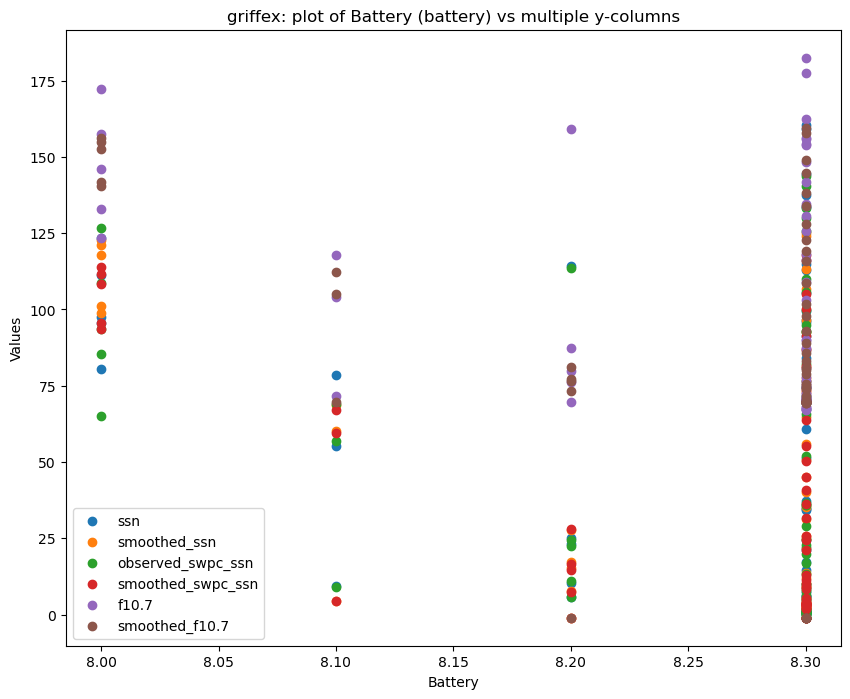

../data/griffex/battery_3v.csv
[battery_3v]: skipping column=[3.3V]: not enough unique values.
../data/griffex/battery_5v.csv
[battery_5v]: skipping column=[5V]: not enough unique values.
../data/griffex/bus_current.csv
sampling=[58]
Correlation [Battery Bus] vs [ssn]: classic=[0.3284914731546286], spearman=[0.642978637719449], kendal_tau=[0.440407716962973]
sampling=[58]
Correlation [Battery Bus] vs [smoothed_ssn]: classic=[0.26670973239237805], spearman=[0.4057277276062859], kendal_tau=[0.2790357457856696]
sampling=[58]
Correlation [Battery Bus] vs [observed_swpc_ssn]: classic=[0.3377301585511609], spearman=[0.6528373021483469], kendal_tau=[0.4469973251835352]
sampling=[58]
Correlation [Battery Bus] vs [smoothed_swpc_ssn]: classic=[0.2688800194533241], spearman=[0.40573397471317585], kendal_tau=[0.27912096055198216]
sampling=[58]
Correlation [Battery Bus] vs [f10.7]: classic=[0.31643507625535167], spearman=[0.6431969966910143], kendal_tau=[0.4646281321430685]
sampling=[58]
Correlatio

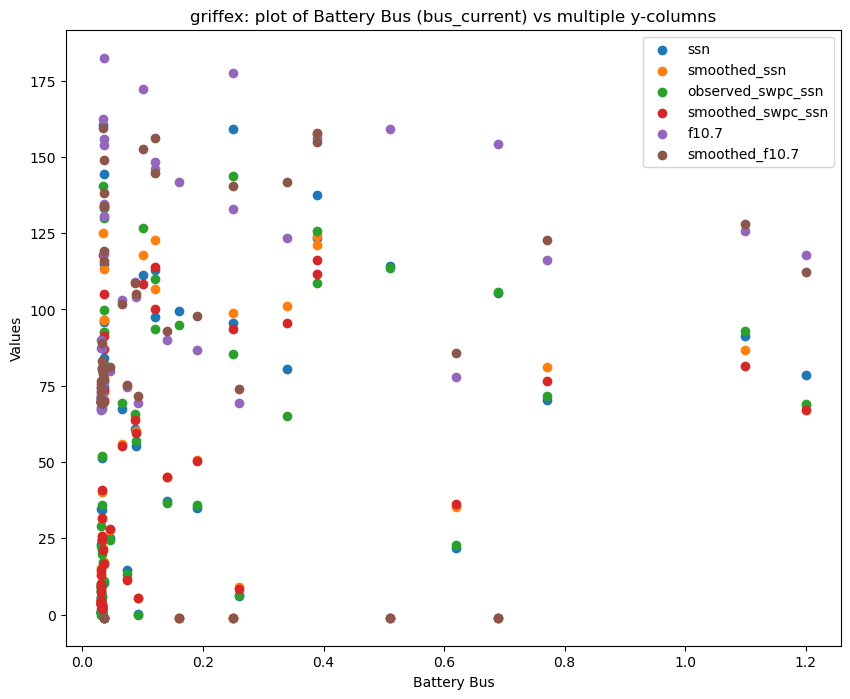

../data/griffex/bus_voltage.csv
sampling=[58]
Correlation [Battery Bus] vs [ssn]: classic=[0.022556501992514306], spearman=[0.08749423597673804], kendal_tau=[0.055507603680680806]
sampling=[58]
Correlation [Battery Bus] vs [smoothed_ssn]: classic=[-0.22275449883420909], spearman=[-0.1633434244924164], kendal_tau=[-0.13636614002379044]
sampling=[58]
Correlation [Battery Bus] vs [observed_swpc_ssn]: classic=[0.008492770011497987], spearman=[0.0858205243981047], kendal_tau=[0.057199223781644645]
sampling=[58]
Correlation [Battery Bus] vs [smoothed_swpc_ssn]: classic=[-0.2201208096395517], spearman=[-0.16334593953825416], kendal_tau=[-0.1364077848987951]
sampling=[58]
Correlation [Battery Bus] vs [f10.7]: classic=[-0.007310820979567499], spearman=[0.09631580452137425], kendal_tau=[0.06870072398763122]
sampling=[58]
Correlation [Battery Bus] vs [smoothed_f10.7]: classic=[-0.24300000039504804], spearman=[-0.1467016250467264], kendal_tau=[-0.12188375382640594]


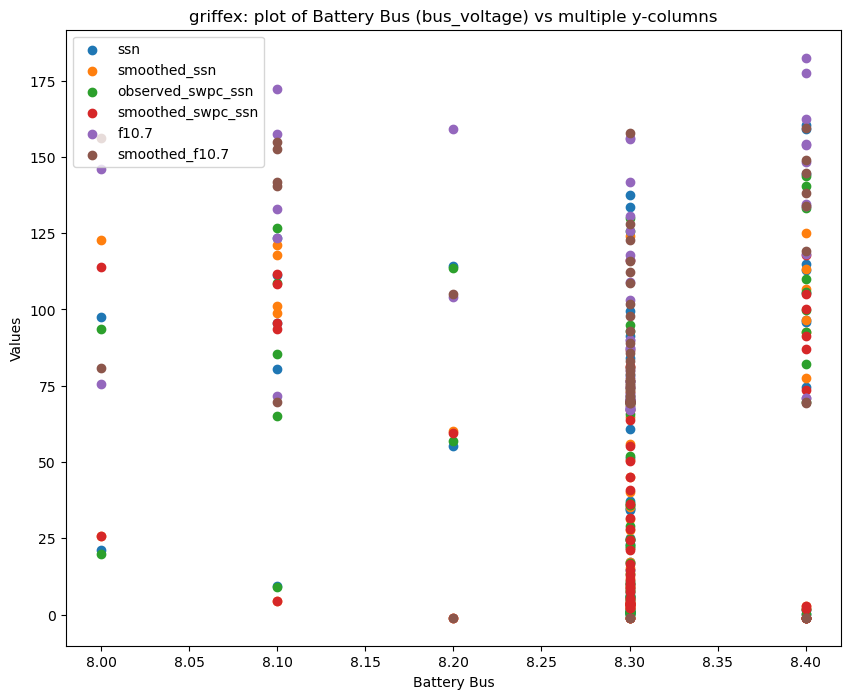

../data/griffex/data_mnt_usage.csv
sampling=[58]
Correlation [40379.median] vs [ssn]: classic=[0.637162185748502], spearman=[0.7097832522464436], kendal_tau=[0.5003122168403119]
sampling=[58]
Correlation [40379.median] vs [smoothed_ssn]: classic=[0.5515741412420309], spearman=[0.5308944216682393], kendal_tau=[0.3865449932025676]
sampling=[58]
Correlation [40379.median] vs [observed_swpc_ssn]: classic=[0.6440277155702275], spearman=[0.7008742436283982], kendal_tau=[0.49329855207003764]
sampling=[58]
Correlation [40379.median] vs [smoothed_swpc_ssn]: classic=[0.5595013492786407], spearman=[0.5305946478613002], kendal_tau=[0.38605123162536037]
sampling=[58]
Correlation [40379.median] vs [f10.7]: classic=[0.5920172640523478], spearman=[0.7090580017654341], kendal_tau=[0.5016845281762418]
sampling=[58]
Correlation [40379.median] vs [smoothed_f10.7]: classic=[0.27940371676771447], spearman=[0.5408323888841987], kendal_tau=[0.4120365672243364]


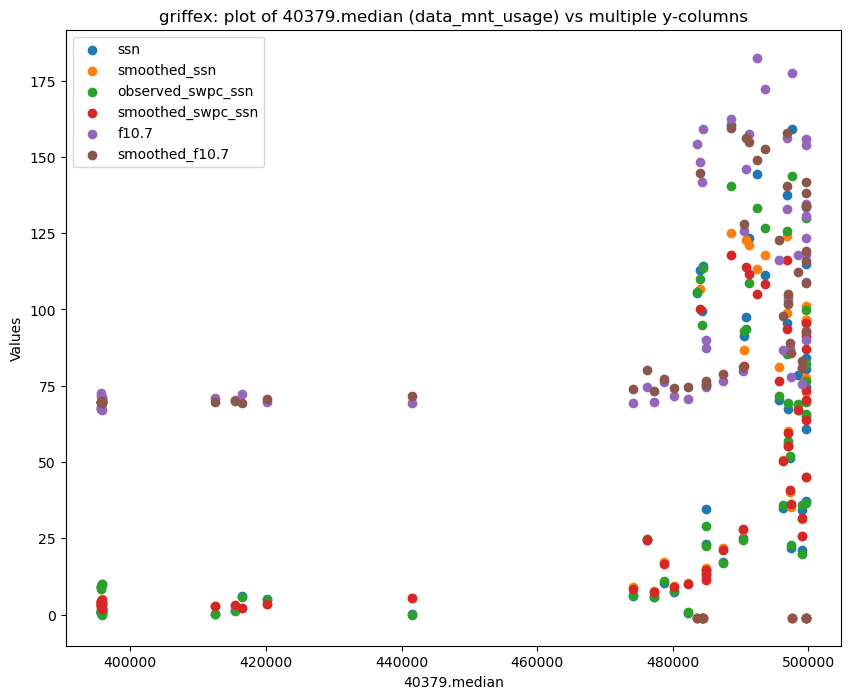

../data/griffex/memory_free_median.csv
sampling=[59]
Correlation [40379.freemem] vs [ssn]: classic=[-0.2411042204593763], spearman=[-0.27363350544886383], kendal_tau=[-0.18523619209716702]
sampling=[59]
Correlation [40379.freemem] vs [smoothed_ssn]: classic=[-0.17745734847730252], spearman=[-0.18988647890145155], kendal_tau=[-0.13584295080163833]
sampling=[59]
Correlation [40379.freemem] vs [observed_swpc_ssn]: classic=[-0.25317916213623615], spearman=[-0.2858211826607367], kendal_tau=[-0.1924733833665143]
sampling=[59]
Correlation [40379.freemem] vs [smoothed_swpc_ssn]: classic=[-0.18057788690302295], spearman=[-0.18890833261535903], kendal_tau=[-0.13528703841720185]
sampling=[59]
Correlation [40379.freemem] vs [f10.7]: classic=[-0.20524929181780188], spearman=[-0.23418571355338066], kendal_tau=[-0.15956677183723145]
sampling=[59]
Correlation [40379.freemem] vs [smoothed_f10.7]: classic=[-0.04504069677153957], spearman=[-0.193831411731043], kendal_tau=[-0.13457229033778448]


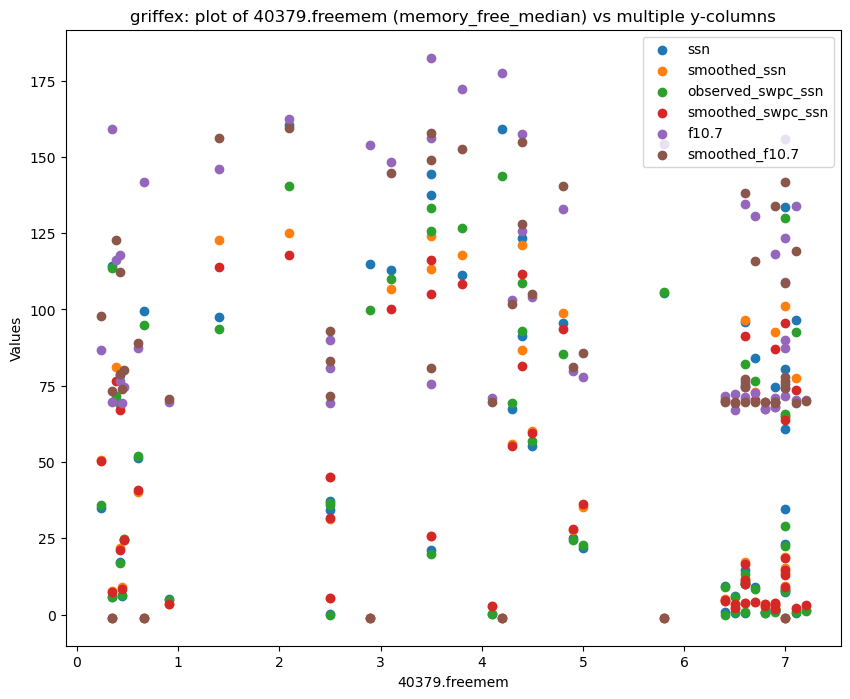

../data/griffex/memory_median.csv
[memory_median]: skipping column=[40379.median]: not enough unique values.
../data/griffex/resets.csv
sampling=[58]
Correlation [resets] vs [ssn]: classic=[0.23981497270115523], spearman=[0.47380970969273245], kendal_tau=[0.39793768369310534]
sampling=[58]
Correlation [resets] vs [smoothed_ssn]: classic=[0.17014199021093612], spearman=[0.2735751976330474], kendal_tau=[0.3275506965917313]
sampling=[58]
Correlation [resets] vs [observed_swpc_ssn]: classic=[0.2580242220806359], spearman=[0.4983846660308569], kendal_tau=[0.4139605653464266]
sampling=[58]
Correlation [resets] vs [smoothed_swpc_ssn]: classic=[0.16231337907958374], spearman=[0.2733023675088473], kendal_tau=[0.32704171112397673]
sampling=[58]
Correlation [resets] vs [f10.7]: classic=[0.2565094553742822], spearman=[0.4839712092702395], kendal_tau=[0.3921218602570539]
sampling=[58]
Correlation [resets] vs [smoothed_f10.7]: classic=[0.08666735932249871], spearman=[0.2871594317670099], kendal_tau=

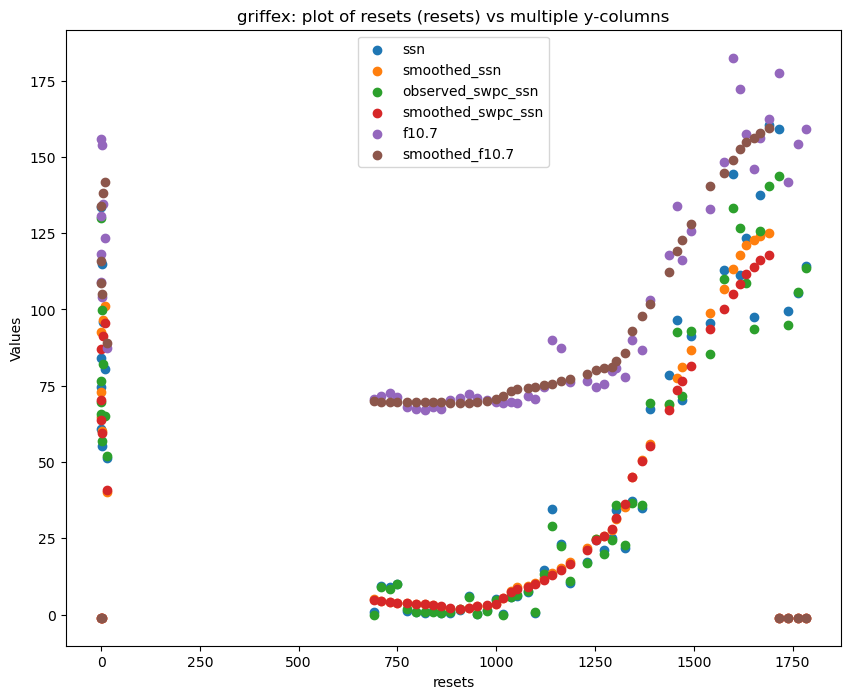

../data/griffex/rssi.csv
sampling=[58]
Correlation [40379.min] vs [ssn]: classic=[0.17133875980851407], spearman=[0.10843123210942907], kendal_tau=[0.06402758705753288]
sampling=[58]
Correlation [40379.min] vs [smoothed_ssn]: classic=[0.18431439916712322], spearman=[0.23800359582280195], kendal_tau=[0.1495320149183012]
sampling=[58]
Correlation [40379.min] vs [observed_swpc_ssn]: classic=[0.17787003764920925], spearman=[0.09682246872346378], kendal_tau=[0.06406642696832811]
sampling=[58]
Correlation [40379.min] vs [smoothed_swpc_ssn]: classic=[0.18688560288902645], spearman=[0.23715971110789302], kendal_tau=[0.14895959093279013]
sampling=[58]
Correlation [40379.min] vs [f10.7]: classic=[0.15965915294184166], spearman=[0.10516112083287384], kendal_tau=[0.06704491419265822]
sampling=[58]
Correlation [40379.min] vs [smoothed_f10.7]: classic=[0.11490241737432966], spearman=[0.22461503081076858], kendal_tau=[0.137101232552737]


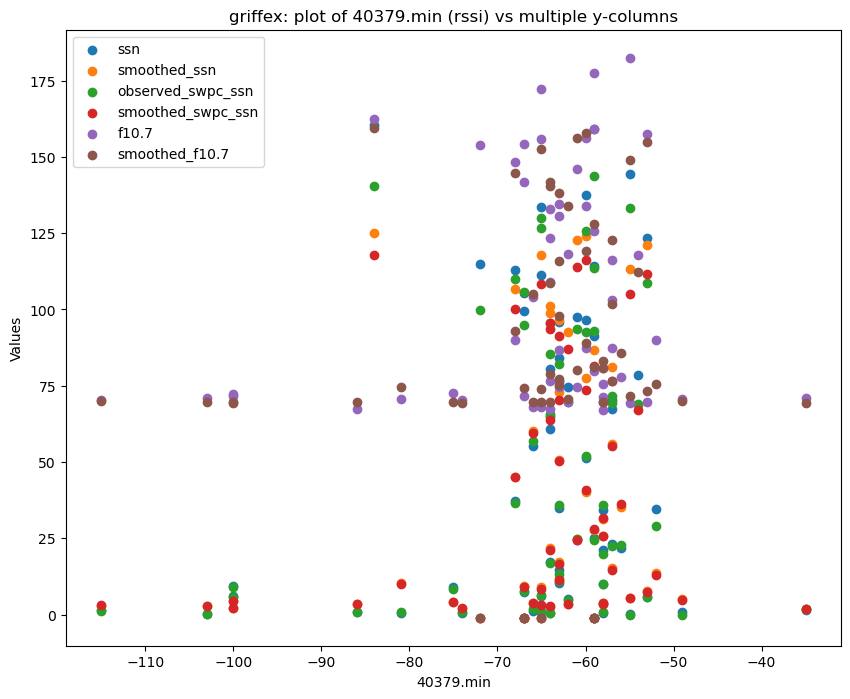

In [44]:
analyze_satellite('griffex')

../data/cas-5a/AGC Levels-data-2024-02-11 02 22 35.csv
sampling=[4]
Correlation [VHF AGC] vs [ssn]: classic=[0.5063598202986782], spearman=[0.4472135954999579], kendal_tau=[0.4082482904638631]
sampling=[4]
Correlation [VHF AGC] vs [smoothed_ssn]: classic=[-0.8799363294101686], spearman=[-0.8944271909999159], kendal_tau=[-0.8164965809277261]
sampling=[4]
Correlation [VHF AGC] vs [observed_swpc_ssn]: classic=[0.9292022268873248], spearman=[0.8944271909999159], kendal_tau=[0.8164965809277261]
sampling=[4]
Correlation [VHF AGC] vs [smoothed_swpc_ssn]: classic=[-0.9006695181861951], spearman=[-0.8944271909999159], kendal_tau=[-0.8164965809277261]
sampling=[4]
Correlation [VHF AGC] vs [f10.7]: classic=[0.9181174199527278], spearman=[0.8944271909999159], kendal_tau=[0.8164965809277261]
sampling=[4]
Correlation [VHF AGC] vs [smoothed_f10.7]: classic=[-0.8728715609439698], spearman=[-0.8944271909999159], kendal_tau=[-0.8164965809277261]


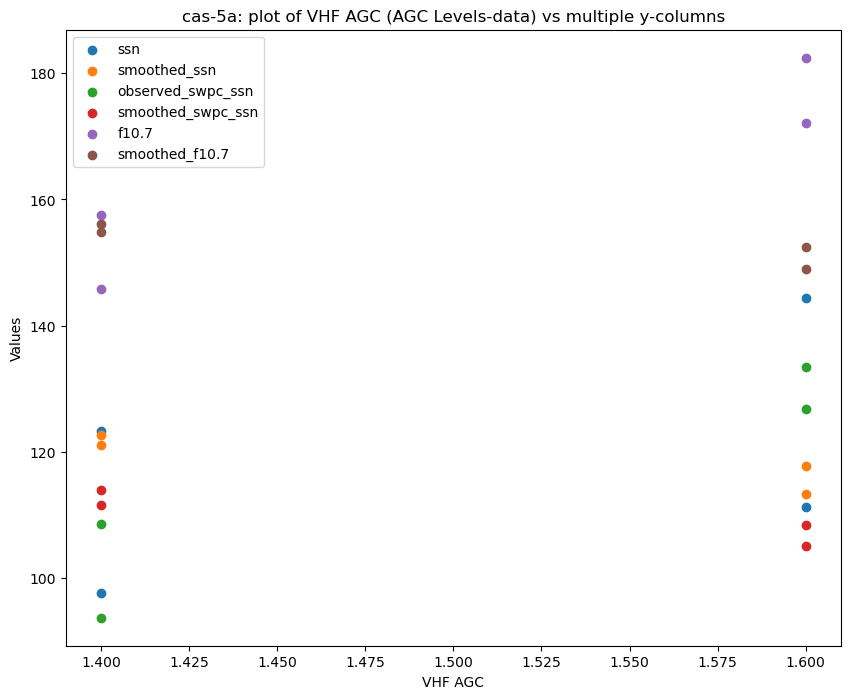

../data/cas-5a/Camera Photo Counters-data-2024-02-11 02 22 58.csv
sampling=[4]
Correlation [Cam #1] vs [ssn]: classic=[-0.8484782998328017], spearman=[-0.7745966692414834], kendal_tau=[-0.7071067811865477]
sampling=[4]
Correlation [Cam #1] vs [smoothed_ssn]: classic=[0.8709111028366147], spearman=[0.7745966692414834], kendal_tau=[0.7071067811865477]
sampling=[4]
Correlation [Cam #1] vs [observed_swpc_ssn]: classic=[-0.658822634347629], spearman=[-0.7745966692414834], kendal_tau=[-0.7071067811865477]
sampling=[4]
Correlation [Cam #1] vs [smoothed_swpc_ssn]: classic=[0.8098388513719774], spearman=[0.7745966692414834], kendal_tau=[0.7071067811865477]
sampling=[4]
Correlation [Cam #1] vs [f10.7]: classic=[-0.7451303336791715], spearman=[-0.7745966692414834], kendal_tau=[-0.7071067811865477]
sampling=[4]
Correlation [Cam #1] vs [smoothed_f10.7]: classic=[0.881917103688197], spearman=[0.7745966692414834], kendal_tau=[0.7071067811865477]


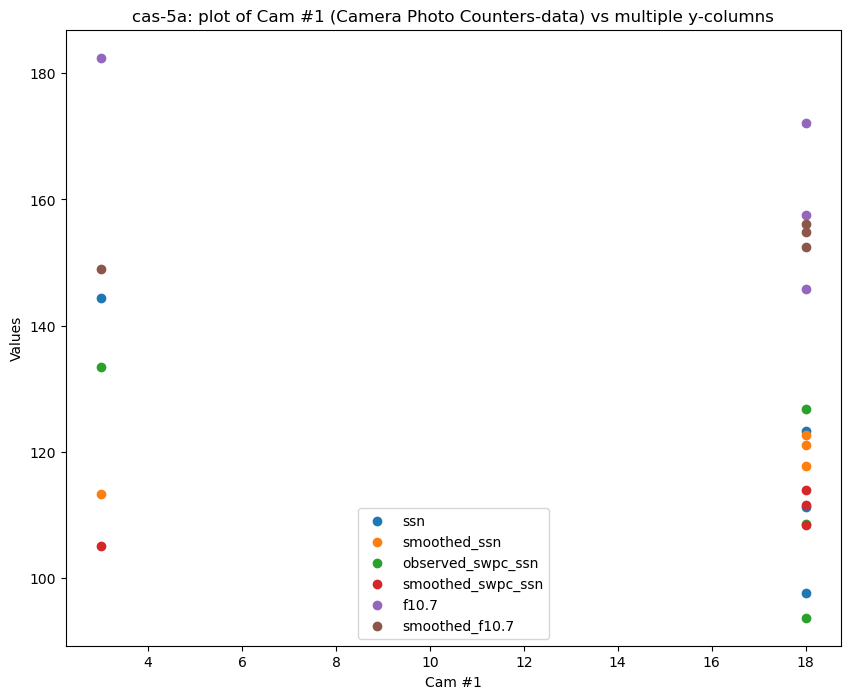

sampling=[4]
Correlation [Cam #2] vs [ssn]: classic=[-0.8484782998328017], spearman=[-0.7745966692414834], kendal_tau=[-0.7071067811865477]
sampling=[4]
Correlation [Cam #2] vs [smoothed_ssn]: classic=[0.8709111028366147], spearman=[0.7745966692414834], kendal_tau=[0.7071067811865477]
sampling=[4]
Correlation [Cam #2] vs [observed_swpc_ssn]: classic=[-0.6588226343476289], spearman=[-0.7745966692414834], kendal_tau=[-0.7071067811865477]
sampling=[4]
Correlation [Cam #2] vs [smoothed_swpc_ssn]: classic=[0.8098388513719773], spearman=[0.7745966692414834], kendal_tau=[0.7071067811865477]
sampling=[4]
Correlation [Cam #2] vs [f10.7]: classic=[-0.7451303336791715], spearman=[-0.7745966692414834], kendal_tau=[-0.7071067811865477]
sampling=[4]
Correlation [Cam #2] vs [smoothed_f10.7]: classic=[0.881917103688197], spearman=[0.7745966692414834], kendal_tau=[0.7071067811865477]


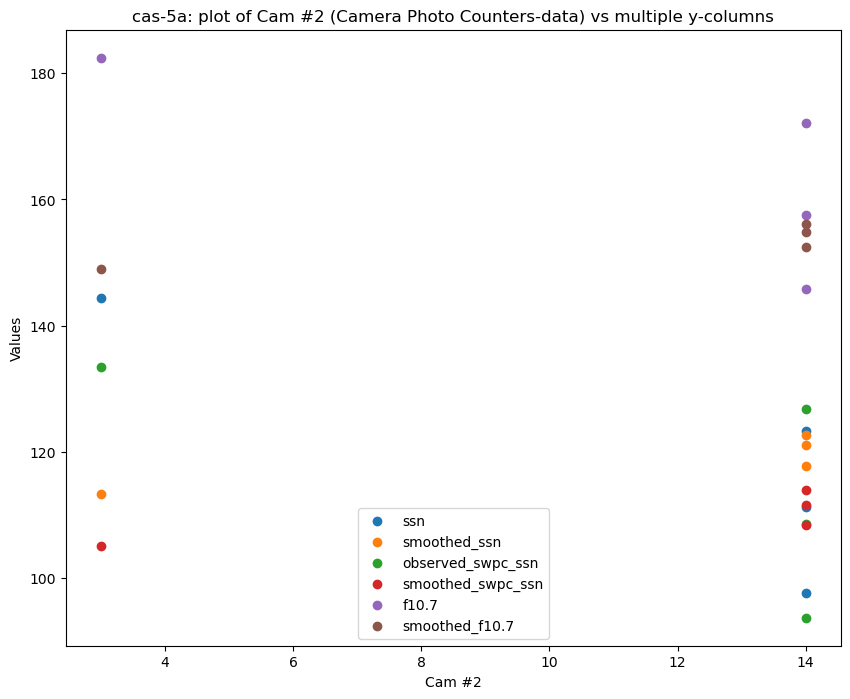

sampling=[4]
Correlation [Cam #3] vs [ssn]: classic=[-0.8484782998328017], spearman=[-0.7745966692414834], kendal_tau=[-0.7071067811865477]
sampling=[4]
Correlation [Cam #3] vs [smoothed_ssn]: classic=[0.8709111028366147], spearman=[0.7745966692414834], kendal_tau=[0.7071067811865477]
sampling=[4]
Correlation [Cam #3] vs [observed_swpc_ssn]: classic=[-0.6588226343476289], spearman=[-0.7745966692414834], kendal_tau=[-0.7071067811865477]
sampling=[4]
Correlation [Cam #3] vs [smoothed_swpc_ssn]: classic=[0.8098388513719774], spearman=[0.7745966692414834], kendal_tau=[0.7071067811865477]
sampling=[4]
Correlation [Cam #3] vs [f10.7]: classic=[-0.7451303336791715], spearman=[-0.7745966692414834], kendal_tau=[-0.7071067811865477]
sampling=[4]
Correlation [Cam #3] vs [smoothed_f10.7]: classic=[0.881917103688197], spearman=[0.7745966692414834], kendal_tau=[0.7071067811865477]


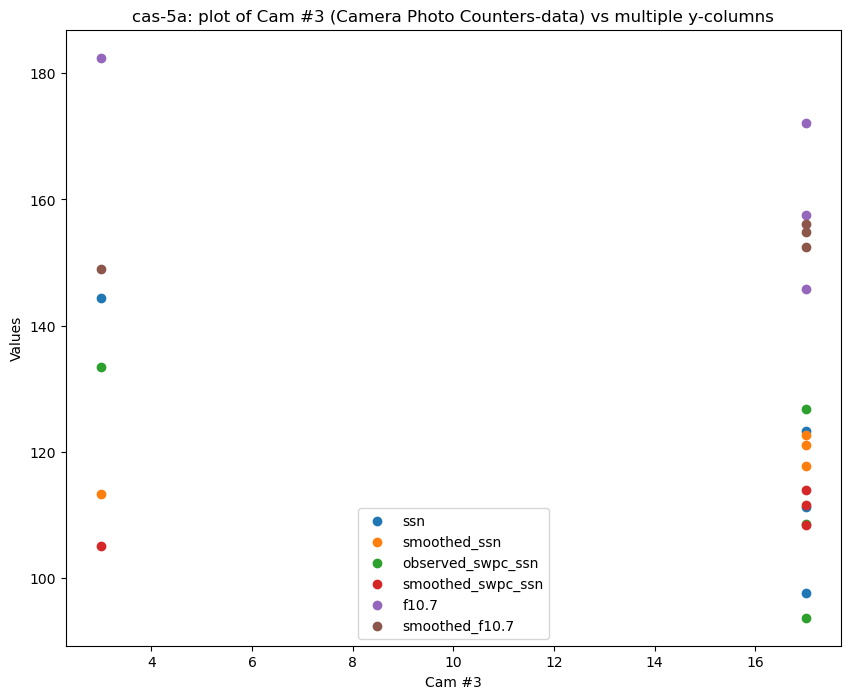

../data/cas-5a/Camera Status-data-2024-02-11 02 23 01.csv
../data/cas-5a/Image Data-data-2024-02-11 02 22 41.csv
[Image Data-data]: skipping column=[Year]: not enough unique values.
../data/cas-5a/Last Frame Rcvd By-data-2024-02-11 02 22 06.csv
[Last Frame Rcvd By-data]: skipping column=[observer where 0 is DK3WN-JN49lr]: not enough unique values.
../data/cas-5a/Operating Mode-data-2024-02-11 02 23 19.csv
../data/cas-5a/Power Supply Voltage-data-2024-02-11 02 21 52.csv
sampling=[0]
Correlation [54684.mode_mode V] vs [ssn]: classic=[nan], spearman=[nan], kendal_tau=[nan]
sampling=[0]
Correlation [54684.mode_mode V] vs [smoothed_ssn]: classic=[nan], spearman=[nan], kendal_tau=[nan]
sampling=[0]
Correlation [54684.mode_mode V] vs [observed_swpc_ssn]: classic=[nan], spearman=[nan], kendal_tau=[nan]
sampling=[0]
Correlation [54684.mode_mode V] vs [smoothed_swpc_ssn]: classic=[nan], spearman=[nan], kendal_tau=[nan]
sampling=[0]
Correlation [54684.mode_mode V] vs [f10.7]: classic=[nan], spear

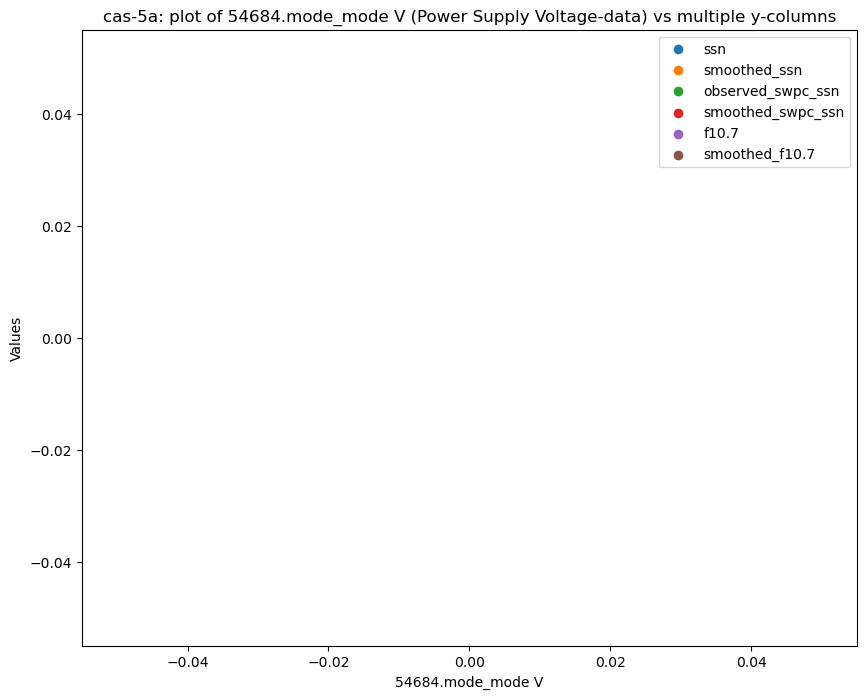

../data/cas-5a/RF Power-data-2024-02-11 02 22 25.csv
sampling=[4]
Correlation [UHF1 Power] vs [ssn]: classic=[-0.8497883816342445], spearman=[-0.7999999999999999], kendal_tau=[-0.6666666666666669]
sampling=[4]
Correlation [UHF1 Power] vs [smoothed_ssn]: classic=[0.9418664156443833], spearman=[1.0], kendal_tau=[1.0]
sampling=[4]
Correlation [UHF1 Power] vs [observed_swpc_ssn]: classic=[-0.7736672819063852], spearman=[-1.0], kendal_tau=[-1.0]
sampling=[4]
Correlation [UHF1 Power] vs [smoothed_swpc_ssn]: classic=[0.895553115932484], spearman=[1.0], kendal_tau=[1.0]
sampling=[4]
Correlation [UHF1 Power] vs [f10.7]: classic=[-0.8446225906764173], spearman=[-1.0], kendal_tau=[-1.0]
sampling=[4]
Correlation [UHF1 Power] vs [smoothed_f10.7]: classic=[0.9495238527075246], spearman=[1.0], kendal_tau=[1.0]


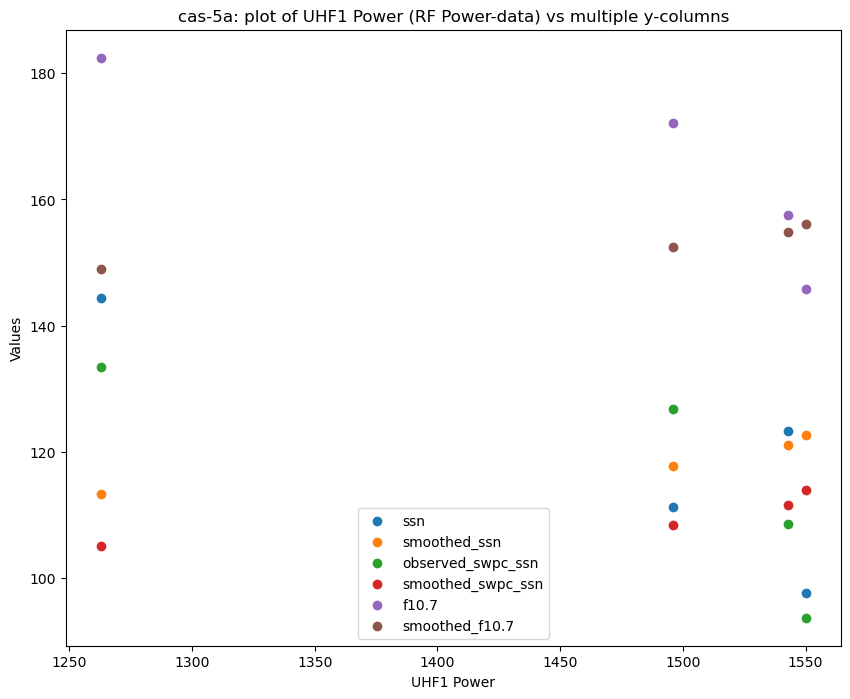

../data/cas-5a/System Currents-data-2024-02-11 02 22 13.csv
sampling=[4]
Correlation [Primary Bus Current] vs [ssn]: classic=[nan], spearman=[nan], kendal_tau=[nan]
sampling=[4]
Correlation [Primary Bus Current] vs [smoothed_ssn]: classic=[nan], spearman=[nan], kendal_tau=[nan]
sampling=[4]
Correlation [Primary Bus Current] vs [observed_swpc_ssn]: classic=[nan], spearman=[nan], kendal_tau=[nan]
sampling=[4]
Correlation [Primary Bus Current] vs [smoothed_swpc_ssn]: classic=[nan], spearman=[nan], kendal_tau=[nan]
sampling=[4]
Correlation [Primary Bus Current] vs [f10.7]: classic=[nan], spearman=[nan], kendal_tau=[nan]
sampling=[4]
Correlation [Primary Bus Current] vs [smoothed_f10.7]: classic=[nan], spearman=[nan], kendal_tau=[nan]


/home/geugenm/anaconda3/envs/course/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


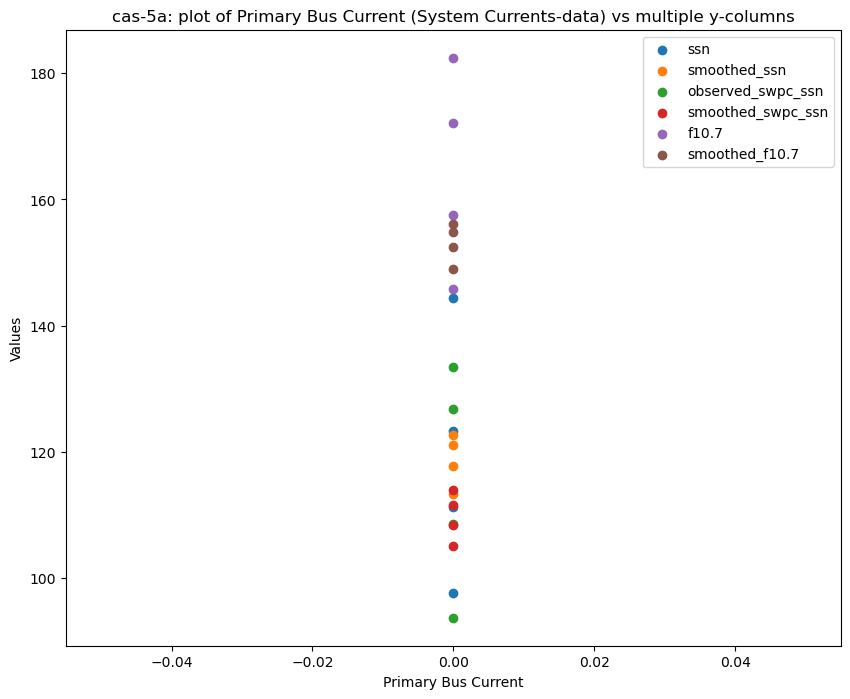

../data/cas-5a/System Temperatures (C)-data-2024-02-11 02 22 19.csv
sampling=[4]
Correlation [IHU] vs [ssn]: classic=[0.09973481133738984], spearman=[0.10540925533894598], kendal_tau=[0.18257418583505539]
sampling=[4]
Correlation [IHU] vs [smoothed_ssn]: classic=[0.3621702790603529], spearman=[0.10540925533894598], kendal_tau=[0.18257418583505539]
sampling=[4]
Correlation [IHU] vs [observed_swpc_ssn]: classic=[-0.20013630608949715], spearman=[-0.10540925533894598], kendal_tau=[-0.18257418583505539]
sampling=[4]
Correlation [IHU] vs [smoothed_swpc_ssn]: classic=[0.2893694267894126], spearman=[0.10540925533894598], kendal_tau=[0.18257418583505539]
sampling=[4]
Correlation [IHU] vs [f10.7]: classic=[-0.24627511056529341], spearman=[-0.10540925533894598], kendal_tau=[-0.18257418583505539]
sampling=[4]
Correlation [IHU] vs [smoothed_f10.7]: classic=[0.37283929381053704], spearman=[0.10540925533894598], kendal_tau=[0.18257418583505539]


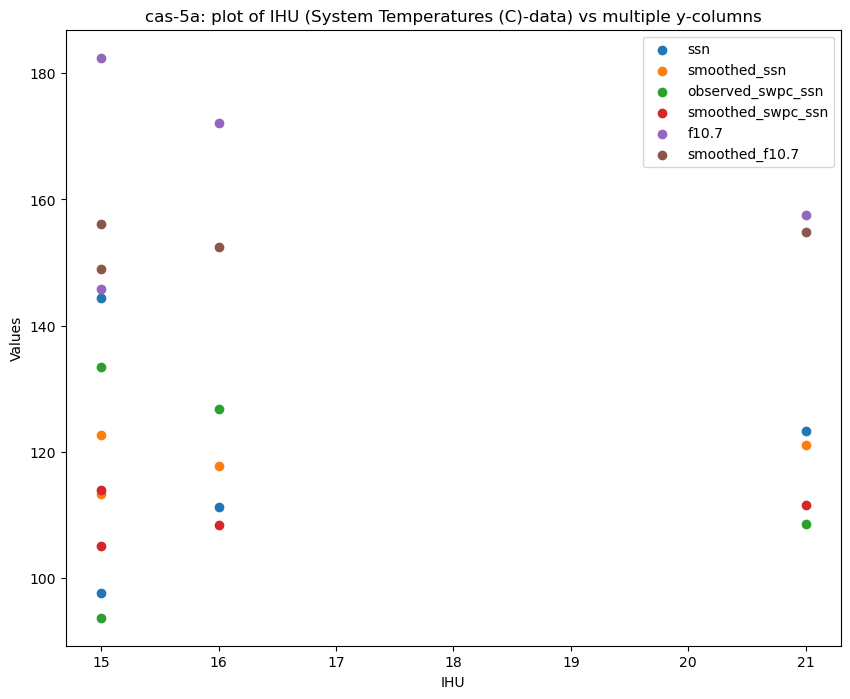

../data/cas-5a/Total Solar Array Current-data-2024-02-11 02 22 49.csv
[Total Solar Array Current-data]: skipping column=[Total Solar Array Current]: not enough unique values.
../data/cas-5a/Watchdog (48 hrs)-data-2024-02-11 02 23 13.csv
[Watchdog (48 hrs)-data]: skipping column=[YY]: not enough unique values.


In [45]:
analyze_satellite('cas-5a')

../data/cubebel-1/Solar Voltage-data-2024-02-11 02 19 56.csv
sampling=[7]
Correlation [43666.distinct] vs [ssn]: classic=[0.3437710686105114], spearman=[0.2672612419124244], kendal_tau=[0.1973855084879307]
sampling=[7]
Correlation [43666.distinct] vs [smoothed_ssn]: classic=[0.41050670854072363], spearman=[0.2672612419124244], kendal_tau=[0.1973855084879307]
sampling=[7]
Correlation [43666.distinct] vs [observed_swpc_ssn]: classic=[0.31140198408201164], spearman=[0.2672612419124244], kendal_tau=[0.1973855084879307]
sampling=[7]
Correlation [43666.distinct] vs [smoothed_swpc_ssn]: classic=[0.4099563762933071], spearman=[0.2672612419124244], kendal_tau=[0.1973855084879307]
sampling=[7]
Correlation [43666.distinct] vs [f10.7]: classic=[0.4257652343038453], spearman=[0.2672612419124244], kendal_tau=[0.1973855084879307]
sampling=[7]
Correlation [43666.distinct] vs [smoothed_f10.7]: classic=[0.4349180945808142], spearman=[0.2672612419124244], kendal_tau=[0.1973855084879307]


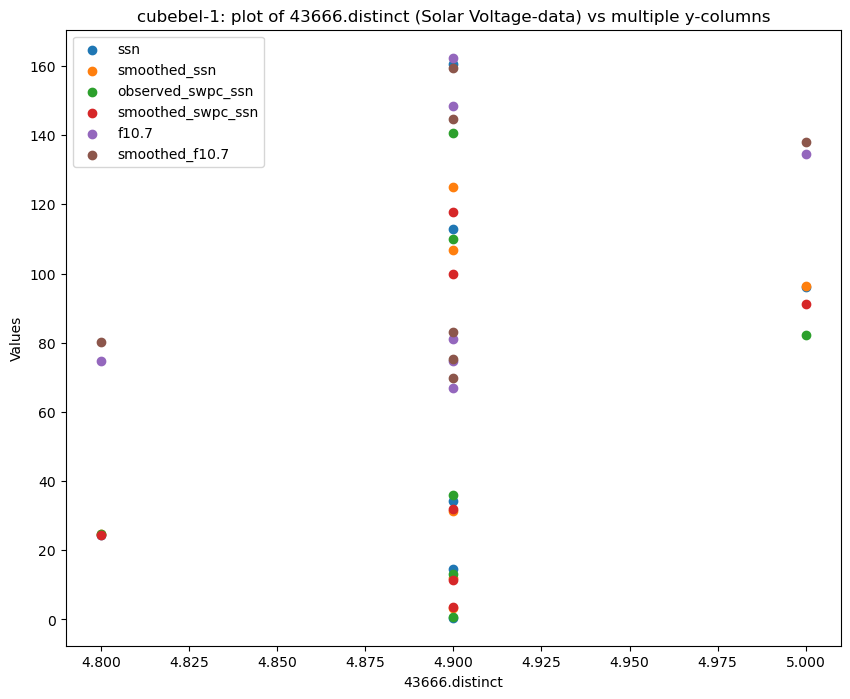

../data/cubebel-1/System 3.3V Voltage-data-2024-02-11 02 19 52.csv
sampling=[7]
Correlation [43666.distinct] vs [ssn]: classic=[-7.304314349630857e-17], spearman=[nan], kendal_tau=[nan]
sampling=[7]
Correlation [43666.distinct] vs [smoothed_ssn]: classic=[-8.697957395683197e-17], spearman=[nan], kendal_tau=[nan]
sampling=[7]
Correlation [43666.distinct] vs [observed_swpc_ssn]: classic=[0.0], spearman=[nan], kendal_tau=[nan]
sampling=[7]
Correlation [43666.distinct] vs [smoothed_swpc_ssn]: classic=[0.0], spearman=[nan], kendal_tau=[nan]
sampling=[7]
Correlation [43666.distinct] vs [f10.7]: classic=[5.394698605447493e-17], spearman=[nan], kendal_tau=[nan]
sampling=[7]
Correlation [43666.distinct] vs [smoothed_f10.7]: classic=[-1.143130496931303e-16], spearman=[nan], kendal_tau=[nan]


/home/geugenm/anaconda3/envs/course/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


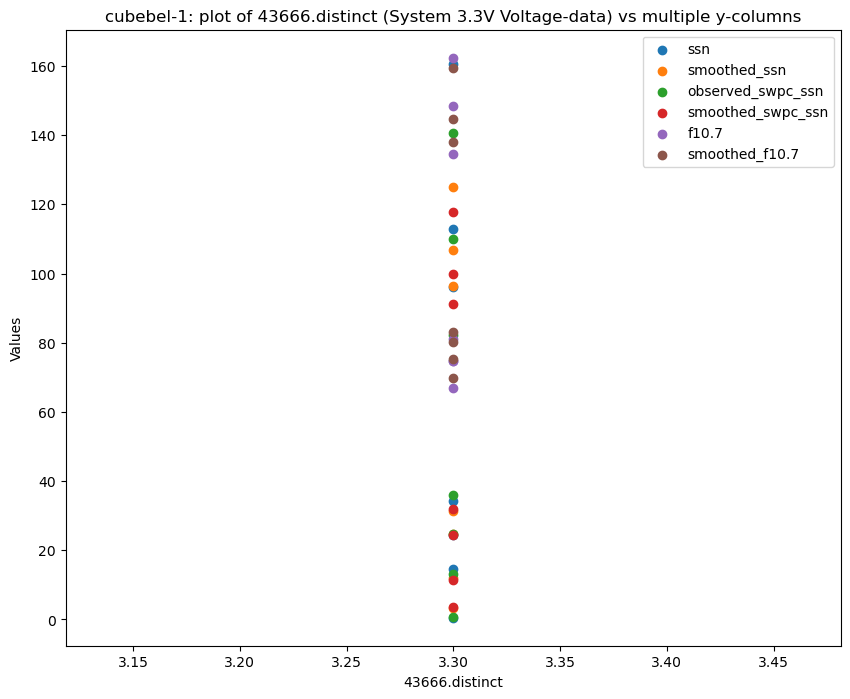

../data/cubebel-1/System 5V Voltage-data-2024-02-11 02 19 58.csv
sampling=[7]
Correlation [43666.distinct] vs [ssn]: classic=[-0.5955492836365504], spearman=[-0.47809144373375745], kendal_tau=[-0.4665694748158435]
sampling=[7]
Correlation [43666.distinct] vs [smoothed_ssn]: classic=[-0.6279592689850381], spearman=[-0.47809144373375745], kendal_tau=[-0.4665694748158435]
sampling=[7]
Correlation [43666.distinct] vs [observed_swpc_ssn]: classic=[-0.5898708777613991], spearman=[-0.47809144373375745], kendal_tau=[-0.4665694748158435]
sampling=[7]
Correlation [43666.distinct] vs [smoothed_swpc_ssn]: classic=[-0.625299911346128], spearman=[-0.47809144373375745], kendal_tau=[-0.4665694748158435]
sampling=[7]
Correlation [43666.distinct] vs [f10.7]: classic=[-0.6509484698503492], spearman=[-0.47809144373375745], kendal_tau=[-0.4665694748158435]
sampling=[7]
Correlation [43666.distinct] vs [smoothed_f10.7]: classic=[-0.6493933273416828], spearman=[-0.47809144373375745], kendal_tau=[-0.4665694748

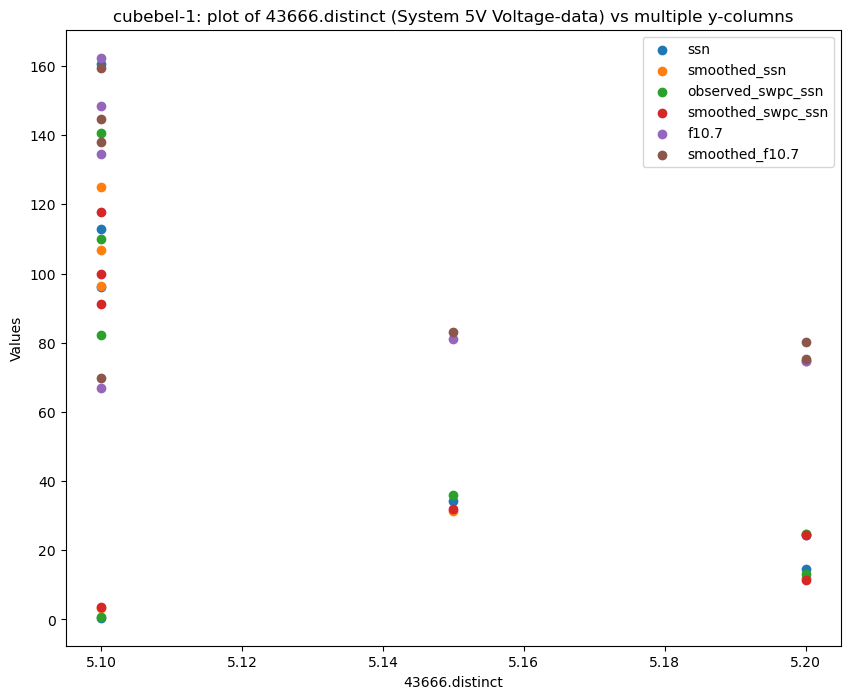

../data/cubebel-1/System Currents-data-2024-02-11 02 19 49.csv
sampling=[32]
Correlation [After BQ Current] vs [ssn]: classic=[-0.2588313321730435], spearman=[-0.29313521890151284], kendal_tau=[-0.17959520277378652]
sampling=[32]
Correlation [After BQ Current] vs [smoothed_ssn]: classic=[-0.19845915449108323], spearman=[-0.22809448283496314], kendal_tau=[-0.1688778819768816]
sampling=[32]
Correlation [After BQ Current] vs [observed_swpc_ssn]: classic=[-0.255553658089648], spearman=[-0.28290809904657954], kendal_tau=[-0.15321956725252794]
sampling=[32]
Correlation [After BQ Current] vs [smoothed_swpc_ssn]: classic=[-0.20471067347614397], spearman=[-0.22499554840175506], kendal_tau=[-0.16701165216415403]
sampling=[32]
Correlation [After BQ Current] vs [f10.7]: classic=[-0.23260806365601128], spearman=[-0.2803928960352564], kendal_tau=[-0.1770165750842012]
sampling=[32]
Correlation [After BQ Current] vs [smoothed_f10.7]: classic=[-0.008968089640525603], spearman=[-0.3583120308257183], ken

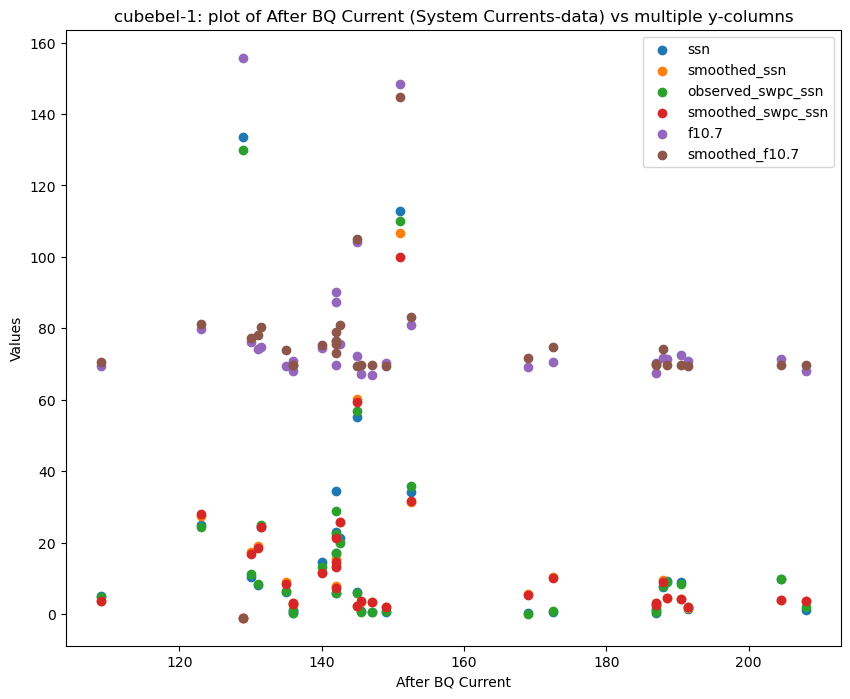

In [46]:
analyze_satellite('cubebel-1')

../data/cubebel-2/MB Reset Reason-data-2024-02-11 02 22 30.csv
[MB Reset Reason-data]: skipping column=[last]: not enough unique values.
../data/cubebel-2/MB Uptime-data-2024-02-11 02 22 39.csv
sampling=[6]
Correlation [57175.tlm_mb_time] vs [ssn]: classic=[-0.1670621258031654], spearman=[-0.3714285714285715], kendal_tau=[-0.2]
sampling=[6]
Correlation [57175.tlm_mb_time] vs [smoothed_ssn]: classic=[nan], spearman=[nan], kendal_tau=[nan]
sampling=[6]
Correlation [57175.tlm_mb_time] vs [observed_swpc_ssn]: classic=[-0.04559419187287851], spearman=[0.028571428571428574], kendal_tau=[0.06666666666666665]
sampling=[6]
Correlation [57175.tlm_mb_time] vs [smoothed_swpc_ssn]: classic=[nan], spearman=[nan], kendal_tau=[nan]
sampling=[6]
Correlation [57175.tlm_mb_time] vs [f10.7]: classic=[0.056644337465249946], spearman=[0.2571428571428572], kendal_tau=[0.2]
sampling=[6]
Correlation [57175.tlm_mb_time] vs [smoothed_f10.7]: classic=[nan], spearman=[nan], kendal_tau=[nan]


/home/geugenm/anaconda3/envs/course/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


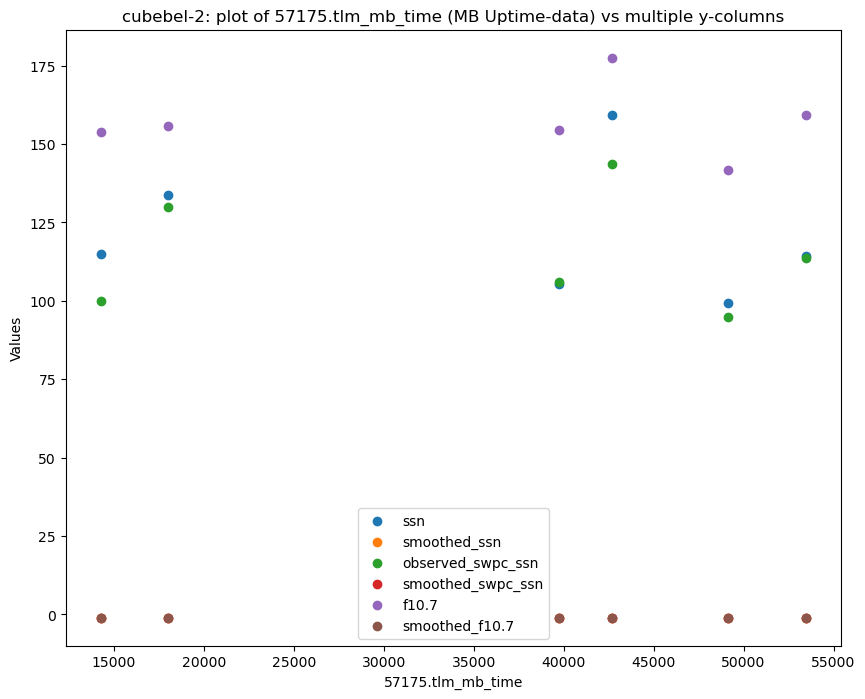

../data/cubebel-2/Resets-data-2024-02-11 02 22 26.csv
sampling=[6]
Correlation [beacon_reset_total_cnt] vs [ssn]: classic=[0.6722877336980692], spearman=[0.7714285714285715], kendal_tau=[0.6]
sampling=[6]
Correlation [beacon_reset_total_cnt] vs [smoothed_ssn]: classic=[nan], spearman=[nan], kendal_tau=[nan]
sampling=[6]
Correlation [beacon_reset_total_cnt] vs [observed_swpc_ssn]: classic=[0.554336693456288], spearman=[0.7142857142857143], kendal_tau=[0.6]
sampling=[6]
Correlation [beacon_reset_total_cnt] vs [smoothed_swpc_ssn]: classic=[nan], spearman=[nan], kendal_tau=[nan]
sampling=[6]
Correlation [beacon_reset_total_cnt] vs [f10.7]: classic=[0.7439706460675419], spearman=[0.8285714285714287], kendal_tau=[0.7333333333333333]
sampling=[6]
Correlation [beacon_reset_total_cnt] vs [smoothed_f10.7]: classic=[nan], spearman=[nan], kendal_tau=[nan]


/home/geugenm/anaconda3/envs/course/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


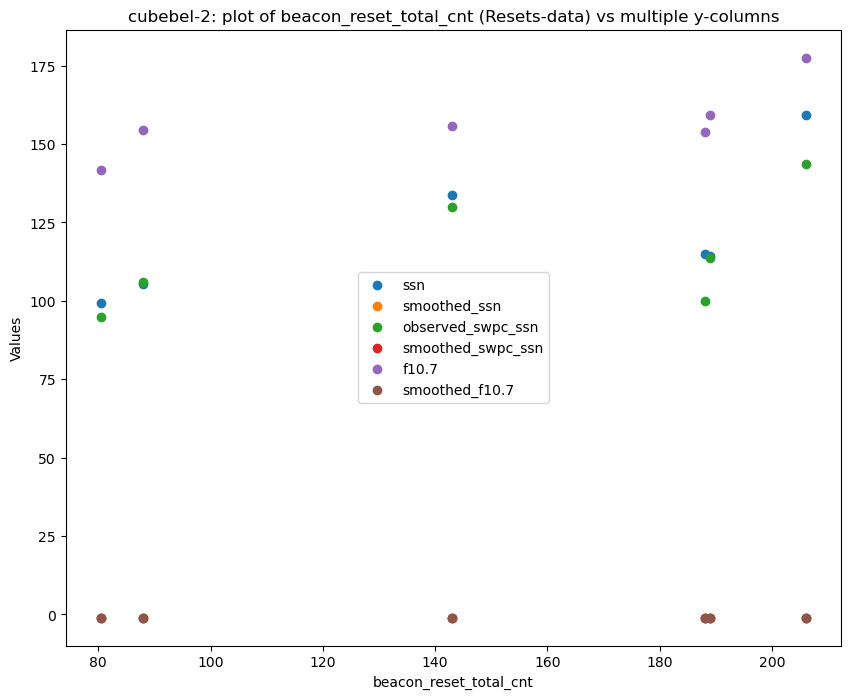

../data/cubebel-2/Sat Time-data-2024-02-11 02 22 43.csv
sampling=[6]
Correlation [57175.tlm_trx_cmn_rtc_unixtime] vs [ssn]: classic=[-0.7641550361897786], spearman=[-0.7142857142857143], kendal_tau=[-0.4666666666666666]
sampling=[6]
Correlation [57175.tlm_trx_cmn_rtc_unixtime] vs [smoothed_ssn]: classic=[nan], spearman=[nan], kendal_tau=[nan]
sampling=[6]
Correlation [57175.tlm_trx_cmn_rtc_unixtime] vs [observed_swpc_ssn]: classic=[-0.5500531852125411], spearman=[-0.3142857142857143], kendal_tau=[-0.2]
sampling=[6]
Correlation [57175.tlm_trx_cmn_rtc_unixtime] vs [smoothed_swpc_ssn]: classic=[nan], spearman=[nan], kendal_tau=[nan]
sampling=[6]
Correlation [57175.tlm_trx_cmn_rtc_unixtime] vs [f10.7]: classic=[-0.5835354247390303], spearman=[-0.14285714285714288], kendal_tau=[-0.06666666666666665]
sampling=[6]
Correlation [57175.tlm_trx_cmn_rtc_unixtime] vs [smoothed_f10.7]: classic=[nan], spearman=[nan], kendal_tau=[nan]


/home/geugenm/anaconda3/envs/course/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


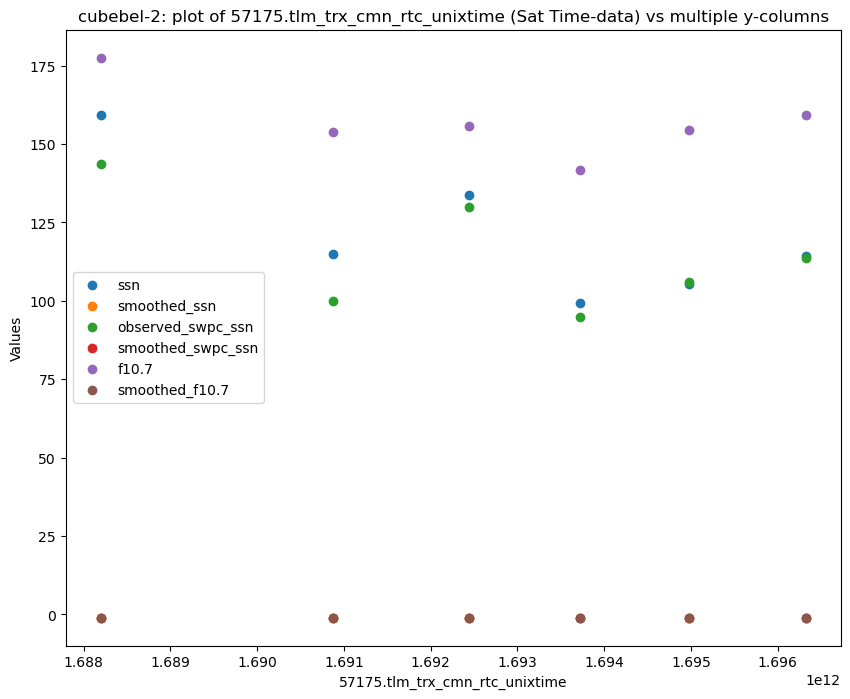

../data/cubebel-2/Solar Panel Current-data-2024-02-11 02 22 37.csv
sampling=[6]
Correlation [tlm_mb_solarpanel_1_current(mA) mA] vs [ssn]: classic=[-0.044813987468537264], spearman=[0.6], kendal_tau=[0.3333333333333333]
sampling=[6]
Correlation [tlm_mb_solarpanel_1_current(mA) mA] vs [smoothed_ssn]: classic=[nan], spearman=[nan], kendal_tau=[nan]
sampling=[6]
Correlation [tlm_mb_solarpanel_1_current(mA) mA] vs [observed_swpc_ssn]: classic=[-0.2879922190846097], spearman=[0.14285714285714288], kendal_tau=[0.06666666666666665]
sampling=[6]
Correlation [tlm_mb_solarpanel_1_current(mA) mA] vs [smoothed_swpc_ssn]: classic=[nan], spearman=[nan], kendal_tau=[nan]
sampling=[6]
Correlation [tlm_mb_solarpanel_1_current(mA) mA] vs [f10.7]: classic=[-0.08374274475200033], spearman=[-0.08571428571428573], kendal_tau=[-0.06666666666666665]
sampling=[6]
Correlation [tlm_mb_solarpanel_1_current(mA) mA] vs [smoothed_f10.7]: classic=[nan], spearman=[nan], kendal_tau=[nan]


/home/geugenm/anaconda3/envs/course/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


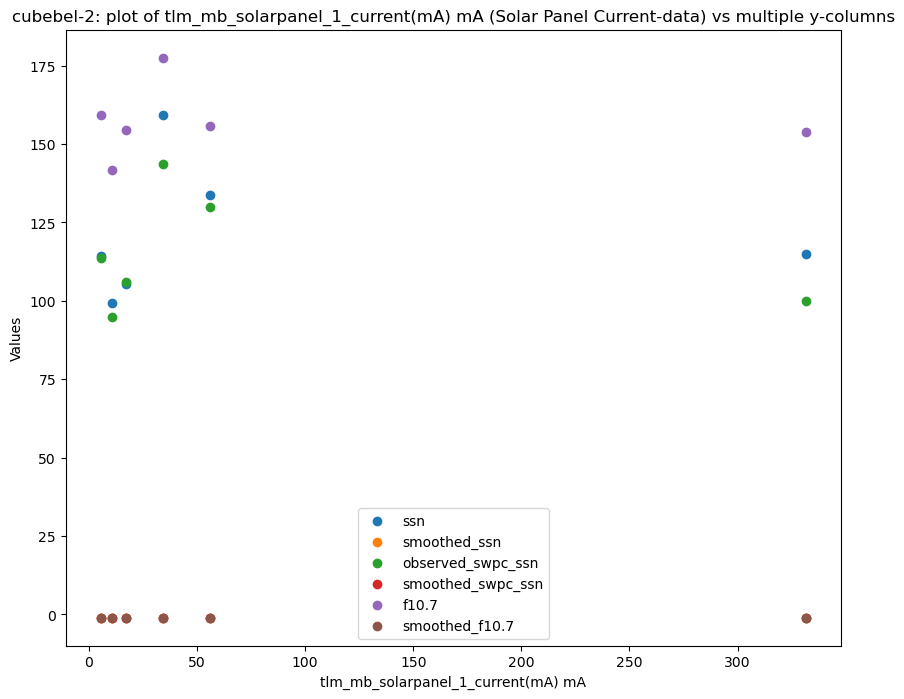

../data/cubebel-2/Solar Panel Temperatures-data-2024-02-11 02 22 03.csv
../data/cubebel-2/Solar Panel Voltages-data-2024-02-11 02 21 48.csv
sampling=[6]
Correlation [tlm_mb_solarpanel_0_volt_pos V] vs [ssn]: classic=[0.20640302064735788], spearman=[0.5428571428571429], kendal_tau=[0.4666666666666666]
sampling=[6]
Correlation [tlm_mb_solarpanel_0_volt_pos V] vs [smoothed_ssn]: classic=[nan], spearman=[nan], kendal_tau=[nan]
sampling=[6]
Correlation [tlm_mb_solarpanel_0_volt_pos V] vs [observed_swpc_ssn]: classic=[0.08504079603976054], spearman=[0.5428571428571429], kendal_tau=[0.4666666666666666]
sampling=[6]
Correlation [tlm_mb_solarpanel_0_volt_pos V] vs [smoothed_swpc_ssn]: classic=[nan], spearman=[nan], kendal_tau=[nan]
sampling=[6]
Correlation [tlm_mb_solarpanel_0_volt_pos V] vs [f10.7]: classic=[-0.01589880958080696], spearman=[0.3714285714285715], kendal_tau=[0.3333333333333333]
sampling=[6]
Correlation [tlm_mb_solarpanel_0_volt_pos V] vs [smoothed_f10.7]: classic=[nan], spearman

/home/geugenm/anaconda3/envs/course/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


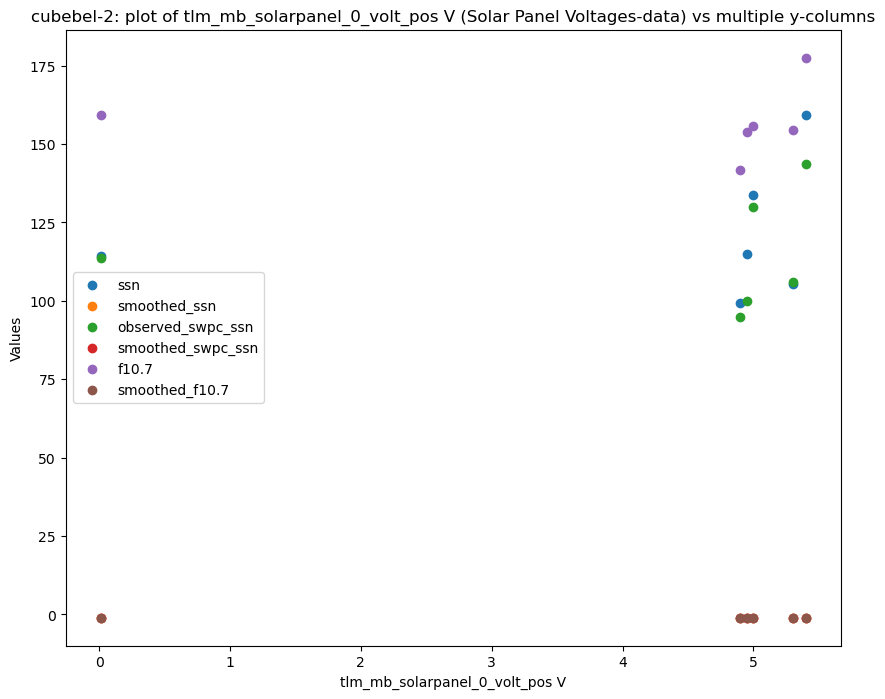

../data/cubebel-2/Solar Panels Current-data-2024-02-11 02 21 58.csv
sampling=[0]
Correlation [57175.distinct A] vs [ssn]: classic=[nan], spearman=[nan], kendal_tau=[nan]
sampling=[0]
Correlation [57175.distinct A] vs [smoothed_ssn]: classic=[nan], spearman=[nan], kendal_tau=[nan]
sampling=[0]
Correlation [57175.distinct A] vs [observed_swpc_ssn]: classic=[nan], spearman=[nan], kendal_tau=[nan]
sampling=[0]
Correlation [57175.distinct A] vs [smoothed_swpc_ssn]: classic=[nan], spearman=[nan], kendal_tau=[nan]
sampling=[0]
Correlation [57175.distinct A] vs [f10.7]: classic=[nan], spearman=[nan], kendal_tau=[nan]
sampling=[0]
Correlation [57175.distinct A] vs [smoothed_f10.7]: classic=[nan], spearman=[nan], kendal_tau=[nan]


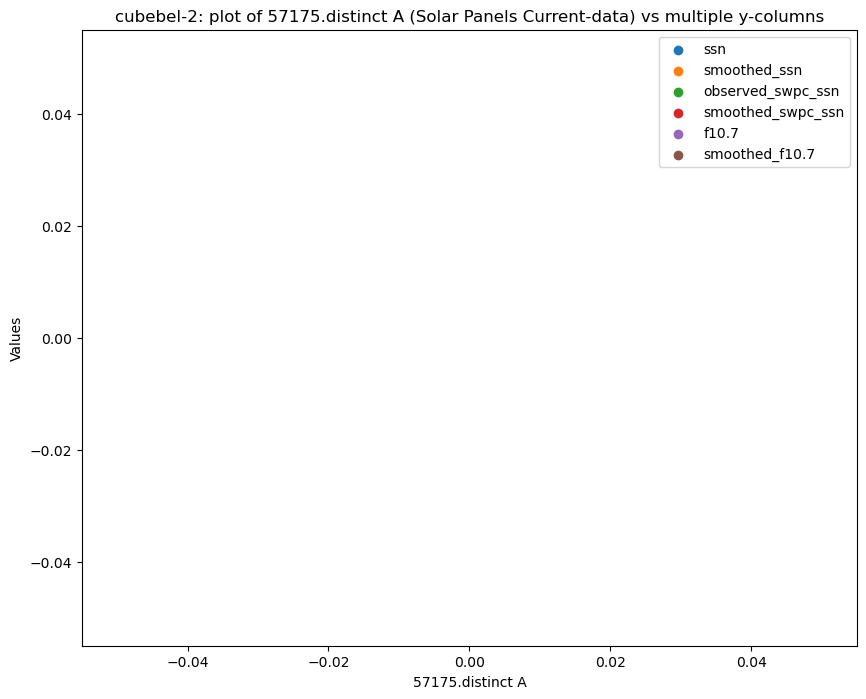

../data/cubebel-2/TRX Primary Current-data-2024-02-11 02 21 54.csv
[TRX Primary Current-data]: skipping column=[57175.distinct A]: not enough unique values.
../data/cubebel-2/TRX Reset Reason-data-2024-02-11 02 22 32.csv
[TRX Reset Reason-data]: skipping column=[last]: not enough unique values.
../data/cubebel-2/TRX Secondary Current-data-2024-02-11 02 21 52.csv
[TRX Secondary Current-data]: skipping column=[57175.distinct A]: not enough unique values.
../data/cubebel-2/TRX Temperature-data-2024-02-11 02 22 07.csv
../data/cubebel-2/TRX Temperatures-data-2024-02-11 02 22 21.csv
../data/cubebel-2/Voltages-data-2024-02-11 02 21 34.csv
sampling=[6]
Correlation [tlm_mb_ant_1_v V] vs [ssn]: classic=[0.140355570358405], spearman=[-0.13093073414159545], kendal_tau=[-0.11547005383792515]
sampling=[6]
Correlation [tlm_mb_ant_1_v V] vs [smoothed_ssn]: classic=[nan], spearman=[nan], kendal_tau=[nan]
sampling=[6]
Correlation [tlm_mb_ant_1_v V] vs [observed_swpc_ssn]: classic=[0.38602859877654977], 

/home/geugenm/anaconda3/envs/course/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


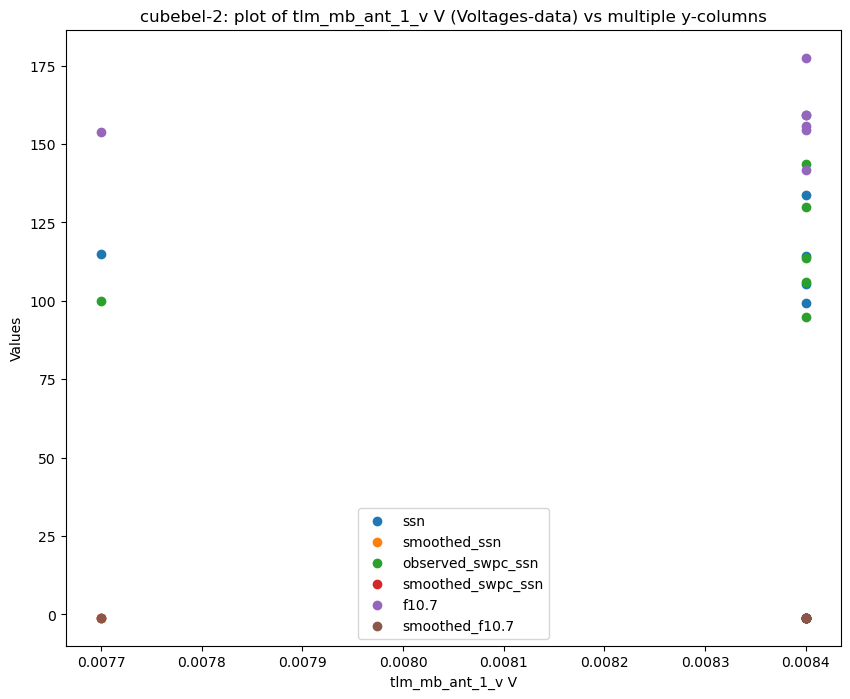

../data/cubebel-2/ADC Temperatures-data-2024-02-11 02 21 40.csv
../data/cubebel-2/Battery 0 Temperature-data-2024-02-11 02 22 13.csv
../data/cubebel-2/Battery 1 Temperature-data-2024-02-11 02 22 10.csv
../data/cubebel-2/Battery Current-data-2024-02-11 02 21 43.csv
../data/cubebel-2/Battery Current-data-2024-02-11 02 22 15.csv
sampling=[0]
Correlation [57175.distinct A] vs [ssn]: classic=[nan], spearman=[nan], kendal_tau=[nan]
sampling=[0]
Correlation [57175.distinct A] vs [smoothed_ssn]: classic=[nan], spearman=[nan], kendal_tau=[nan]
sampling=[0]
Correlation [57175.distinct A] vs [observed_swpc_ssn]: classic=[nan], spearman=[nan], kendal_tau=[nan]
sampling=[0]
Correlation [57175.distinct A] vs [smoothed_swpc_ssn]: classic=[nan], spearman=[nan], kendal_tau=[nan]
sampling=[0]
Correlation [57175.distinct A] vs [f10.7]: classic=[nan], spearman=[nan], kendal_tau=[nan]
sampling=[0]
Correlation [57175.distinct A] vs [smoothed_f10.7]: classic=[nan], spearman=[nan], kendal_tau=[nan]


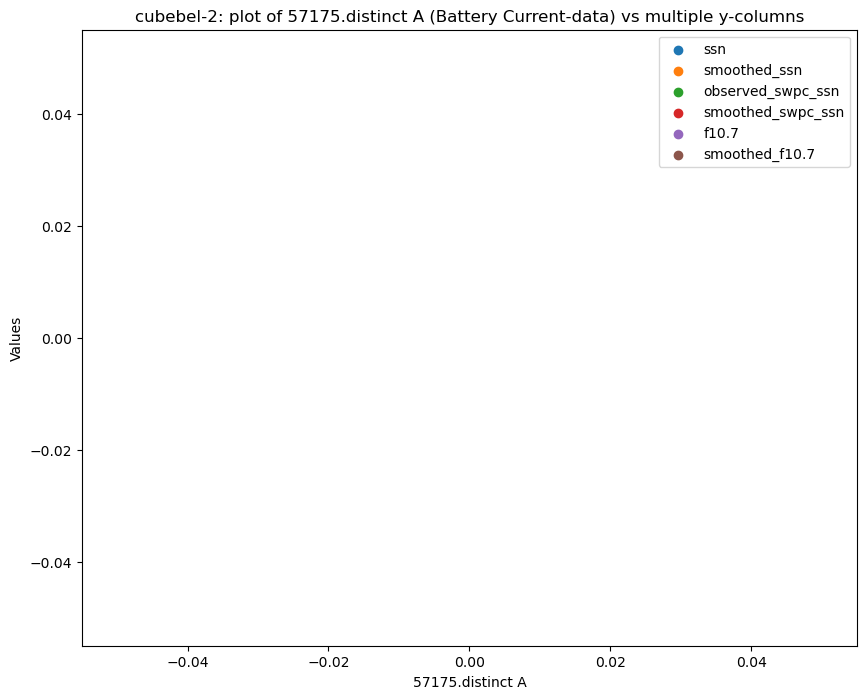

../data/cubebel-2/Battery Voltage-data-2024-02-11 02 21 49.csv
sampling=[0]
Correlation [57175.distinct V] vs [ssn]: classic=[nan], spearman=[nan], kendal_tau=[nan]
sampling=[0]
Correlation [57175.distinct V] vs [smoothed_ssn]: classic=[nan], spearman=[nan], kendal_tau=[nan]
sampling=[0]
Correlation [57175.distinct V] vs [observed_swpc_ssn]: classic=[nan], spearman=[nan], kendal_tau=[nan]
sampling=[0]
Correlation [57175.distinct V] vs [smoothed_swpc_ssn]: classic=[nan], spearman=[nan], kendal_tau=[nan]
sampling=[0]
Correlation [57175.distinct V] vs [f10.7]: classic=[nan], spearman=[nan], kendal_tau=[nan]
sampling=[0]
Correlation [57175.distinct V] vs [smoothed_f10.7]: classic=[nan], spearman=[nan], kendal_tau=[nan]


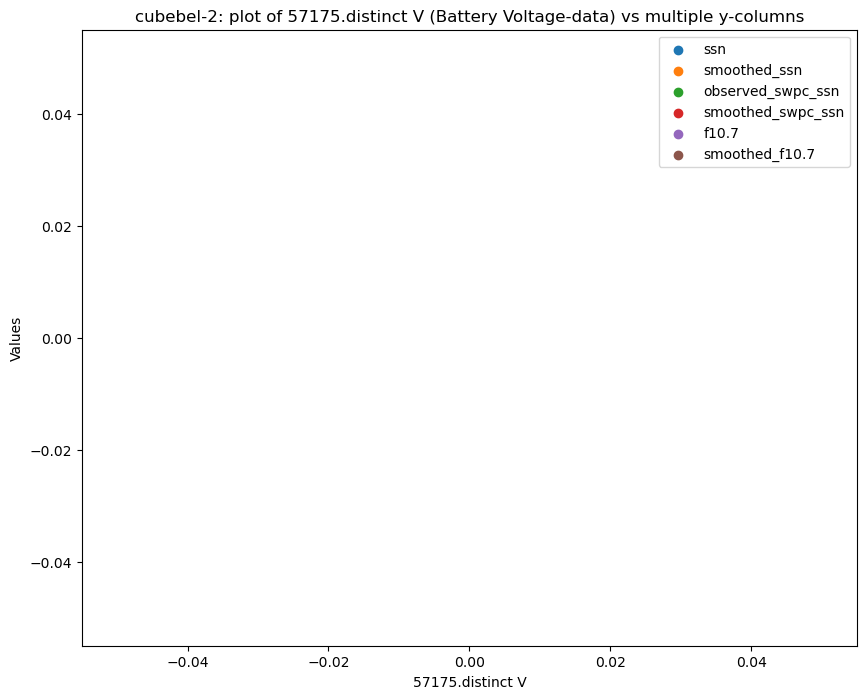

../data/cubebel-2/Digipeater -data-2024-02-11 02 22 48.csv
../data/cubebel-2/Ground Stations Leaderboard By Observed Frames-data-2024-02-11 02 21 28.csv
sampling=[58]
Correlation [9V1KG] vs [ssn]: classic=[0.31810522584528905], spearman=[0.3819690883651904], kendal_tau=[0.30729962227643504]
sampling=[58]
Correlation [9V1KG] vs [smoothed_ssn]: classic=[-0.24497623757694778], spearman=[-0.47666924422368573], kendal_tau=[-0.38739146876531766]
sampling=[58]
Correlation [9V1KG] vs [observed_swpc_ssn]: classic=[0.34216748252558404], spearman=[0.3795796366709941], kendal_tau=[0.310362764329277]
sampling=[58]
Correlation [9V1KG] vs [smoothed_swpc_ssn]: classic=[-0.24972775863602384], spearman=[-0.4766765836375764], kendal_tau=[-0.3875097743013678]
sampling=[58]
Correlation [9V1KG] vs [f10.7]: classic=[0.3700162860124858], spearman=[0.37677031874780836], kendal_tau=[0.309987022346079]
sampling=[58]
Correlation [9V1KG] vs [smoothed_f10.7]: classic=[-0.5478696533089367], spearman=[-0.476838136564

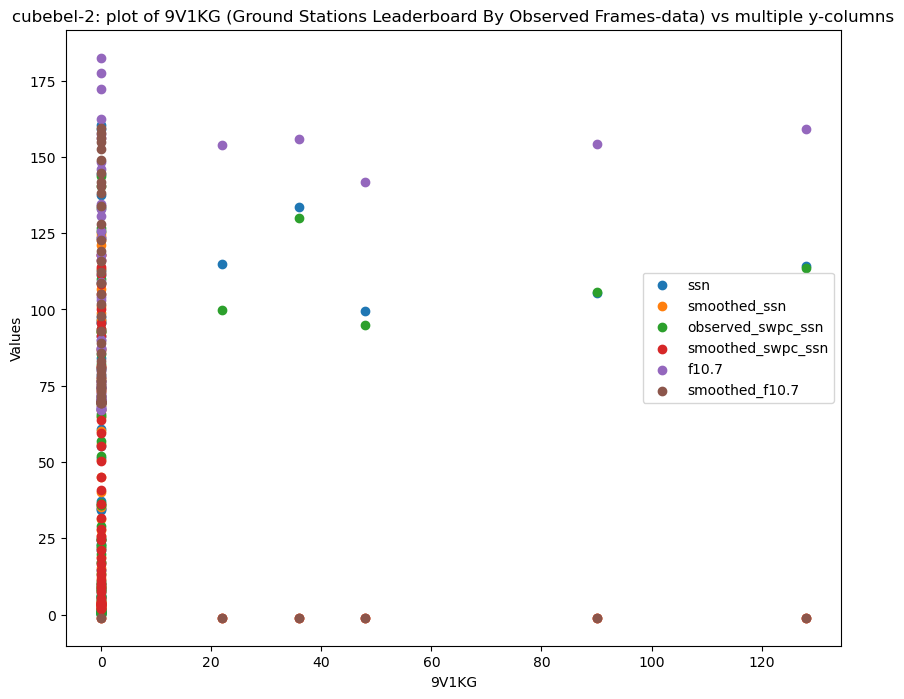

../data/cubebel-2/Last Frame Rcvd By-data-2024-02-11 02 21 23.csv
[Last Frame Rcvd By-data]: skipping column=[observer where 0 is VK5KJP-UHF-PF95gd]: not enough unique values.
../data/cubebel-2/Last Frame Time-data-2024-02-11 02 22 52.csv
[Last Frame Time-data]: skipping column=[57175.ctl]: not enough unique values.
../data/cubebel-2/Last Message-data-2024-02-11 02 22 16.csv


In [47]:
analyze_satellite('cubebel-2')

../data/delfi-pq/Currents-data-2024-02-11 02 21 52.csv
sampling=[22]
Correlation [Current] vs [ssn]: classic=[-0.10636547467560296], spearman=[-0.051973693119368995], kendal_tau=[-0.03201156283555893]
sampling=[22]
Correlation [Current] vs [smoothed_ssn]: classic=[0.02467742594692909], spearman=[0.06633984401018007], kendal_tau=[0.033104420640618]
sampling=[22]
Correlation [Current] vs [observed_swpc_ssn]: classic=[-0.0035346656242519576], spearman=[-0.0051402553634540766], kendal_tau=[-0.0045730804050798475]
sampling=[22]
Correlation [Current] vs [smoothed_swpc_ssn]: classic=[0.023849414128285853], spearman=[0.06633984401018007], kendal_tau=[0.033104420640618]
sampling=[22]
Correlation [Current] vs [f10.7]: classic=[0.06686786010267733], spearman=[-0.03712406651383499], kendal_tau=[-0.01371924121523954]
sampling=[22]
Correlation [Current] vs [smoothed_f10.7]: classic=[0.01187273715644739], spearman=[0.06633984401018007], kendal_tau=[0.033104420640618]


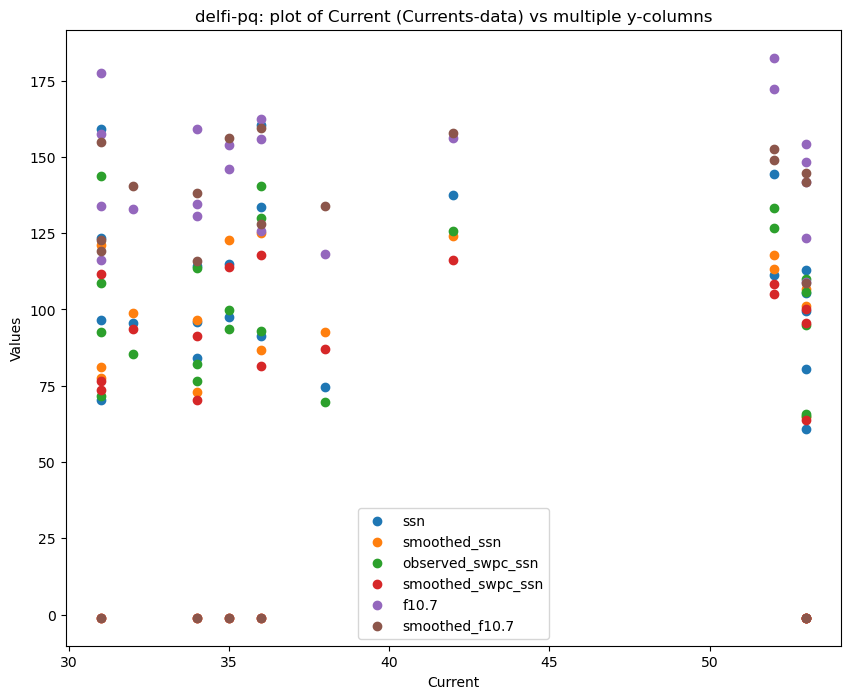

../data/delfi-pq/Last Frame Rcvd By-data-2024-02-11 02 21 45.csv
[Last Frame Rcvd By-data]: skipping column=[observer where 0 is VK4JBE-UHF-QG62mm]: not enough unique values.
../data/delfi-pq/Solar Panel Currents-data-2024-02-11 02 22 09.csv
sampling=[22]
Correlation [Cell Xm] vs [ssn]: classic=[0.08912480840547835], spearman=[0.12554175781660806], kendal_tau=[0.1044465935734187]
sampling=[22]
Correlation [Cell Xm] vs [smoothed_ssn]: classic=[-0.10637348758811188], spearman=[-0.005486581059811363], kendal_tau=[0.01543033499620919]
sampling=[22]
Correlation [Cell Xm] vs [observed_swpc_ssn]: classic=[0.07703644895504451], spearman=[0.08872422307231434], kendal_tau=[0.0646574150692592]
sampling=[22]
Correlation [Cell Xm] vs [smoothed_swpc_ssn]: classic=[-0.10780007264454798], spearman=[-0.005486581059811363], kendal_tau=[0.01543033499620919]
sampling=[22]
Correlation [Cell Xm] vs [f10.7]: classic=[0.1440902087173522], spearman=[0.16054859413085454], kendal_tau=[0.11439388819945859]
sampli

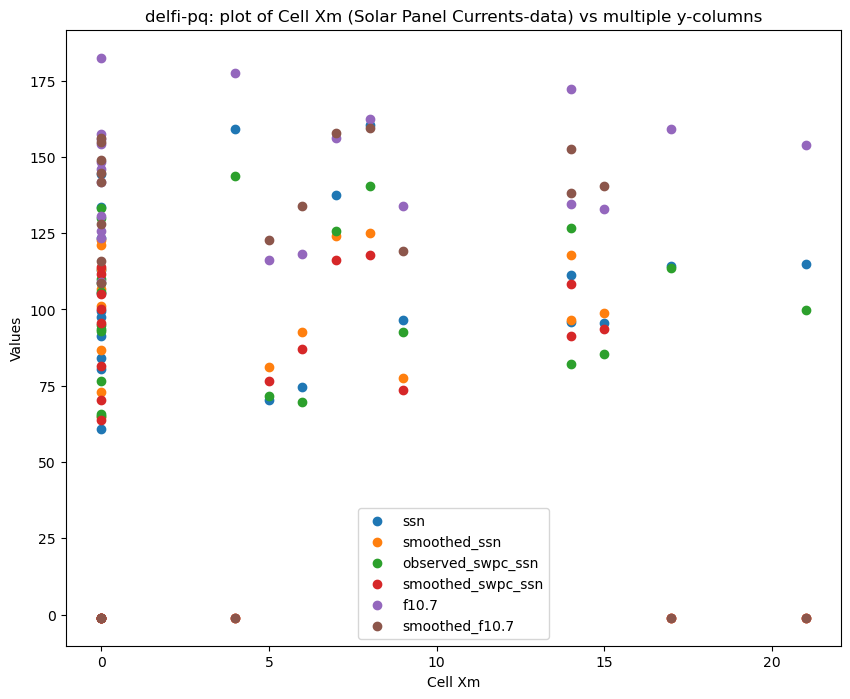

../data/delfi-pq/Solar Panel Voltages-data-2024-02-11 02 22 03.csv
../data/delfi-pq/System Temperatures (C)-data-2024-02-11 02 21 56.csv
sampling=[22]
Correlation [Temp] vs [ssn]: classic=[-0.27636569719344134], spearman=[-0.24526711270652227], kendal_tau=[-0.15686609568480062]
sampling=[22]
Correlation [Temp] vs [smoothed_ssn]: classic=[-0.04910037702776005], spearman=[-0.05279900544635708], kendal_tau=[-0.013518451760896878]
sampling=[22]
Correlation [Temp] vs [observed_swpc_ssn]: classic=[-0.2598202126820129], spearman=[-0.202317111403076], kendal_tau=[-0.11329218021680046]
sampling=[22]
Correlation [Temp] vs [smoothed_swpc_ssn]: classic=[-0.050565783968054584], spearman=[-0.05279900544635708], kendal_tau=[-0.013518451760896878]
sampling=[22]
Correlation [Temp] vs [f10.7]: classic=[-0.09695900590256651], spearman=[-0.1588019785035317], kendal_tau=[-0.11329218021680046]
sampling=[22]
Correlation [Temp] vs [smoothed_f10.7]: classic=[-0.026103901446845233], spearman=[-0.052799005446357

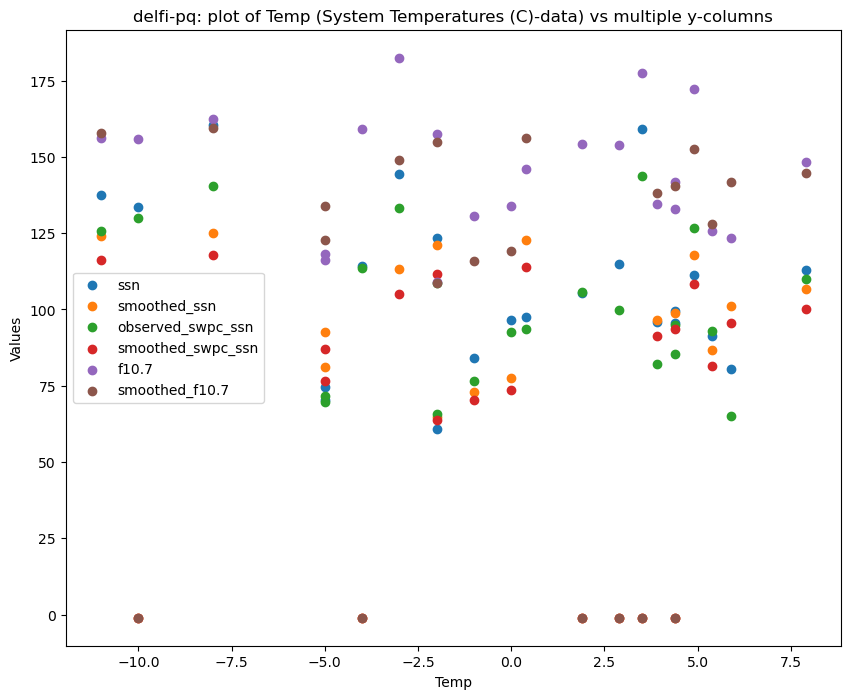

In [48]:
analyze_satellite('delfi-pq')

../data/dhabisat/Altitude-data-2024-02-11 02 22 19.csv
[Altitude-data]: skipping column=[Altitute]: not enough unique values.
../data/dhabisat/ECEF Position-data-2024-02-11 02 22 26.csv
[ECEF Position-data]: skipping column=[ECEF Position X]: not enough unique values.
../data/dhabisat/Estimated Angular Rates-data-2024-02-11 02 21 39.csv
[Estimated Angular Rates-data]: skipping column=[Estimated X Angular Rate]: not enough unique values.
../data/dhabisat/Estimated Quaternions-data-2024-02-11 02 21 45.csv
[Estimated Quaternions-data]: skipping column=[Estimated Q1]: not enough unique values.
../data/dhabisat/Estimated Roll_Pitch_Yaw-data-2024-02-11 02 21 49.csv
[Estimated Roll_Pitch_Yaw-data]: skipping column=[Estimated Roll Angle]: not enough unique values.
../data/dhabisat/Latitude _ Longitude-data-2024-02-11 02 22 08.csv
sampling=[27]
Correlation [Latitude] vs [ssn]: classic=[-0.10369377302834588], spearman=[-0.15107392400953318], kendal_tau=[-0.12561485860426555]
sampling=[27]
Correl

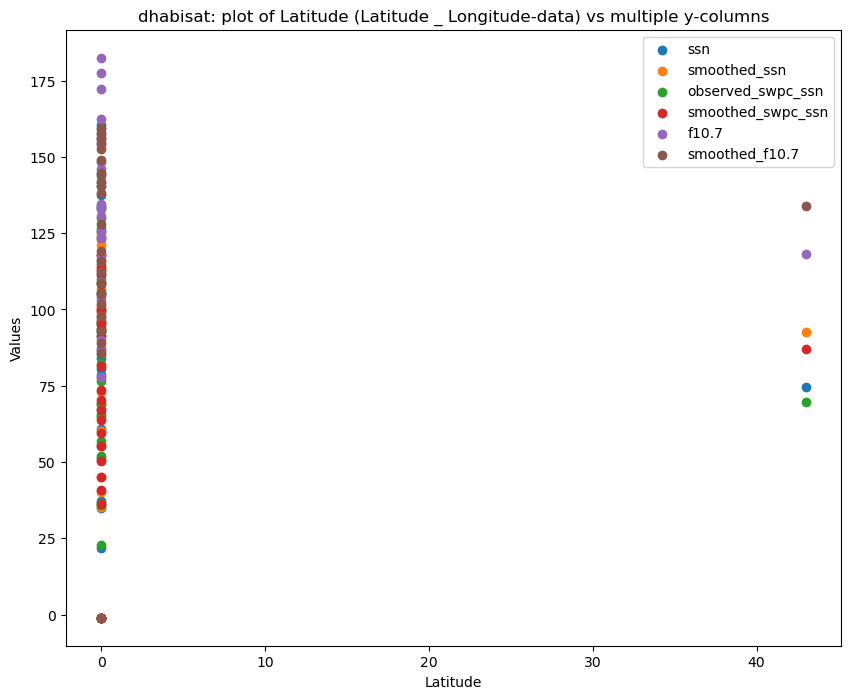

../data/dhabisat/Position-data-2024-02-11 02 22 03.csv
sampling=[27]
Correlation [X Position] vs [ssn]: classic=[0.10369377302834593], spearman=[0.15107392400953318], kendal_tau=[0.12561485860426555]
sampling=[27]
Correlation [X Position] vs [smoothed_ssn]: classic=[-0.10724425266955787], spearman=[-0.07576859996648176], kendal_tau=[-0.06372170488427707]
sampling=[27]
Correlation [X Position] vs [observed_swpc_ssn]: classic=[0.1129872014769778], spearman=[0.1007159493396888], kendal_tau=[0.08374323906951038]
sampling=[27]
Correlation [X Position] vs [smoothed_swpc_ssn]: classic=[-0.10565663889524639], spearman=[-0.07576859996648176], kendal_tau=[-0.06372170488427707]
sampling=[27]
Correlation [X Position] vs [f10.7]: classic=[0.10050364443362488], spearman=[0.125894936674611], kendal_tau=[0.10467904883688797]
sampling=[27]
Correlation [X Position] vs [smoothed_f10.7]: classic=[-0.11185203549848571], spearman=[-0.07576859996648176], kendal_tau=[-0.06372170488427707]


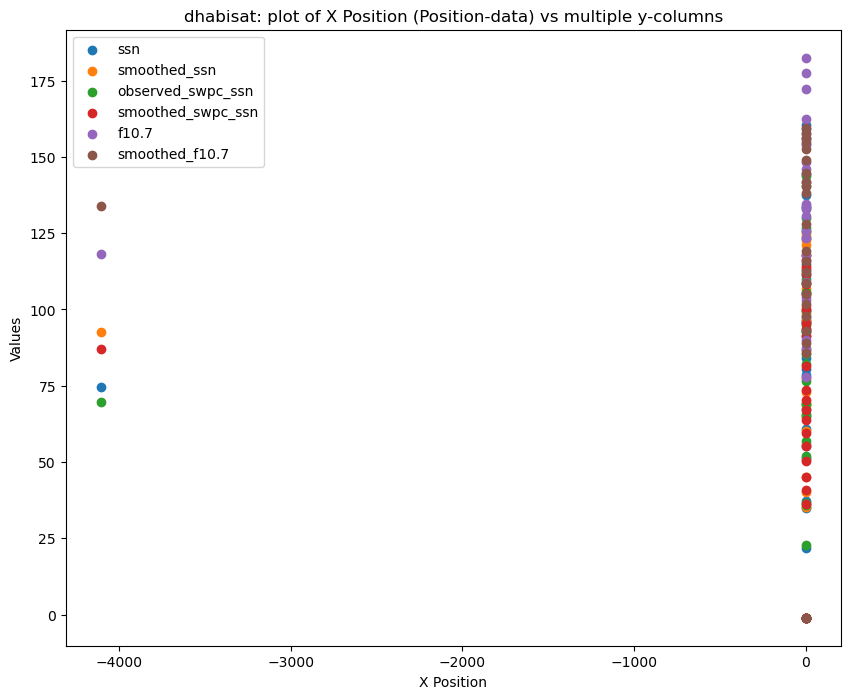

../data/dhabisat/Power-data-2024-02-11 02 21 51.csv
../data/dhabisat/Velocity-data-2024-02-11 02 22 12.csv
sampling=[27]
Correlation [X Velocity] vs [ssn]: classic=[-0.10369377302834586], spearman=[-0.15107392400953318], kendal_tau=[-0.12561485860426555]
sampling=[27]
Correlation [X Velocity] vs [smoothed_ssn]: classic=[0.10724425266955787], spearman=[0.07576859996648176], kendal_tau=[0.06372170488427707]
sampling=[27]
Correlation [X Velocity] vs [observed_swpc_ssn]: classic=[-0.1129872014769778], spearman=[-0.1007159493396888], kendal_tau=[-0.08374323906951038]
sampling=[27]
Correlation [X Velocity] vs [smoothed_swpc_ssn]: classic=[0.10565663889524642], spearman=[0.07576859996648176], kendal_tau=[0.06372170488427707]
sampling=[27]
Correlation [X Velocity] vs [f10.7]: classic=[-0.10050364443362486], spearman=[-0.125894936674611], kendal_tau=[-0.10467904883688797]
sampling=[27]
Correlation [X Velocity] vs [smoothed_f10.7]: classic=[0.11185203549848566], spearman=[0.07576859996648176], k

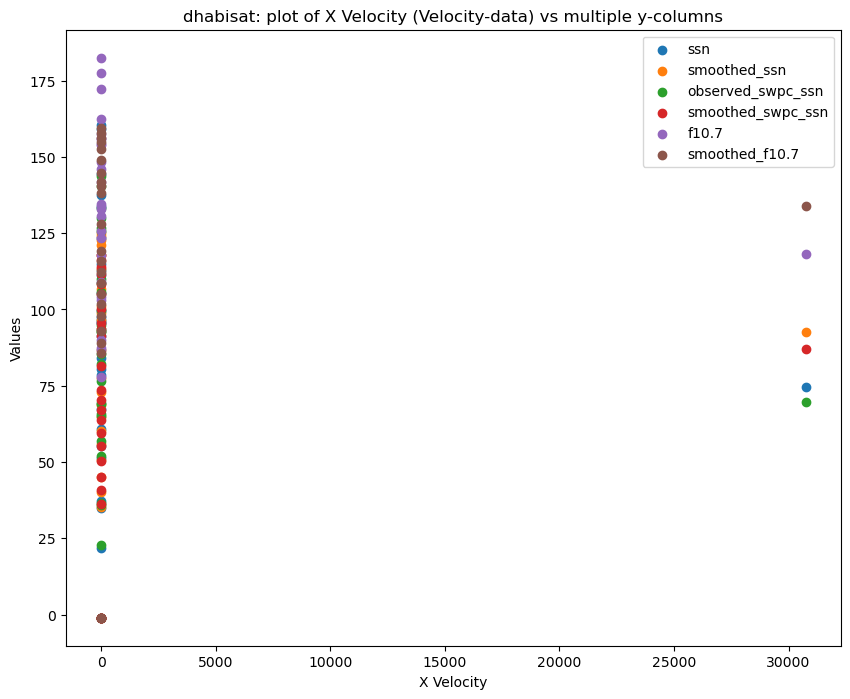

../data/dhabisat/Wheel Speeds-data-2024-02-11 02 21 57.csv
[Wheel Speeds-data]: skipping column=[X Wheel Speed]: not enough unique values.


In [49]:
analyze_satellite('dhabisat')

../data/geoscan-edelveis/-data-2024-02-11 02 21 37.csv
sampling=[13]
Correlation [Batteries Voltage.1 V] vs [ssn]: classic=[0.017070695072106647], spearman=[-0.253444487872598], kendal_tau=[-0.12988108336653276]
sampling=[13]
Correlation [Batteries Voltage.1 V] vs [smoothed_ssn]: classic=[-0.5354710820701724], spearman=[-0.0202836358813121], kendal_tau=[-0.10116282977781398]
sampling=[13]
Correlation [Batteries Voltage.1 V] vs [observed_swpc_ssn]: classic=[-0.11146261484583289], spearman=[-0.3057862842810693], kendal_tau=[-0.2078097333864524]
sampling=[13]
Correlation [Batteries Voltage.1 V] vs [smoothed_swpc_ssn]: classic=[-0.5291059155735648], spearman=[-0.0202836358813121], kendal_tau=[-0.10116282977781398]
sampling=[13]
Correlation [Batteries Voltage.1 V] vs [f10.7]: classic=[-0.3823826927139748], spearman=[-0.4986244815754373], kendal_tau=[-0.3376908167529852]
sampling=[13]
Correlation [Batteries Voltage.1 V] vs [smoothed_f10.7]: classic=[-0.552869435478098], spearman=[-0.02028363

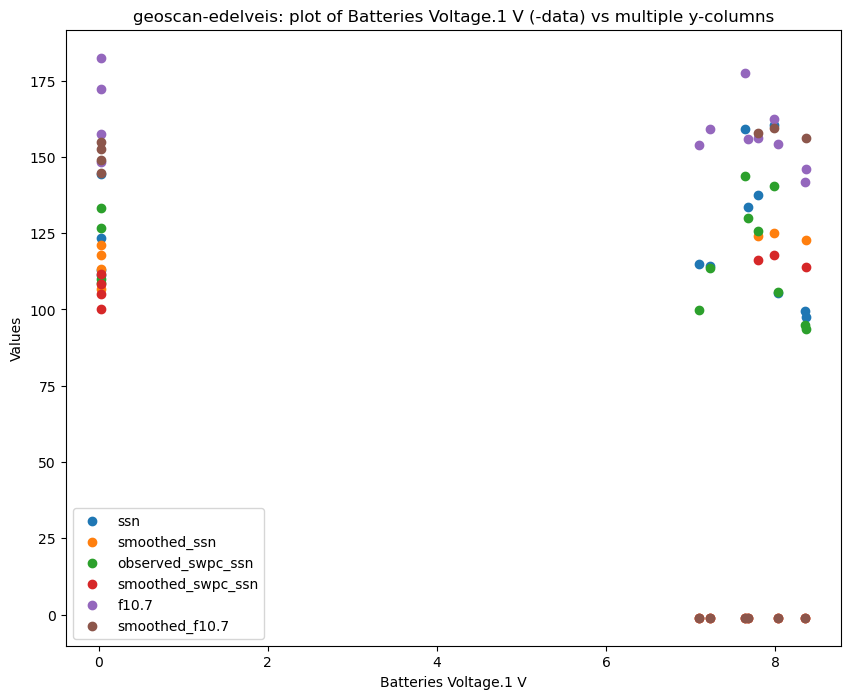

../data/geoscan-edelveis/Callsign-data-2024-02-11 02 21 40.csv
../data/geoscan-edelveis/Msg Type-data-2024-02-11 02 21 43.csv
../data/geoscan-edelveis/Voltage of all Batteries-data-2024-02-11 02 21 34.csv
sampling=[4]
Correlation [Battery Voltage V] vs [ssn]: classic=[0.323928276909371], spearman=[0.21081851067789195], kendal_tau=[0.18257418583505539]
sampling=[4]
Correlation [Battery Voltage V] vs [smoothed_ssn]: classic=[-0.899875706297703], spearman=[-0.9486832980505139], kendal_tau=[-0.912870929175277]
sampling=[4]
Correlation [Battery Voltage V] vs [observed_swpc_ssn]: classic=[0.34689004182392175], spearman=[0.632455532033676], kendal_tau=[0.5477225575051662]
sampling=[4]
Correlation [Battery Voltage V] vs [smoothed_swpc_ssn]: classic=[-0.9113358978675945], spearman=[-0.9486832980505139], kendal_tau=[-0.912870929175277]
sampling=[4]
Correlation [Battery Voltage V] vs [f10.7]: classic=[0.13116566847146183], spearman=[0.10540925533894598], kendal_tau=[0.18257418583505539]
sampling=

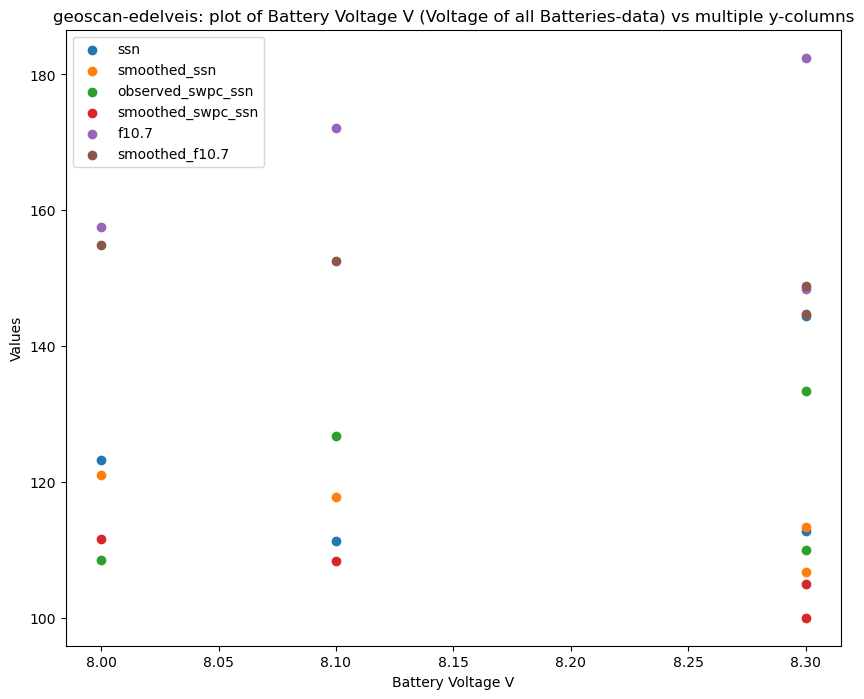

In [50]:
analyze_satellite('geoscan-edelveis')

../data/grbalpha/COM MCU temperature in °C-data-2024-02-11 02 23 54.csv
sampling=[29]
Correlation [47959.temp_cpu] vs [ssn]: classic=[0.09259486078941945], spearman=[0.0645906220777487], kendal_tau=[0.036121365268923046]
sampling=[29]
Correlation [47959.temp_cpu] vs [smoothed_ssn]: classic=[0.3753061831168916], spearman=[0.30370174581428766], kendal_tau=[0.22874510776041598]
sampling=[29]
Correlation [47959.temp_cpu] vs [observed_swpc_ssn]: classic=[0.10012255844003523], spearman=[0.06136109097386126], kendal_tau=[0.025800975192087888]
sampling=[29]
Correlation [47959.temp_cpu] vs [smoothed_swpc_ssn]: classic=[0.38280686054577023], spearman=[0.30370174581428766], kendal_tau=[0.22874510776041598]
sampling=[29]
Correlation [47959.temp_cpu] vs [f10.7]: classic=[0.16585224510280244], spearman=[0.13489502995468286], kendal_tau=[0.08772331565309882]
sampling=[29]
Correlation [47959.temp_cpu] vs [smoothed_f10.7]: classic=[0.35887169505717725], spearman=[0.30370174581428766], kendal_tau=[0.228

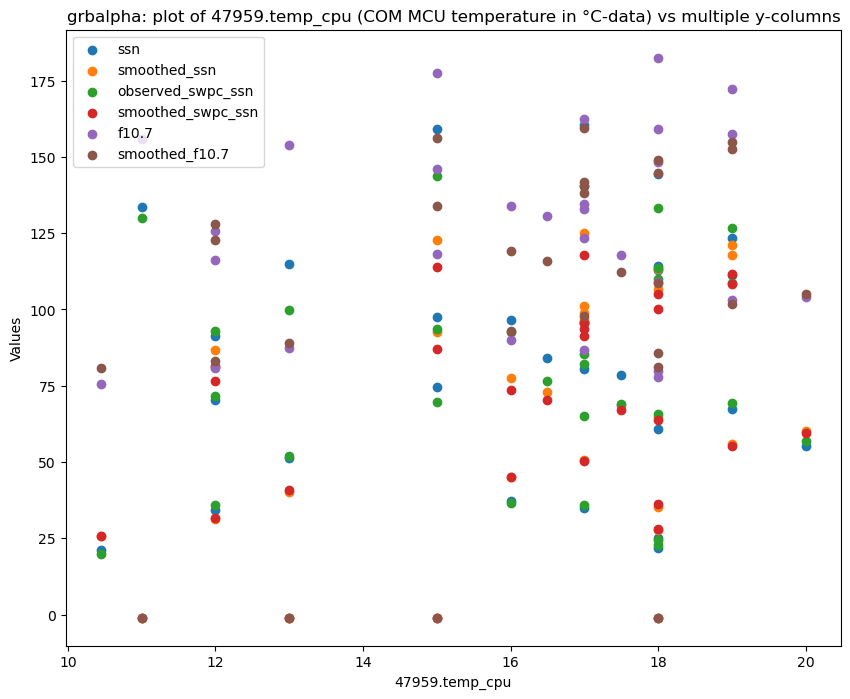

../data/grbalpha/COM RF received-data-2024-02-11 02 23 14.csv
sampling=[29]
Correlation [47959.rf_packets_received] vs [ssn]: classic=[0.9019675656287149], spearman=[0.9379310344827584], kendal_tau=[0.7832512315270934]
sampling=[29]
Correlation [47959.rf_packets_received] vs [smoothed_ssn]: classic=[0.26017962356700935], spearman=[0.2836007088118036], kendal_tau=[0.49629166698546506]
sampling=[29]
Correlation [47959.rf_packets_received] vs [observed_swpc_ssn]: classic=[0.8867017190887666], spearman=[0.9147783251231526], kendal_tau=[0.7536945812807881]
sampling=[29]
Correlation [47959.rf_packets_received] vs [smoothed_swpc_ssn]: classic=[0.22907623748037279], spearman=[0.2836007088118036], kendal_tau=[0.49629166698546506]
sampling=[29]
Correlation [47959.rf_packets_received] vs [f10.7]: classic=[0.9251766627128033], spearman=[0.9310344827586206], kendal_tau=[0.7881773399014778]
sampling=[29]
Correlation [47959.rf_packets_received] vs [smoothed_f10.7]: classic=[-0.03648651192292097], spe

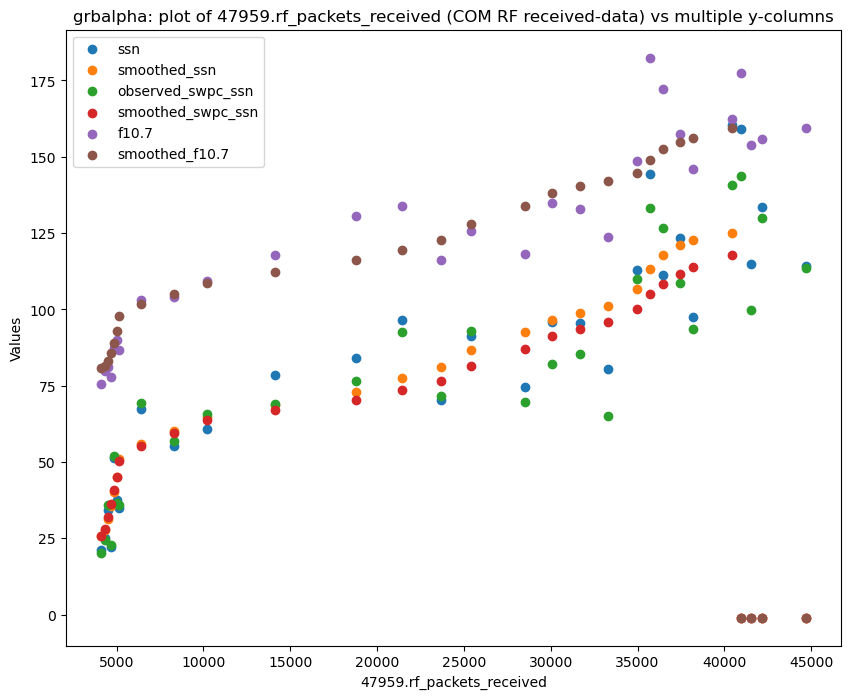

../data/grbalpha/COM RF transmitted-data-2024-02-11 02 23 35.csv
sampling=[29]
Correlation [47959.rf_packets_transmitted] vs [ssn]: classic=[0.8823680408791995], spearman=[0.9379310344827584], kendal_tau=[0.7832512315270934]
sampling=[29]
Correlation [47959.rf_packets_transmitted] vs [smoothed_ssn]: classic=[0.059923303021410156], spearman=[0.2836007088118036], kendal_tau=[0.49629166698546506]
sampling=[29]
Correlation [47959.rf_packets_transmitted] vs [observed_swpc_ssn]: classic=[0.875579336617946], spearman=[0.9147783251231526], kendal_tau=[0.7536945812807881]
sampling=[29]
Correlation [47959.rf_packets_transmitted] vs [smoothed_swpc_ssn]: classic=[0.030471171864227462], spearman=[0.2836007088118036], kendal_tau=[0.49629166698546506]
sampling=[29]
Correlation [47959.rf_packets_transmitted] vs [f10.7]: classic=[0.8939719487916132], spearman=[0.9310344827586206], kendal_tau=[0.7881773399014778]
sampling=[29]
Correlation [47959.rf_packets_transmitted] vs [smoothed_f10.7]: classic=[-0.2

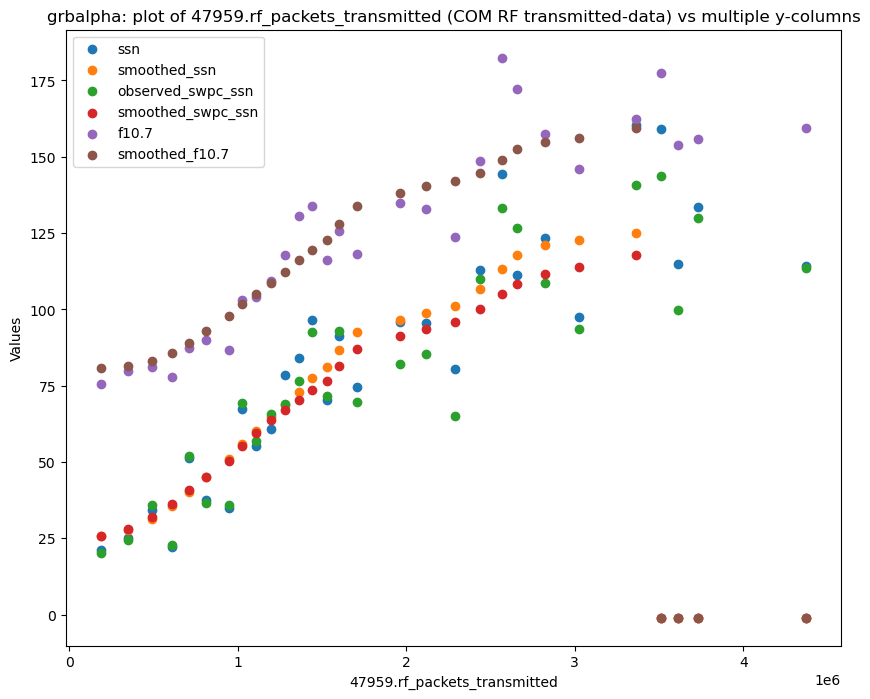

../data/grbalpha/Frame count-data-2024-02-11 02 24 54.csv
[Frame count-data]: skipping column=[47959.count]: not enough unique values.
../data/grbalpha/OBC 9DOF temperature in °C-data-2024-02-11 02 25 27.csv
sampling=[32]
Correlation [47959.obc_mpu_temp] vs [ssn]: classic=[-0.27465606372936485], spearman=[-0.1893593072733452], kendal_tau=[-0.11046141125320413]
sampling=[32]
Correlation [47959.obc_mpu_temp] vs [smoothed_ssn]: classic=[-0.14543960203474982], spearman=[-0.18455596920162698], kendal_tau=[-0.13842324408660656]
sampling=[32]
Correlation [47959.obc_mpu_temp] vs [observed_swpc_ssn]: classic=[-0.31163194438611486], spearman=[-0.24685389487032985], kendal_tau=[-0.15746626710563144]
sampling=[32]
Correlation [47959.obc_mpu_temp] vs [smoothed_swpc_ssn]: classic=[-0.14423492566653676], spearman=[-0.18455596920162698], kendal_tau=[-0.13842324408660656]
sampling=[32]
Correlation [47959.obc_mpu_temp] vs [f10.7]: classic=[-0.22080833405351377], spearman=[-0.13873267382617105], kendal_t

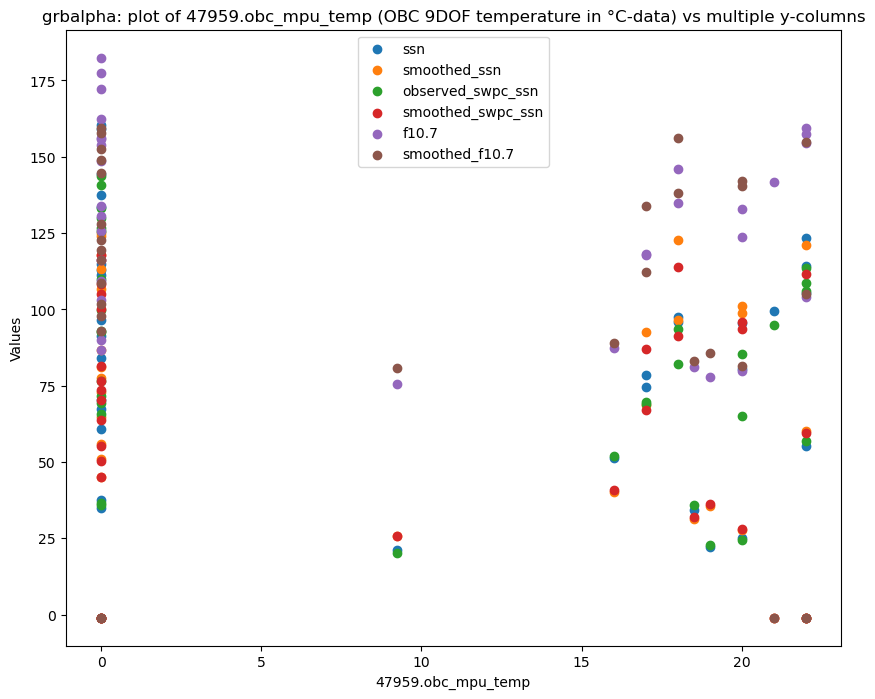

../data/grbalpha/OBC MCU temperature in °C-data-2024-02-11 02 25 11.csv
sampling=[32]
Correlation [47959.obc_temp] vs [ssn]: classic=[0.06985208574530317], spearman=[0.05451371863940879], kendal_tau=[0.061866464294918905]
sampling=[32]
Correlation [47959.obc_temp] vs [smoothed_ssn]: classic=[0.09106428676183913], spearman=[0.018322814532245386], kendal_tau=[0.03249502367789938]
sampling=[32]
Correlation [47959.obc_temp] vs [observed_swpc_ssn]: classic=[0.09981707652670432], spearman=[0.06860570032850767], kendal_tau=[0.057599811584924505]
sampling=[32]
Correlation [47959.obc_temp] vs [smoothed_swpc_ssn]: classic=[0.0926711605062941], spearman=[0.018322814532245386], kendal_tau=[0.03249502367789938]
sampling=[32]
Correlation [47959.obc_temp] vs [f10.7]: classic=[0.15814862405252053], spearman=[0.12923830575397255], kendal_tau=[0.10879964410485737]
sampling=[32]
Correlation [47959.obc_temp] vs [smoothed_f10.7]: classic=[0.04141234083064056], spearman=[0.018322814532245386], kendal_tau=[0

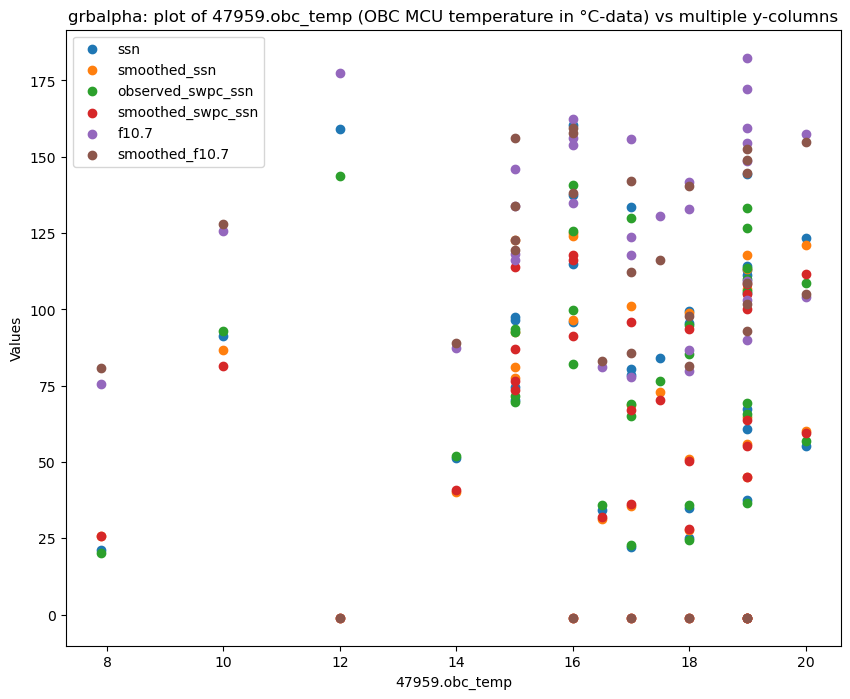

../data/grbalpha/OBC Uptime total-data-2024-02-11 02 26 28.csv
sampling=[32]
Correlation [47959.obc_uptime_total] vs [ssn]: classic=[0.8707802879608515], spearman=[0.9017595307917888], kendal_tau=[0.7338709677419355]
sampling=[32]
Correlation [47959.obc_uptime_total] vs [smoothed_ssn]: classic=[0.0037096205470402155], spearman=[0.07888245306604844], kendal_tau=[0.345997792676562]
sampling=[32]
Correlation [47959.obc_uptime_total] vs [observed_swpc_ssn]: classic=[0.8730399139760318], spearman=[0.8859970674486803], kendal_tau=[0.713709677419355]
sampling=[32]
Correlation [47959.obc_uptime_total] vs [smoothed_swpc_ssn]: classic=[-0.025015039242139166], spearman=[0.07888245306604844], kendal_tau=[0.345997792676562]
sampling=[32]
Correlation [47959.obc_uptime_total] vs [f10.7]: classic=[0.9012405983611873], spearman=[0.8995601173020527], kendal_tau=[0.7379032258064517]
sampling=[32]
Correlation [47959.obc_uptime_total] vs [smoothed_f10.7]: classic=[-0.2821585890559032], spearman=[0.07888245

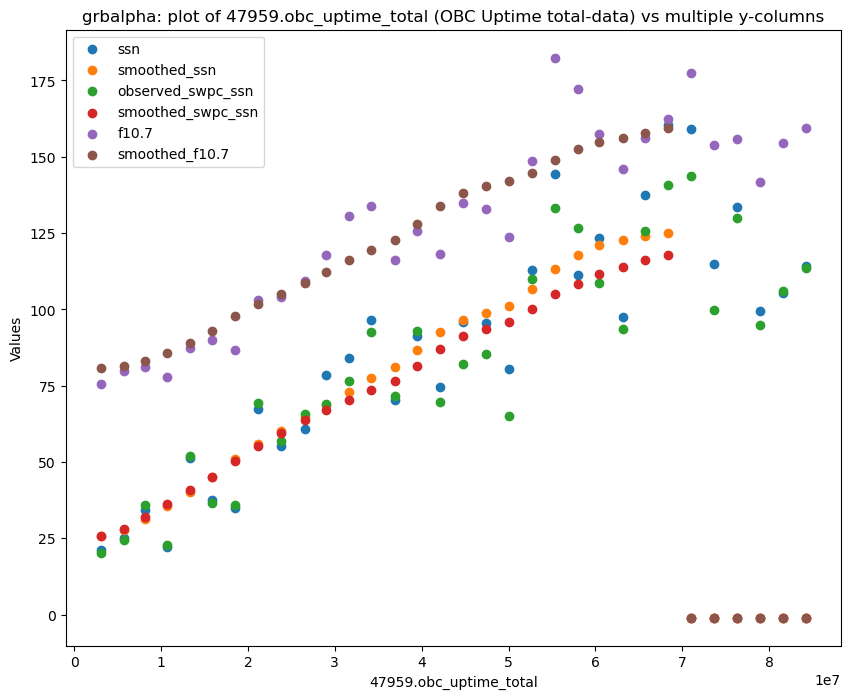

In [51]:
analyze_satellite('grbalpha')

../data/ledsat/Battery Current-data-2024-02-11 02 19 26.csv
sampling=[16]
Correlation [Total current coming from solar panels] vs [ssn]: classic=[0.1455661963266093], spearman=[-0.13981241472851114], kendal_tau=[-0.11504474832710555]
sampling=[16]
Correlation [Total current coming from solar panels] vs [smoothed_ssn]: classic=[0.4365697753606787], spearman=[0.08744708218731291], kendal_tau=[0.0641817324223507]
sampling=[16]
Correlation [Total current coming from solar panels] vs [observed_swpc_ssn]: classic=[0.154569530990416], spearman=[-0.08155724192496482], kendal_tau=[-0.0639137490706142]
sampling=[16]
Correlation [Total current coming from solar panels] vs [smoothed_swpc_ssn]: classic=[0.42315214446643307], spearman=[0.08744708218731291], kendal_tau=[0.0641817324223507]
sampling=[16]
Correlation [Total current coming from solar panels] vs [f10.7]: classic=[0.20944850444231614], spearman=[-0.13204505835470495], kendal_tau=[-0.11504474832710555]
sampling=[16]
Correlation [Total curr

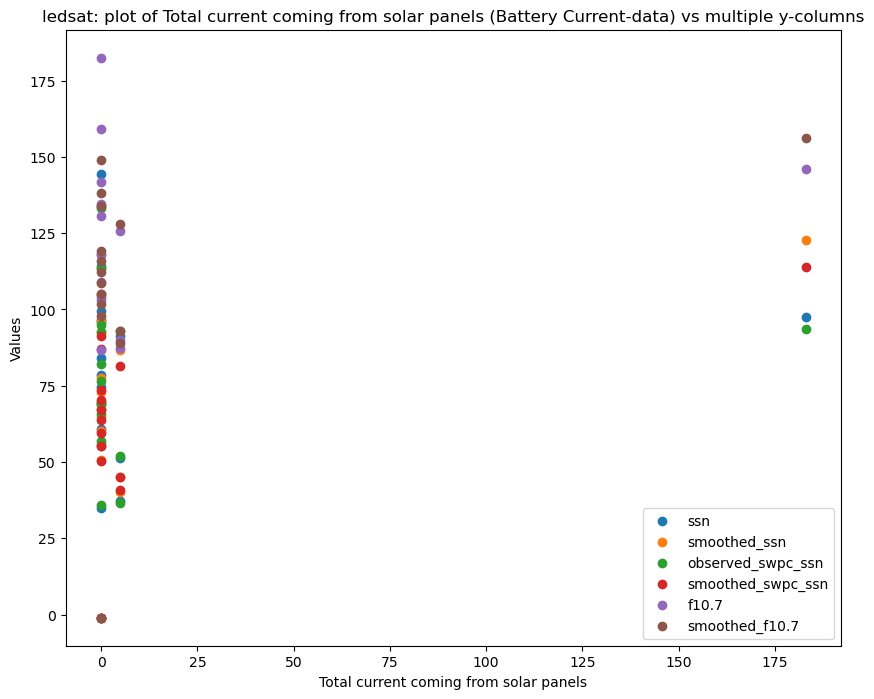

../data/ledsat/Battery Current-data-2024-02-11 02 21 49.csv
sampling=[16]
Correlation [Total current coming from solar panels] vs [ssn]: classic=[0.1455661963266093], spearman=[-0.13981241472851114], kendal_tau=[-0.11504474832710555]
sampling=[16]
Correlation [Total current coming from solar panels] vs [smoothed_ssn]: classic=[0.4365697753606787], spearman=[0.08744708218731291], kendal_tau=[0.0641817324223507]
sampling=[16]
Correlation [Total current coming from solar panels] vs [observed_swpc_ssn]: classic=[0.154569530990416], spearman=[-0.08155724192496482], kendal_tau=[-0.0639137490706142]
sampling=[16]
Correlation [Total current coming from solar panels] vs [smoothed_swpc_ssn]: classic=[0.42315214446643307], spearman=[0.08744708218731291], kendal_tau=[0.0641817324223507]
sampling=[16]
Correlation [Total current coming from solar panels] vs [f10.7]: classic=[0.20944850444231614], spearman=[-0.13204505835470495], kendal_tau=[-0.11504474832710555]
sampling=[16]
Correlation [Total curr

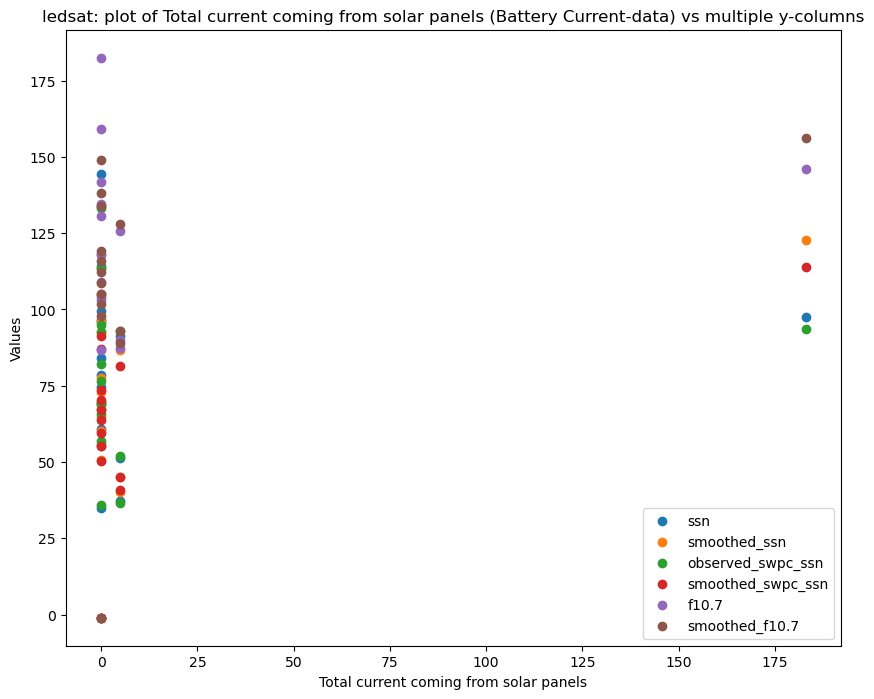

../data/ledsat/Battery Voltage-data-2024-02-11 02 19 06.csv
sampling=[1]
Correlation [49069.mode V] vs [ssn]: classic=[nan], spearman=[nan], kendal_tau=[nan]
sampling=[1]
Correlation [49069.mode V] vs [smoothed_ssn]: classic=[nan], spearman=[nan], kendal_tau=[nan]
sampling=[1]
Correlation [49069.mode V] vs [observed_swpc_ssn]: classic=[nan], spearman=[nan], kendal_tau=[nan]
sampling=[1]
Correlation [49069.mode V] vs [smoothed_swpc_ssn]: classic=[nan], spearman=[nan], kendal_tau=[nan]
sampling=[1]
Correlation [49069.mode V] vs [f10.7]: classic=[nan], spearman=[nan], kendal_tau=[nan]
sampling=[1]
Correlation [49069.mode V] vs [smoothed_f10.7]: classic=[nan], spearman=[nan], kendal_tau=[nan]


/home/geugenm/anaconda3/envs/course/lib/python3.8/site-packages/numpy/lib/function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/geugenm/anaconda3/envs/course/lib/python3.8/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)


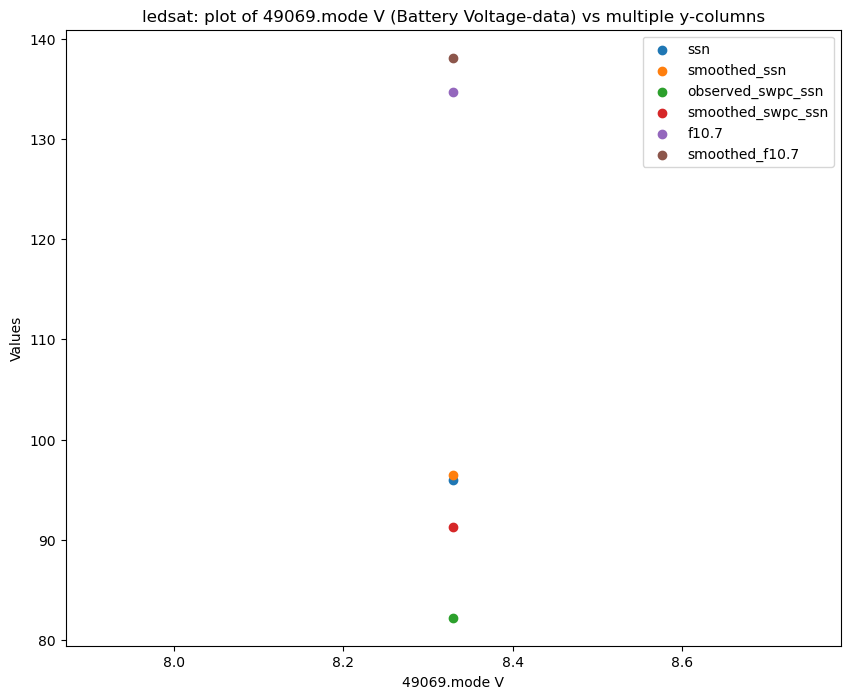

../data/ledsat/Battery Voltage-data-2024-02-11 02 21 33.csv


/home/geugenm/anaconda3/envs/course/lib/python3.8/site-packages/numpy/lib/function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/geugenm/anaconda3/envs/course/lib/python3.8/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)


sampling=[1]
Correlation [49069.mode V] vs [ssn]: classic=[nan], spearman=[nan], kendal_tau=[nan]
sampling=[1]
Correlation [49069.mode V] vs [smoothed_ssn]: classic=[nan], spearman=[nan], kendal_tau=[nan]
sampling=[1]
Correlation [49069.mode V] vs [observed_swpc_ssn]: classic=[nan], spearman=[nan], kendal_tau=[nan]
sampling=[1]
Correlation [49069.mode V] vs [smoothed_swpc_ssn]: classic=[nan], spearman=[nan], kendal_tau=[nan]
sampling=[1]
Correlation [49069.mode V] vs [f10.7]: classic=[nan], spearman=[nan], kendal_tau=[nan]
sampling=[1]
Correlation [49069.mode V] vs [smoothed_f10.7]: classic=[nan], spearman=[nan], kendal_tau=[nan]


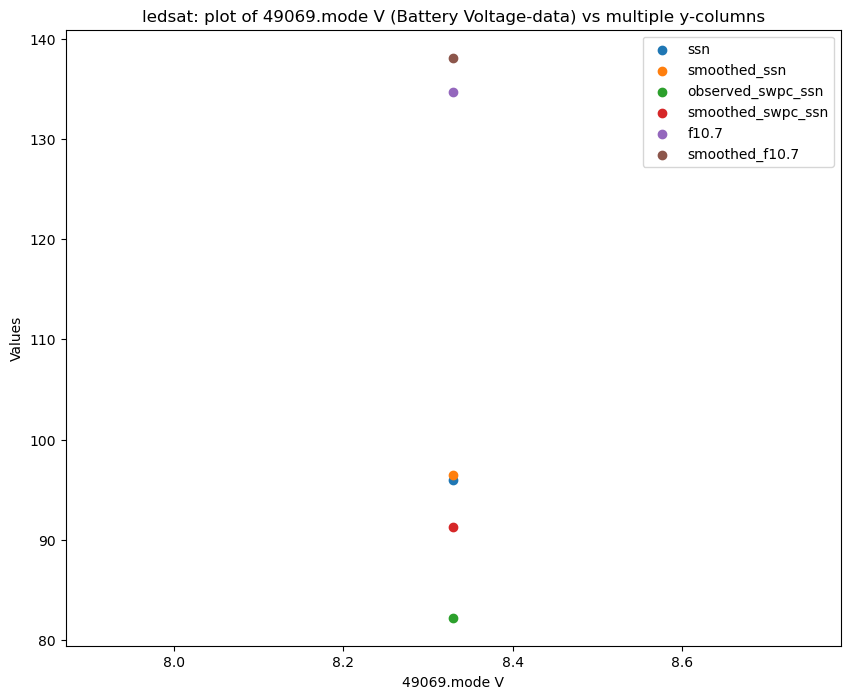

../data/ledsat/Ground Stations Leaderboard By Observed Frames-data-2024-02-11 02 18 48.csv
[Ground Stations Leaderboard By Observed Frames-data]: skipping column=[-----OE6EUR15-----]: not enough unique values.
../data/ledsat/Last Frame Rcvd By-data-2024-02-11 02 19 24.csv
../data/ledsat/Last Frame Rcvd By-data-2024-02-11 02 21 47.csv
../data/ledsat/Solar Panel Temperatures-data-2024-02-11 02 19 39.csv
sampling=[16]
Correlation [+X solar panel] vs [ssn]: classic=[0.007204427101447014], spearman=[-0.10448862284268369], kendal_tau=[-0.07531446678801507]
sampling=[16]
Correlation [+X solar panel] vs [smoothed_ssn]: classic=[0.10964154719047822], spearman=[0.09278350515463918], kendal_tau=[0.08403361344537816]
sampling=[16]
Correlation [+X solar panel] vs [observed_swpc_ssn]: classic=[0.08157547500500283], spearman=[-0.010301695209842055], kendal_tau=[-0.04184137043778616]
sampling=[16]
Correlation [+X solar panel] vs [smoothed_swpc_ssn]: classic=[0.10740117132298072], spearman=[0.092783505

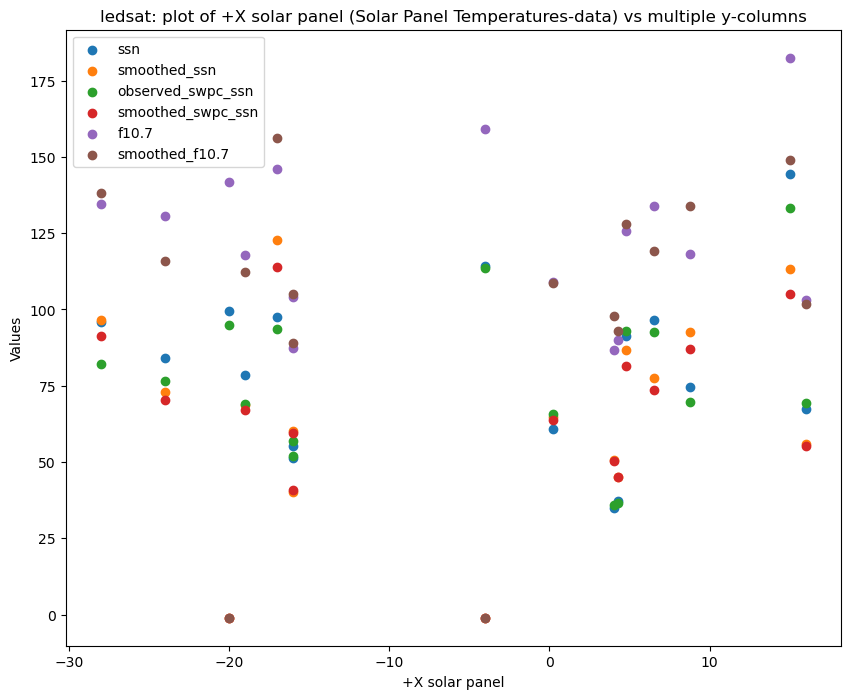

../data/ledsat/Solar Panel Temperatures-data-2024-02-11 02 22 03.csv
sampling=[16]
Correlation [+X solar panel] vs [ssn]: classic=[0.007204427101447014], spearman=[-0.10448862284268369], kendal_tau=[-0.07531446678801507]
sampling=[16]
Correlation [+X solar panel] vs [smoothed_ssn]: classic=[0.10964154719047822], spearman=[0.09278350515463918], kendal_tau=[0.08403361344537816]
sampling=[16]
Correlation [+X solar panel] vs [observed_swpc_ssn]: classic=[0.08157547500500283], spearman=[-0.010301695209842055], kendal_tau=[-0.04184137043778616]
sampling=[16]
Correlation [+X solar panel] vs [smoothed_swpc_ssn]: classic=[0.10740117132298072], spearman=[0.09278350515463918], kendal_tau=[0.08403361344537816]
sampling=[16]
Correlation [+X solar panel] vs [f10.7]: classic=[-0.019138165242853916], spearman=[-0.16924213559026233], kendal_tau=[-0.09205101496312953]
sampling=[16]
Correlation [+X solar panel] vs [smoothed_f10.7]: classic=[0.14380745426262864], spearman=[0.09278350515463918], kendal_tau

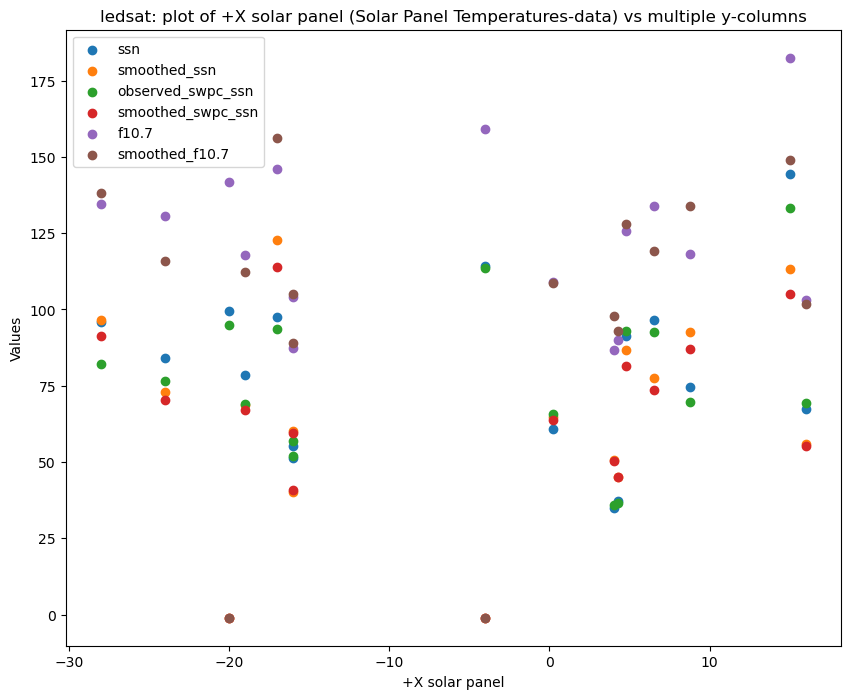

../data/ledsat/System Temperatures (C)-data-2024-02-11 02 19 34.csv
../data/ledsat/System Temperatures (C)-data-2024-02-11 02 21 57.csv
../data/ledsat/Temperatures-data-2024-02-11 02 19 22.csv
sampling=[16]
Correlation [X axis MPPT] vs [ssn]: classic=[0.19432701412637618], spearman=[0.17708788587892618], kendal_tau=[0.13043729868748774]
sampling=[16]
Correlation [X axis MPPT] vs [smoothed_ssn]: classic=[-0.2531410328755768], spearman=[-0.23068926244928745], kendal_tau=[-0.17776428228421595]
sampling=[16]
Correlation [X axis MPPT] vs [observed_swpc_ssn]: classic=[0.2241598557555966], spearman=[0.18319436470233744], kendal_tau=[0.13043729868748774]
sampling=[16]
Correlation [X axis MPPT] vs [smoothed_swpc_ssn]: classic=[-0.2524067341971394], spearman=[-0.23068926244928745], kendal_tau=[-0.17776428228421595]
sampling=[16]
Correlation [X axis MPPT] vs [f10.7]: classic=[0.17113682064396205], spearman=[0.09465042176287433], kendal_tau=[0.05590169943749475]
sampling=[16]
Correlation [X axis M

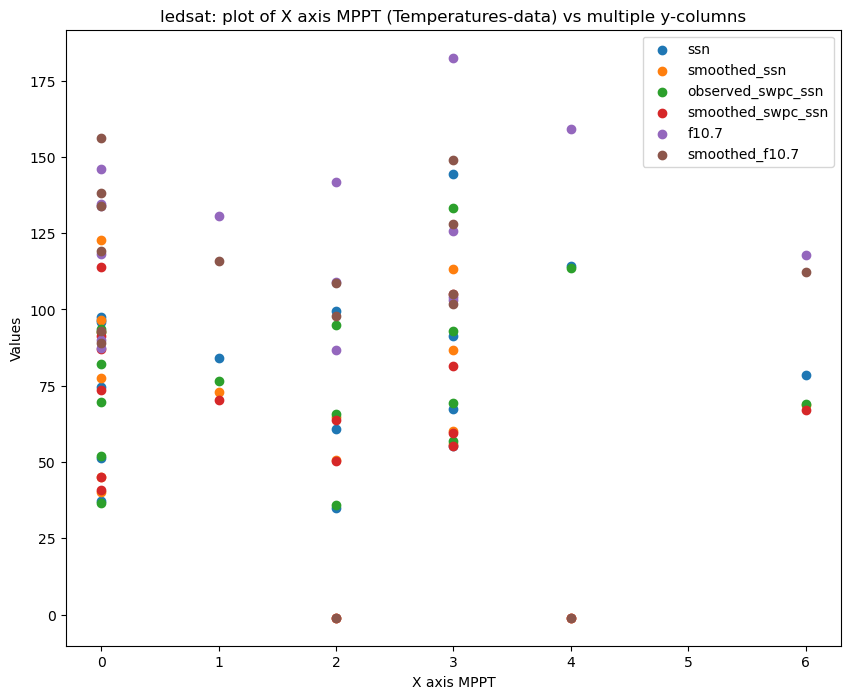

../data/ledsat/Voltages-data-2024-02-11 02 18 53.csv
[Voltages-data]: skipping column=[Battery Voltage V]: not enough unique values.


In [52]:
analyze_satellite('ledsat')

../data/ramsat/Elevation-data-2024-02-11 02 21 27.csv
sampling=[16]
Correlation [Elevation (onboard prediction)] vs [ssn]: classic=[-0.13370587718818663], spearman=[-0.6038298153853374], kendal_tau=[-0.5378341163622515]
sampling=[16]
Correlation [Elevation (onboard prediction)] vs [smoothed_ssn]: classic=[-0.15099815431690006], spearman=[-0.6642127969238713], kendal_tau=[-0.7395219099980959]
sampling=[16]
Correlation [Elevation (onboard prediction)] vs [observed_swpc_ssn]: classic=[-0.08698184449851631], spearman=[-0.6067753266799001], kendal_tau=[-0.5378341163622515]
sampling=[16]
Correlation [Elevation (onboard prediction)] vs [smoothed_swpc_ssn]: classic=[-0.14167998864920908], spearman=[-0.6642127969238713], kendal_tau=[-0.7395219099980959]
sampling=[16]
Correlation [Elevation (onboard prediction)] vs [f10.7]: classic=[-0.10159663835305963], spearman=[-0.6347576839782451], kendal_tau=[-0.605063380907533]
sampling=[16]
Correlation [Elevation (onboard prediction)] vs [smoothed_f10.7]

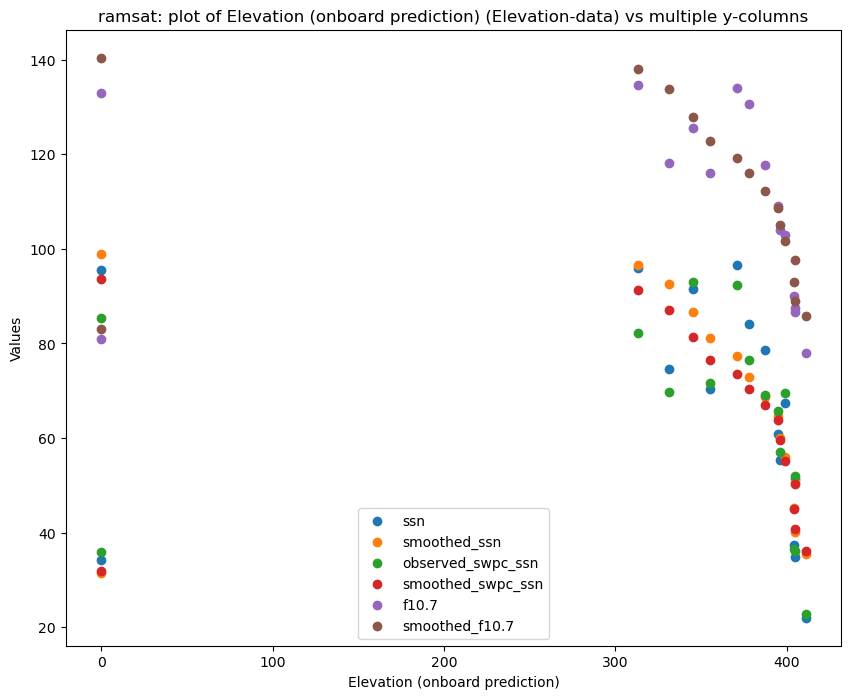

In [53]:
analyze_satellite('ramsat')

../data/ops-sat/Active Transceiver Configuration-data-2024-02-11 02 22 36.csv
[Active Transceiver Configuration-data]: skipping column=[44878.mode]: not enough unique values.
../data/ops-sat/Last Frame Rcvd By-data-2024-02-11 02 22 33.csv
[Last Frame Rcvd By-data]: skipping column=[last where 0 is DP0OPS]: not enough unique values.
../data/ops-sat/Last frame-data-2024-02-11 02 22 26.csv
[Last frame-data]: skipping column=[44878.last]: not enough unique values.
../data/ops-sat/Last RX Frequency Offset-data-2024-02-11 02 22 40.csv
sampling=[44]
Correlation [44878.mode] vs [ssn]: classic=[-0.059491663709783545], spearman=[-0.38351812925036693], kendal_tau=[-0.2849616676461526]
sampling=[44]
Correlation [44878.mode] vs [smoothed_ssn]: classic=[0.11816715133209162], spearman=[-0.3386203151880189], kendal_tau=[-0.2666466338629223]
sampling=[44]
Correlation [44878.mode] vs [observed_swpc_ssn]: classic=[-0.0722644758533372], spearman=[-0.3737646516733667], kendal_tau=[-0.28057764199005797]
sam

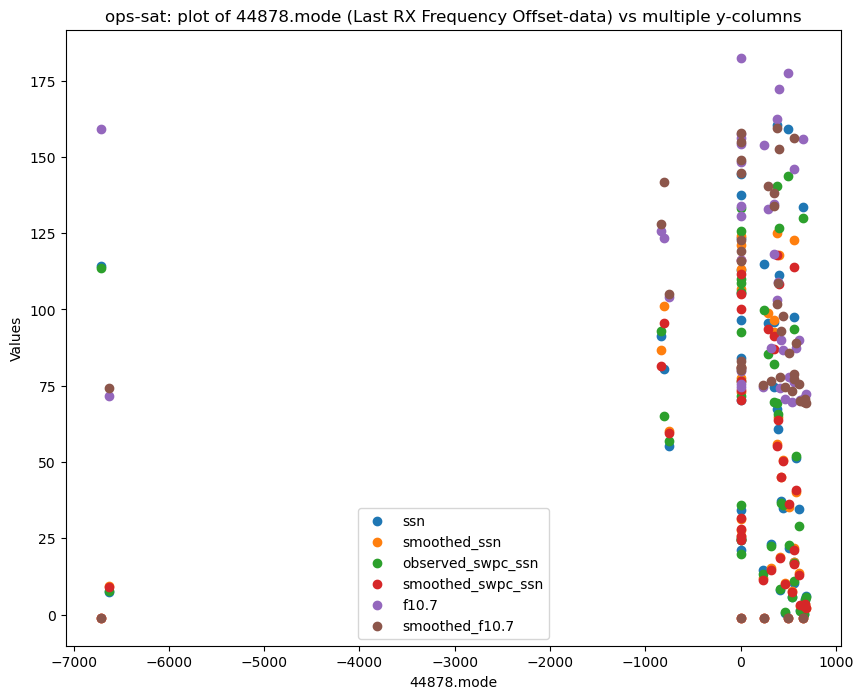

../data/ops-sat/Last valid RX packet timestamp-data-2024-02-11 02 22 43.csv
sampling=[6]
Correlation [Last RX timestamp] vs [ssn]: classic=[-0.4471322606325853], spearman=[-0.7714285714285715], kendal_tau=[-0.6]
sampling=[6]
Correlation [Last RX timestamp] vs [smoothed_ssn]: classic=[-0.45128397587592256], spearman=[-0.7714285714285715], kendal_tau=[-0.6]
sampling=[6]
Correlation [Last RX timestamp] vs [observed_swpc_ssn]: classic=[-0.44414366866522187], spearman=[-0.7714285714285715], kendal_tau=[-0.6]
sampling=[6]
Correlation [Last RX timestamp] vs [smoothed_swpc_ssn]: classic=[-0.45139049264310505], spearman=[-0.7714285714285715], kendal_tau=[-0.6]
sampling=[6]
Correlation [Last RX timestamp] vs [f10.7]: classic=[-0.49618482626249566], spearman=[-0.7714285714285715], kendal_tau=[-0.6]
sampling=[6]
Correlation [Last RX timestamp] vs [smoothed_f10.7]: classic=[-0.4656696190985733], spearman=[-0.7714285714285715], kendal_tau=[-0.6]


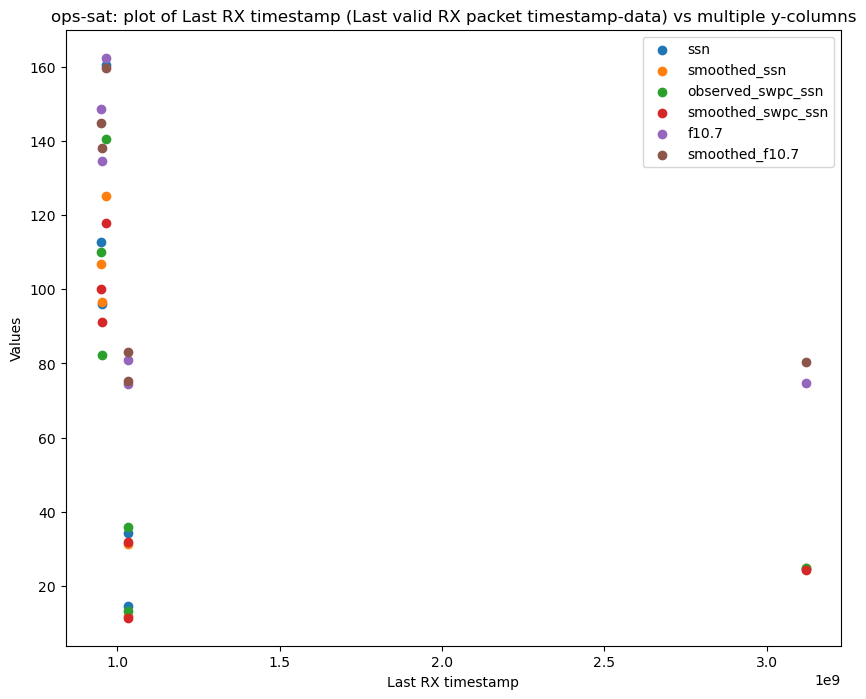

../data/ops-sat/Number of transceiver reboots-data-2024-02-11 02 22 20.csv
sampling=[44]
Correlation [44878.mode] vs [ssn]: classic=[0.8446848738289552], spearman=[0.95799859055673], kendal_tau=[0.8245243128964058]
sampling=[44]
Correlation [44878.mode] vs [smoothed_ssn]: classic=[0.6114764184719342], spearman=[0.3942173053629823], kendal_tau=[0.5802419849505598]
sampling=[44]
Correlation [44878.mode] vs [observed_swpc_ssn]: classic=[0.8580515830136008], spearman=[0.9543340380549683], kendal_tau=[0.8160676532769555]
sampling=[44]
Correlation [44878.mode] vs [smoothed_swpc_ssn]: classic=[0.6152259651811913], spearman=[0.3942173053629823], kendal_tau=[0.5802419849505598]
sampling=[44]
Correlation [44878.mode] vs [f10.7]: classic=[0.8101910035534854], spearman=[0.9463002114164905], kendal_tau=[0.8012684989429175]
sampling=[44]
Correlation [44878.mode] vs [smoothed_f10.7]: classic=[0.25763194506732], spearman=[0.3942173053629823], kendal_tau=[0.5802419849505598]


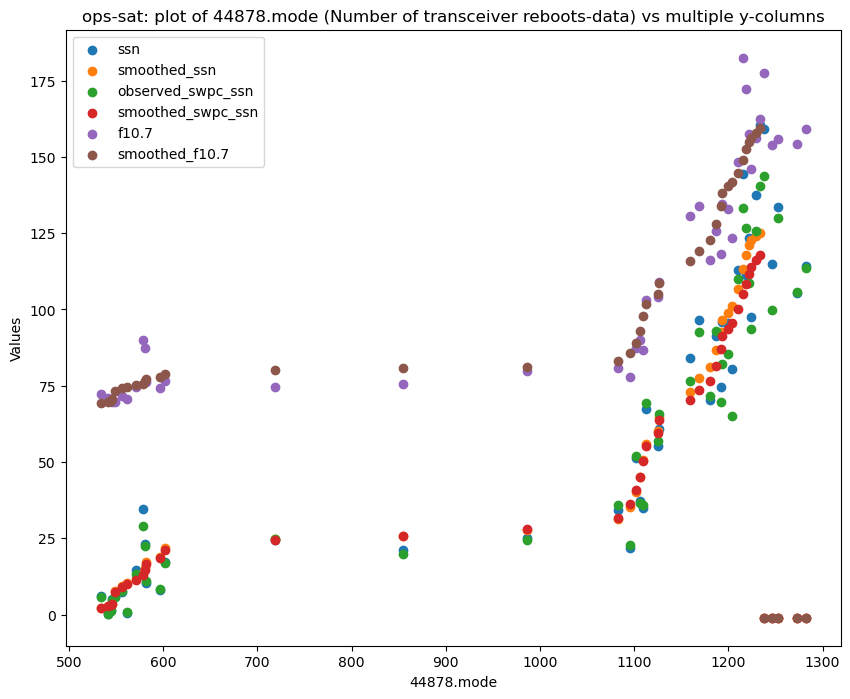

../data/ops-sat/Reboot cause code-data-2024-02-11 02 23 01.csv
[Reboot cause code-data]: skipping column=[44878.mode]: not enough unique values.
../data/ops-sat/RSSI Levels-data-2024-02-11 02 22 31.csv
sampling=[44]
Correlation [Background RSSI Level] vs [ssn]: classic=[0.11452546798948206], spearman=[0.09699038796060029], kendal_tau=[0.08014519598206626]
sampling=[44]
Correlation [Background RSSI Level] vs [smoothed_ssn]: classic=[0.12676229293738153], spearman=[0.1163429581516554], kendal_tau=[0.09602438438376487]
sampling=[44]
Correlation [Background RSSI Level] vs [observed_swpc_ssn]: classic=[0.12728533687282925], spearman=[0.11874060644409502], kendal_tau=[0.09331974874624155]
sampling=[44]
Correlation [Background RSSI Level] vs [smoothed_swpc_ssn]: classic=[0.1345497039906562], spearman=[0.1163429581516554], kendal_tau=[0.09602438438376487]
sampling=[44]
Correlation [Background RSSI Level] vs [f10.7]: classic=[0.08618406147899683], spearman=[0.0915351214354241], kendal_tau=[0.08

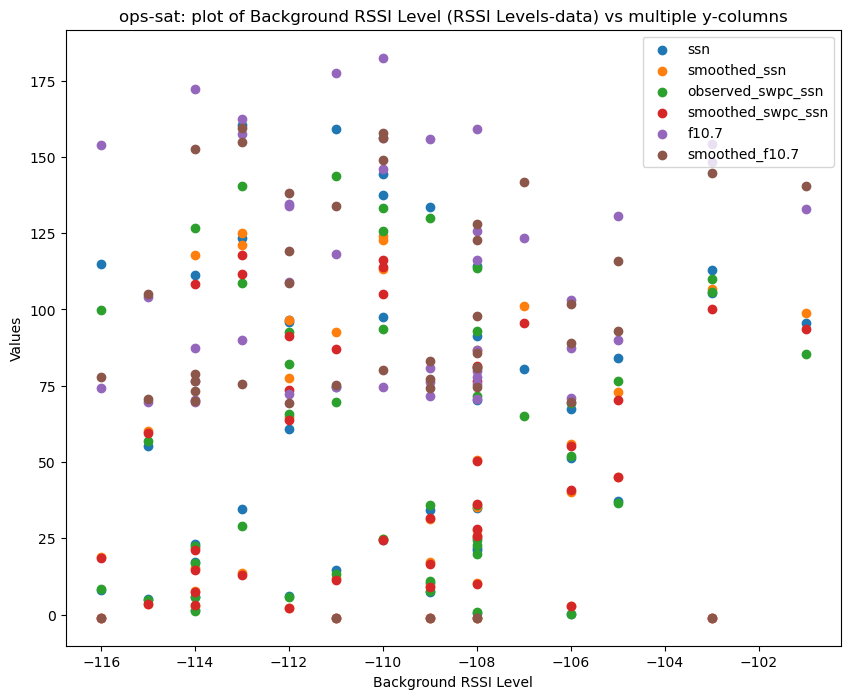

../data/ops-sat/RX bytes since reboot-data-2024-02-11 02 22 46.csv
sampling=[6]
Correlation [44878.mode] vs [ssn]: classic=[0.7274604698557745], spearman=[0.1690308509457033], kendal_tau=[0.08606629658238703]
sampling=[6]
Correlation [44878.mode] vs [smoothed_ssn]: classic=[0.5915804226579668], spearman=[0.1690308509457033], kendal_tau=[0.08606629658238703]
sampling=[6]
Correlation [44878.mode] vs [observed_swpc_ssn]: classic=[0.6950744708468597], spearman=[0.1690308509457033], kendal_tau=[0.08606629658238703]
sampling=[6]
Correlation [44878.mode] vs [smoothed_swpc_ssn]: classic=[0.5938977012793751], spearman=[0.1690308509457033], kendal_tau=[0.08606629658238703]
sampling=[6]
Correlation [44878.mode] vs [f10.7]: classic=[0.6038313395669571], spearman=[0.1690308509457033], kendal_tau=[0.08606629658238703]
sampling=[6]
Correlation [44878.mode] vs [smoothed_f10.7]: classic=[0.5935148017718056], spearman=[0.1690308509457033], kendal_tau=[0.08606629658238703]


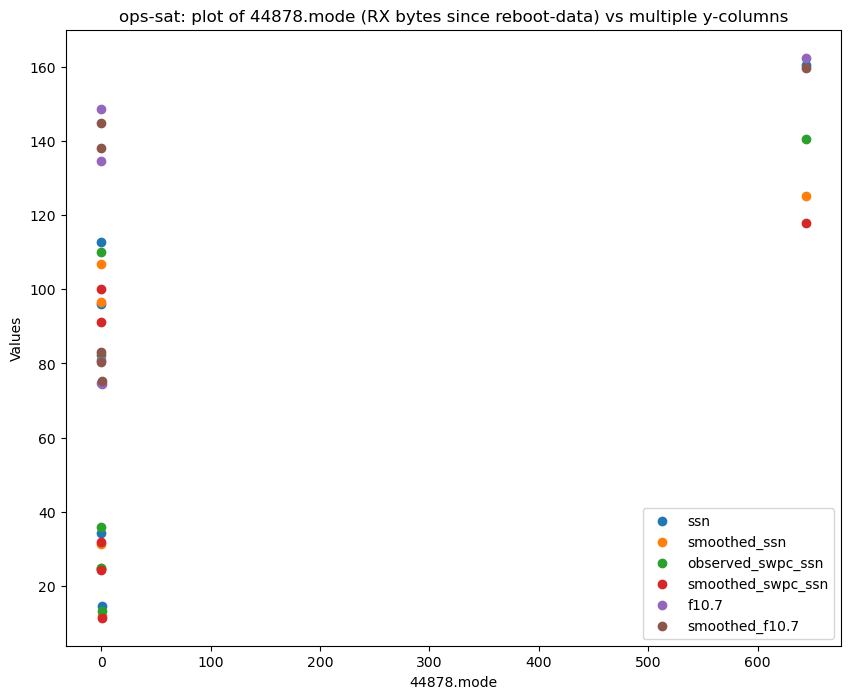

../data/ops-sat/RX packets since reboot-data-2024-02-11 02 22 49.csv
sampling=[44]
Correlation [44878.mode] vs [ssn]: classic=[-0.46696749624892314], spearman=[-0.5570139669779479], kendal_tau=[-0.41790956579659677]
sampling=[44]
Correlation [44878.mode] vs [smoothed_ssn]: classic=[-0.3751151488075954], spearman=[-0.35979897087955176], kendal_tau=[-0.2830390283207232]
sampling=[44]
Correlation [44878.mode] vs [observed_swpc_ssn]: classic=[-0.4732470224556611], spearman=[-0.5427005167909666], kendal_tau=[-0.40031337355252955]
sampling=[44]
Correlation [44878.mode] vs [smoothed_swpc_ssn]: classic=[-0.380788069232996], spearman=[-0.35979897087955176], kendal_tau=[-0.2830390283207232]
sampling=[44]
Correlation [44878.mode] vs [f10.7]: classic=[-0.43246183793592785], spearman=[-0.5324461047167114], kendal_tau=[-0.40031337355252955]
sampling=[44]
Correlation [44878.mode] vs [smoothed_f10.7]: classic=[-0.17285256648565714], spearman=[-0.35979897087955176], kendal_tau=[-0.2830390283207232]


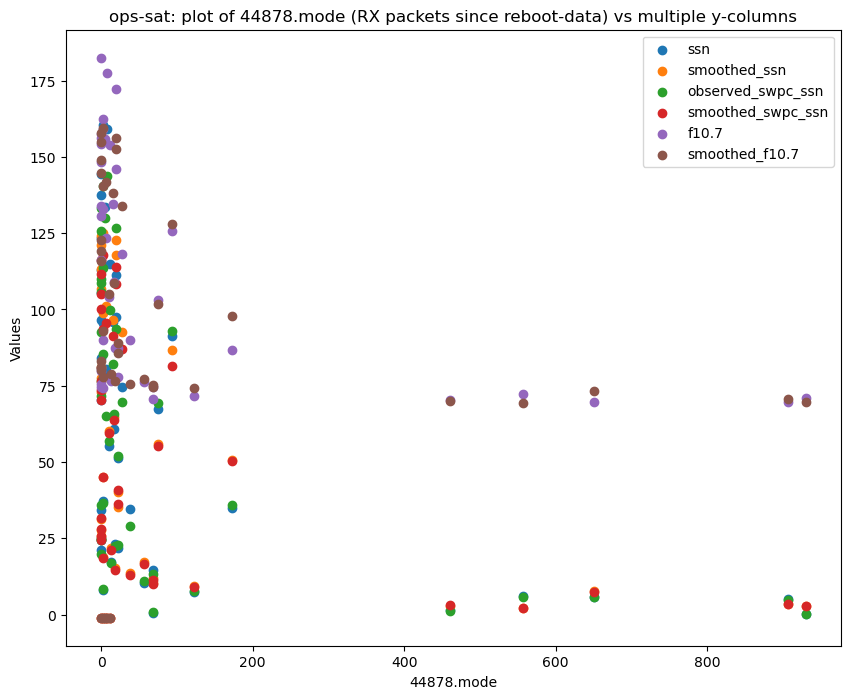

../data/ops-sat/Selected frames count-data-2024-02-11 02 22 13.csv
sampling=[58]
Correlation [Frames] vs [ssn]: classic=[0.8710843695794868], spearman=[0.943395387672659], kendal_tau=[0.8054690190942412]
sampling=[58]
Correlation [Frames] vs [smoothed_ssn]: classic=[0.5463746193911121], spearman=[0.42769069943477955], kendal_tau=[0.5650272127594708]
sampling=[58]
Correlation [Frames] vs [observed_swpc_ssn]: classic=[0.8779752706612863], spearman=[0.942051966859177], kendal_tau=[0.8008003261806966]
sampling=[58]
Correlation [Frames] vs [smoothed_swpc_ssn]: classic=[0.5474360210663652], spearman=[0.4274350073206386], kendal_tau=[0.5645834090673049]
sampling=[58]
Correlation [Frames] vs [f10.7]: classic=[0.850536395313233], spearman=[0.9471296439751553], kendal_tau=[0.804737771536242]
sampling=[58]
Correlation [Frames] vs [smoothed_f10.7]: classic=[0.13464948418335265], spearman=[0.4351884936800848], kendal_tau=[0.5870789483044752]


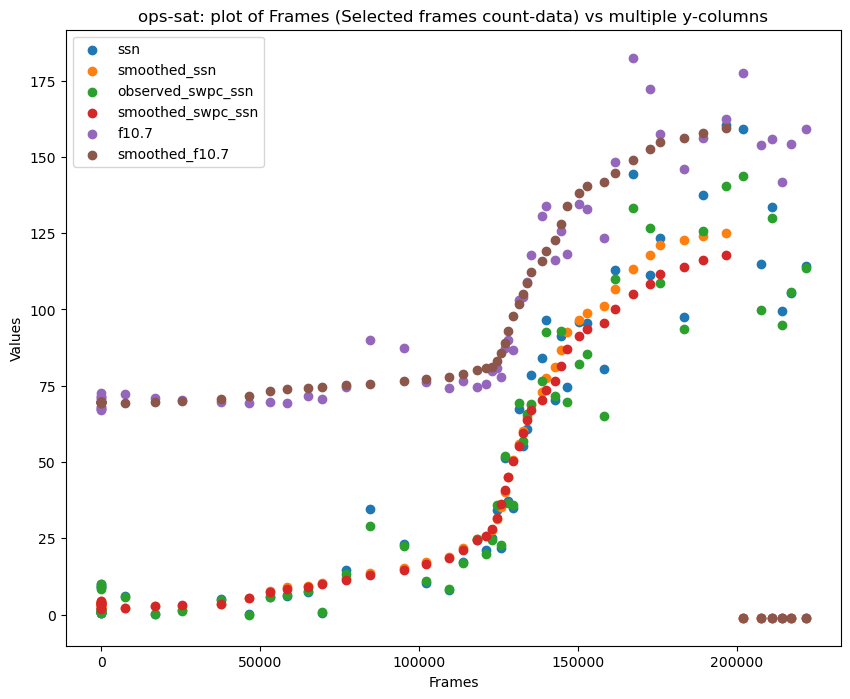

../data/ops-sat/Total RX Bytes-data-2024-02-11 02 22 57.csv
sampling=[6]
Correlation [44878.mode] vs [ssn]: classic=[0.9466175249294271], spearman=[1.0], kendal_tau=[0.9999999999999999]
sampling=[6]
Correlation [44878.mode] vs [smoothed_ssn]: classic=[0.981009592761131], spearman=[1.0], kendal_tau=[0.9999999999999999]
sampling=[6]
Correlation [44878.mode] vs [observed_swpc_ssn]: classic=[0.9521902336784205], spearman=[1.0], kendal_tau=[0.9999999999999999]
sampling=[6]
Correlation [44878.mode] vs [smoothed_swpc_ssn]: classic=[0.9830580515270948], spearman=[1.0], kendal_tau=[0.9999999999999999]
sampling=[6]
Correlation [44878.mode] vs [f10.7]: classic=[0.9574021130109999], spearman=[1.0], kendal_tau=[0.9999999999999999]
sampling=[6]
Correlation [44878.mode] vs [smoothed_f10.7]: classic=[0.9687478358616305], spearman=[1.0], kendal_tau=[0.9999999999999999]


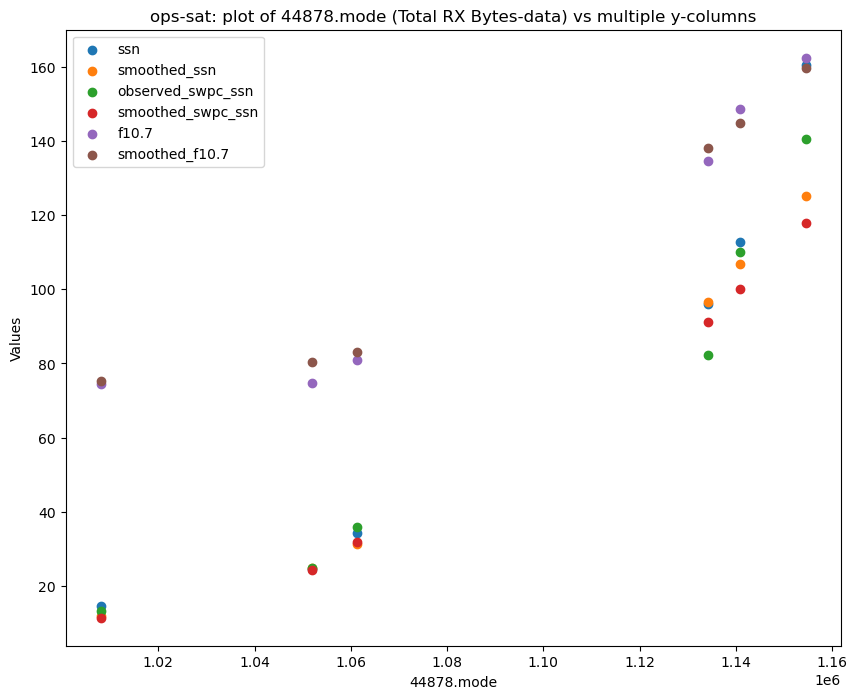

../data/ops-sat/Total RX Packets-data-2024-02-11 02 23 05.csv
sampling=[6]
Correlation [44878.mode] vs [ssn]: classic=[0.9384148168996673], spearman=[1.0], kendal_tau=[0.9999999999999999]
sampling=[6]
Correlation [44878.mode] vs [smoothed_ssn]: classic=[0.9718406029265486], spearman=[1.0], kendal_tau=[0.9999999999999999]
sampling=[6]
Correlation [44878.mode] vs [observed_swpc_ssn]: classic=[0.9452770851714162], spearman=[1.0], kendal_tau=[0.9999999999999999]
sampling=[6]
Correlation [44878.mode] vs [smoothed_swpc_ssn]: classic=[0.9745590132407784], spearman=[1.0], kendal_tau=[0.9999999999999999]
sampling=[6]
Correlation [44878.mode] vs [f10.7]: classic=[0.9442168642356142], spearman=[1.0], kendal_tau=[0.9999999999999999]
sampling=[6]
Correlation [44878.mode] vs [smoothed_f10.7]: classic=[0.9566569899341689], spearman=[1.0], kendal_tau=[0.9999999999999999]


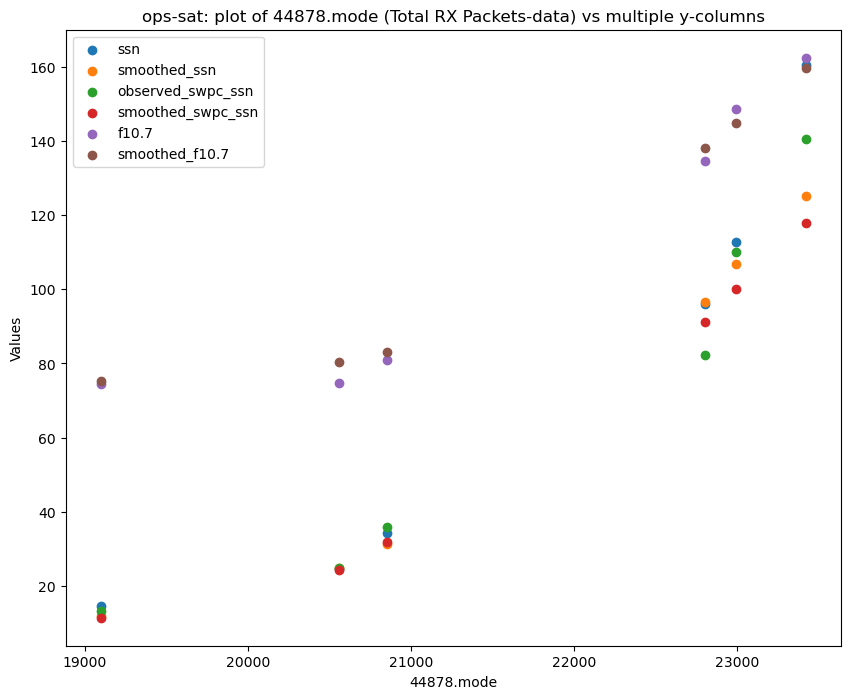

../data/ops-sat/Total TX Bytes-data-2024-02-11 02 23 09.csv
sampling=[6]
Correlation [44878.mode] vs [ssn]: classic=[0.8180040885785574], spearman=[1.0], kendal_tau=[0.9999999999999999]
sampling=[6]
Correlation [44878.mode] vs [smoothed_ssn]: classic=[0.8562224478849352], spearman=[1.0], kendal_tau=[0.9999999999999999]
sampling=[6]
Correlation [44878.mode] vs [observed_swpc_ssn]: classic=[0.8363339025978858], spearman=[1.0], kendal_tau=[0.9999999999999999]
sampling=[6]
Correlation [44878.mode] vs [smoothed_swpc_ssn]: classic=[0.8623699297217553], spearman=[1.0], kendal_tau=[0.9999999999999999]
sampling=[6]
Correlation [44878.mode] vs [f10.7]: classic=[0.8044408930250664], spearman=[1.0], kendal_tau=[0.9999999999999999]
sampling=[6]
Correlation [44878.mode] vs [smoothed_f10.7]: classic=[0.823891421725684], spearman=[1.0], kendal_tau=[0.9999999999999999]


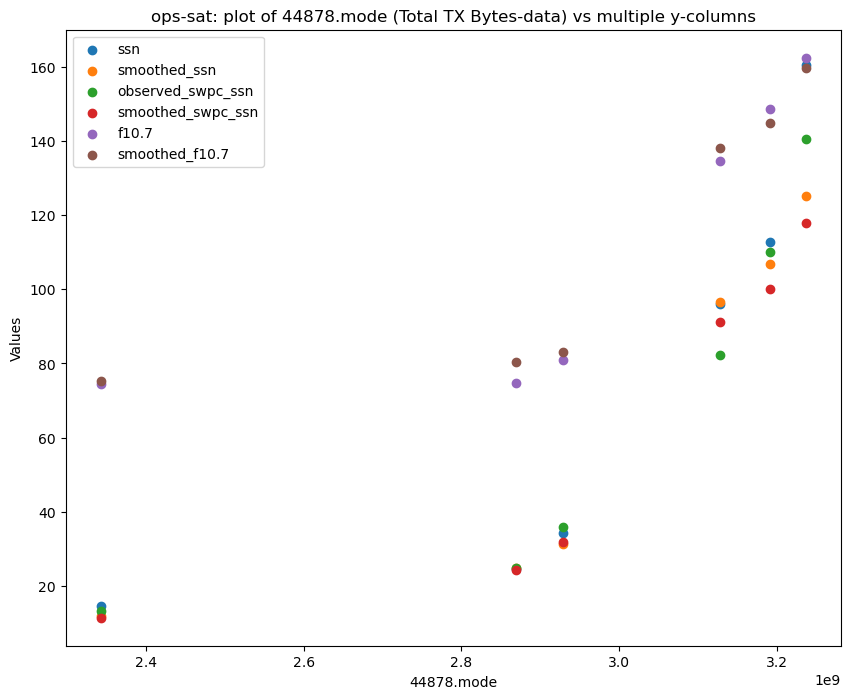

../data/ops-sat/Total TX duty time since reboot-data-2024-02-11 02 22 24.csv
sampling=[6]
Correlation [44878.mode] vs [ssn]: classic=[-0.719895119653985], spearman=[-0.8280786712108251], kendal_tau=[-0.7302967433402214]
sampling=[6]
Correlation [44878.mode] vs [smoothed_ssn]: classic=[-0.7577114973202607], spearman=[-0.8280786712108251], kendal_tau=[-0.7302967433402214]
sampling=[6]
Correlation [44878.mode] vs [observed_swpc_ssn]: classic=[-0.7371456106634752], spearman=[-0.8280786712108251], kendal_tau=[-0.7302967433402214]
sampling=[6]
Correlation [44878.mode] vs [smoothed_swpc_ssn]: classic=[-0.7657368708248949], spearman=[-0.8280786712108251], kendal_tau=[-0.7302967433402214]
sampling=[6]
Correlation [44878.mode] vs [f10.7]: classic=[-0.7294105500896033], spearman=[-0.8280786712108251], kendal_tau=[-0.7302967433402214]
sampling=[6]
Correlation [44878.mode] vs [smoothed_f10.7]: classic=[-0.7300409657927851], spearman=[-0.8280786712108251], kendal_tau=[-0.7302967433402214]


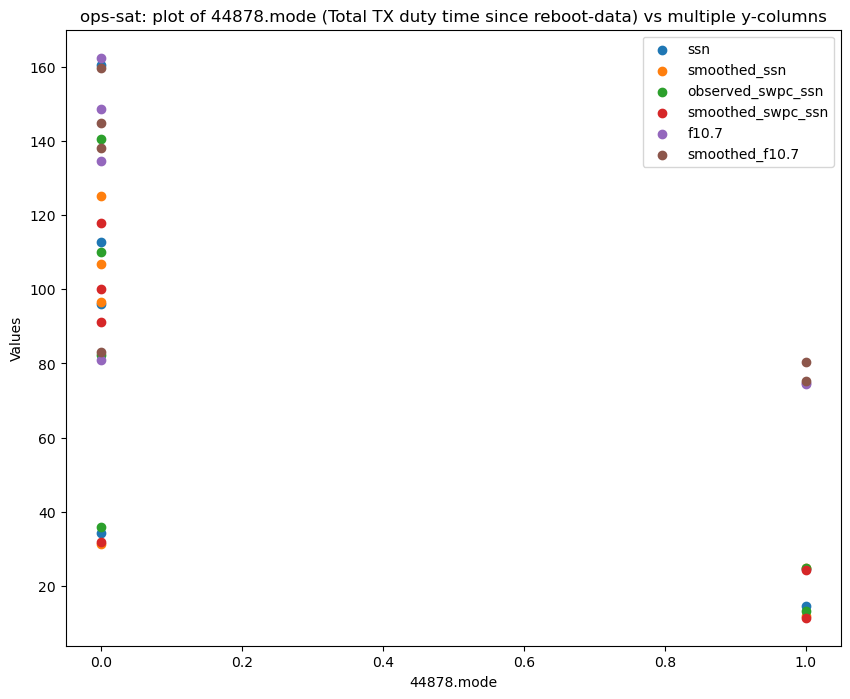

../data/ops-sat/Total TX Packets-data-2024-02-11 02 23 12.csv
sampling=[6]
Correlation [44878.mode] vs [ssn]: classic=[0.8180606107553976], spearman=[1.0], kendal_tau=[0.9999999999999999]
sampling=[6]
Correlation [44878.mode] vs [smoothed_ssn]: classic=[0.8560820984029097], spearman=[1.0], kendal_tau=[0.9999999999999999]
sampling=[6]
Correlation [44878.mode] vs [observed_swpc_ssn]: classic=[0.835968846808116], spearman=[1.0], kendal_tau=[0.9999999999999999]
sampling=[6]
Correlation [44878.mode] vs [smoothed_swpc_ssn]: classic=[0.8621809443390539], spearman=[1.0], kendal_tau=[0.9999999999999999]
sampling=[6]
Correlation [44878.mode] vs [f10.7]: classic=[0.8040793473539394], spearman=[1.0], kendal_tau=[0.9999999999999999]
sampling=[6]
Correlation [44878.mode] vs [smoothed_f10.7]: classic=[0.8239127936620423], spearman=[1.0], kendal_tau=[0.9999999999999999]


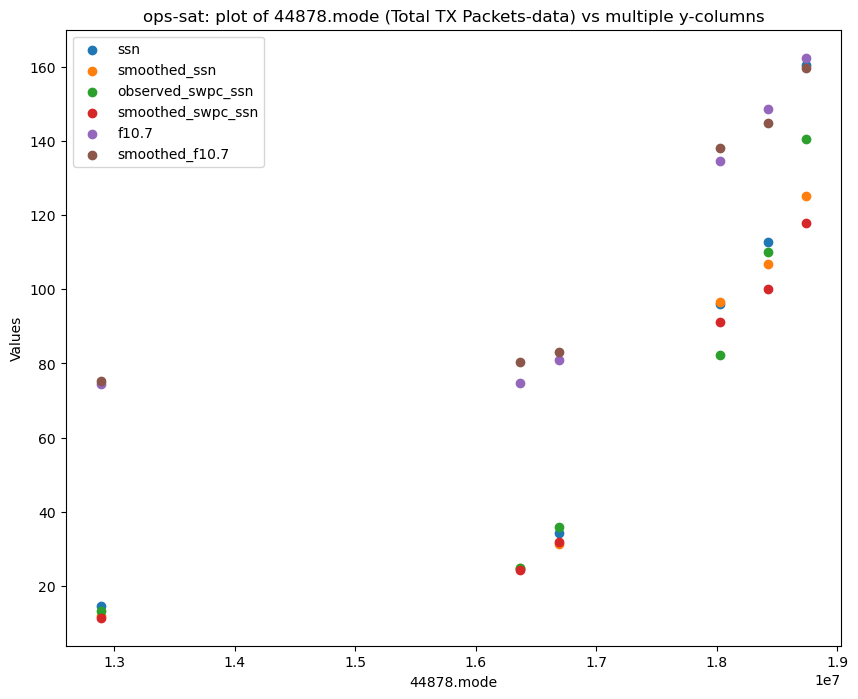

../data/ops-sat/TX bytes since reboot-data-2024-02-11 02 22 51.csv
sampling=[6]
Correlation [44878.mode] vs [ssn]: classic=[0.8565556927374431], spearman=[0.6571428571428573], kendal_tau=[0.6]
sampling=[6]
Correlation [44878.mode] vs [smoothed_ssn]: classic=[0.7604725603791395], spearman=[0.6571428571428573], kendal_tau=[0.6]
sampling=[6]
Correlation [44878.mode] vs [observed_swpc_ssn]: classic=[0.8584375917725885], spearman=[0.6571428571428573], kendal_tau=[0.6]
sampling=[6]
Correlation [44878.mode] vs [smoothed_swpc_ssn]: classic=[0.7581234071514359], spearman=[0.6571428571428573], kendal_tau=[0.6]
sampling=[6]
Correlation [44878.mode] vs [f10.7]: classic=[0.7949908015481553], spearman=[0.6571428571428573], kendal_tau=[0.6]
sampling=[6]
Correlation [44878.mode] vs [smoothed_f10.7]: classic=[0.7665248886724495], spearman=[0.6571428571428573], kendal_tau=[0.6]


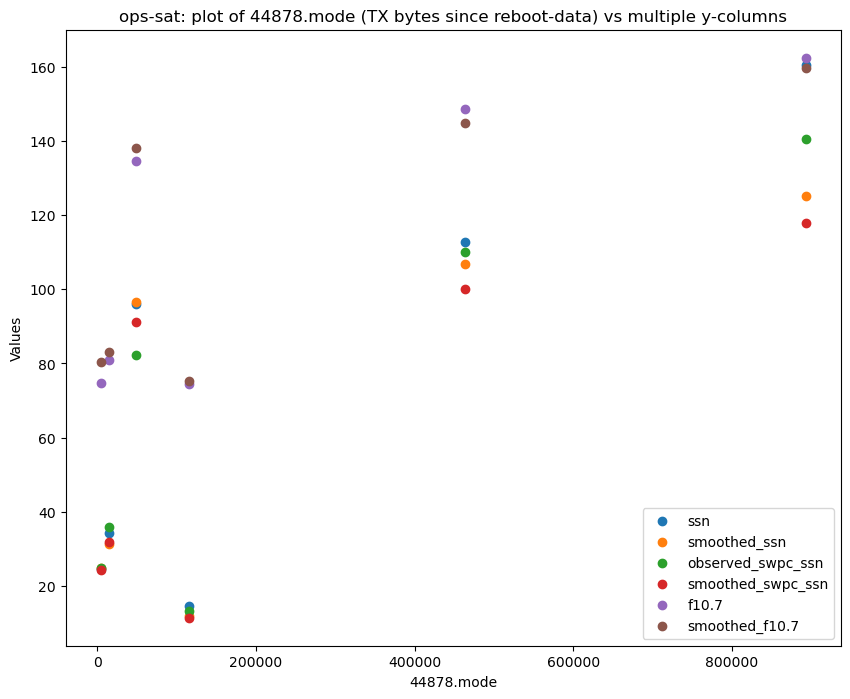

../data/ops-sat/TX packets since reboot-data-2024-02-11 02 22 55.csv
sampling=[44]
Correlation [44878.mode] vs [ssn]: classic=[-0.44590209824899213], spearman=[-0.3455954897815363], kendal_tau=[-0.24101479915433402]
sampling=[44]
Correlation [44878.mode] vs [smoothed_ssn]: classic=[-0.3575986398476551], spearman=[-0.23878708335582433], kendal_tau=[-0.16790885278789094]
sampling=[44]
Correlation [44878.mode] vs [observed_swpc_ssn]: classic=[-0.45303135516566717], spearman=[-0.3306553911205074], kendal_tau=[-0.2198731501057082]
sampling=[44]
Correlation [44878.mode] vs [smoothed_swpc_ssn]: classic=[-0.3631968555155886], spearman=[-0.23878708335582433], kendal_tau=[-0.16790885278789094]
sampling=[44]
Correlation [44878.mode] vs [f10.7]: classic=[-0.4087900680694639], spearman=[-0.3037350246652572], kendal_tau=[-0.21353065539112048]
sampling=[44]
Correlation [44878.mode] vs [smoothed_f10.7]: classic=[-0.16675103907060693], spearman=[-0.23878708335582433], kendal_tau=[-0.16790885278789094]


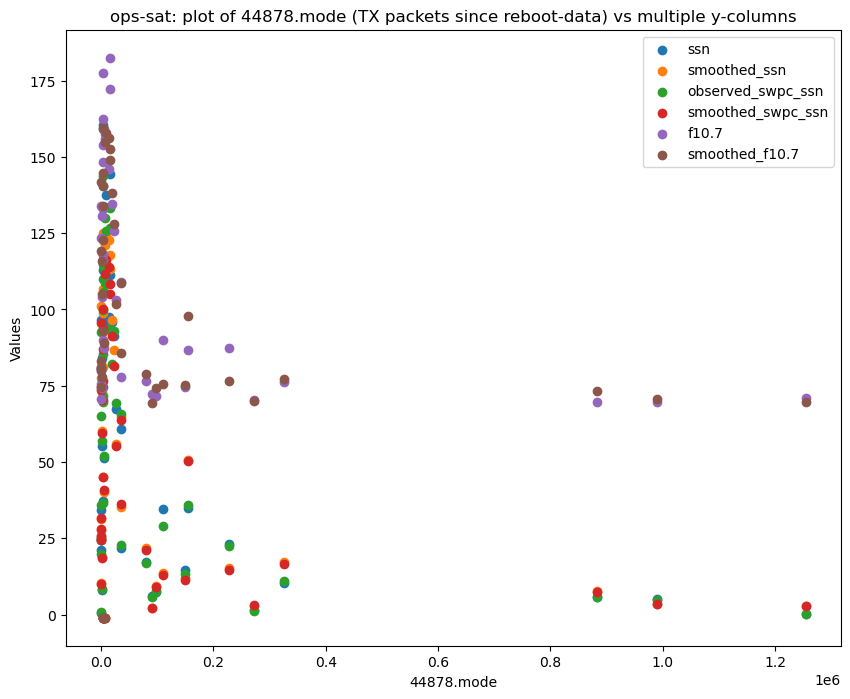

In [54]:
analyze_satellite('ops-sat')

../data/veronika/Internal Magnetometer-data-2024-02-11 02 23 43.csv
sampling=[1]
Correlation [X] vs [ssn]: classic=[nan], spearman=[nan], kendal_tau=[nan]
sampling=[1]
Correlation [X] vs [smoothed_ssn]: classic=[nan], spearman=[nan], kendal_tau=[nan]
sampling=[1]
Correlation [X] vs [observed_swpc_ssn]: classic=[nan], spearman=[nan], kendal_tau=[nan]
sampling=[1]
Correlation [X] vs [smoothed_swpc_ssn]: classic=[nan], spearman=[nan], kendal_tau=[nan]
sampling=[1]
Correlation [X] vs [f10.7]: classic=[nan], spearman=[nan], kendal_tau=[nan]
sampling=[1]
Correlation [X] vs [smoothed_f10.7]: classic=[nan], spearman=[nan], kendal_tau=[nan]


/home/geugenm/anaconda3/envs/course/lib/python3.8/site-packages/numpy/lib/function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/geugenm/anaconda3/envs/course/lib/python3.8/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)


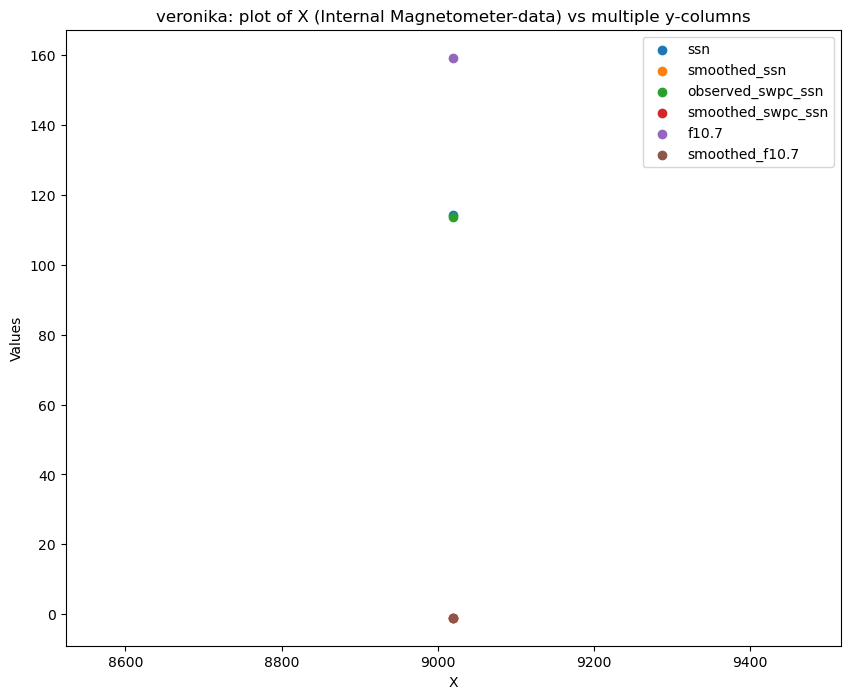

../data/veronika/Last Frame Received-data-2024-02-11 02 23 24.csv
[Last Frame Received-data]: skipping column=[58261.pid]: not enough unique values.
../data/veronika/OBC Uptime Tot.-data-2024-02-11 02 22 35.csv
../data/veronika/OBC Uptime-data-2024-02-11 02 22 31.csv
../data/veronika/PSU GWD Timeout-data-2024-02-11 02 23 39.csv
[PSU GWD Timeout-data]: skipping column=[58261.mode day]: not enough unique values.
../data/veronika/PSU Uptime Tot.-data-2024-02-11 02 22 26.csv
../data/veronika/PSU Uptime-data-2024-02-11 02 22 23.csv
../data/veronika/Radio RSSI-data-2024-02-11 02 22 20.csv
sampling=[1]
Correlation [UHF Act] vs [ssn]: classic=[nan], spearman=[nan], kendal_tau=[nan]
sampling=[1]
Correlation [UHF Act] vs [smoothed_ssn]: classic=[nan], spearman=[nan], kendal_tau=[nan]
sampling=[1]
Correlation [UHF Act] vs [observed_swpc_ssn]: classic=[nan], spearman=[nan], kendal_tau=[nan]
sampling=[1]
Correlation [UHF Act] vs [smoothed_swpc_ssn]: classic=[nan], spearman=[nan], kendal_tau=[nan]
s

/tmp/ipykernel_77773/3533758053.py:27: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')
/home/geugenm/anaconda3/envs/course/lib/python3.8/site-packages/numpy/lib/function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/geugenm/anaconda3/envs/course/lib/python3.8/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)


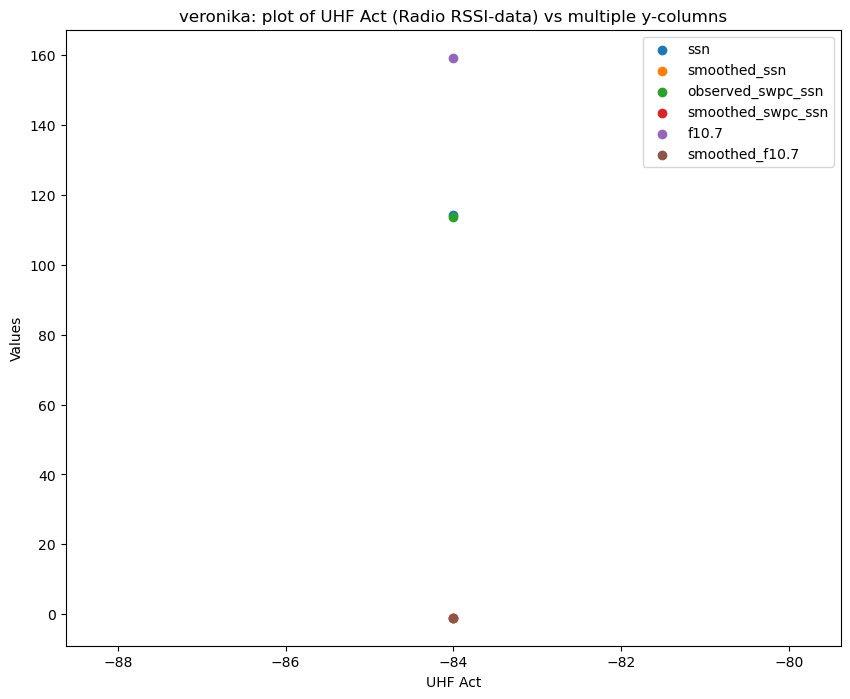

../data/veronika/Transmitted message-data-2024-02-11 02 23 29.csv
../data/veronika/UHF Digipeater usage-data-2024-02-11 02 22 38.csv
sampling=[0]
Correlation [58261.mode] vs [ssn]: classic=[nan], spearman=[nan], kendal_tau=[nan]
sampling=[0]
Correlation [58261.mode] vs [smoothed_ssn]: classic=[nan], spearman=[nan], kendal_tau=[nan]
sampling=[0]
Correlation [58261.mode] vs [observed_swpc_ssn]: classic=[nan], spearman=[nan], kendal_tau=[nan]
sampling=[0]
Correlation [58261.mode] vs [smoothed_swpc_ssn]: classic=[nan], spearman=[nan], kendal_tau=[nan]
sampling=[0]
Correlation [58261.mode] vs [f10.7]: classic=[nan], spearman=[nan], kendal_tau=[nan]
sampling=[0]
Correlation [58261.mode] vs [smoothed_f10.7]: classic=[nan], spearman=[nan], kendal_tau=[nan]


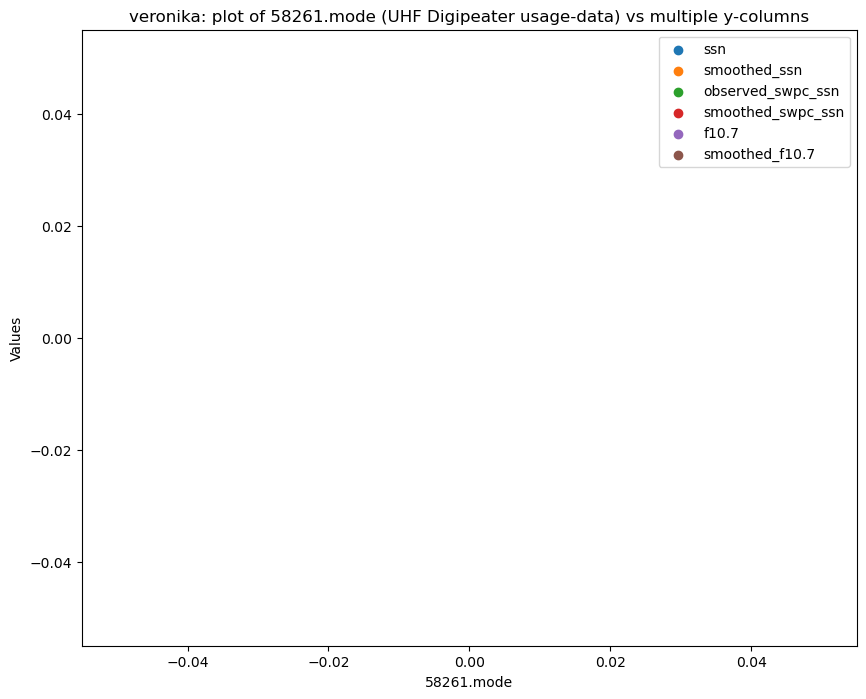

../data/veronika/UHF last digipeater user-data-2024-02-11 02 23 32.csv
../data/veronika/UHF Last temperatures-data-2024-02-11 02 23 03.csv
../data/veronika/UHF Received packets-data-2024-02-11 02 23 18.csv
sampling=[0]
Correlation [58261.mode] vs [ssn]: classic=[nan], spearman=[nan], kendal_tau=[nan]
sampling=[0]
Correlation [58261.mode] vs [smoothed_ssn]: classic=[nan], spearman=[nan], kendal_tau=[nan]
sampling=[0]
Correlation [58261.mode] vs [observed_swpc_ssn]: classic=[nan], spearman=[nan], kendal_tau=[nan]
sampling=[0]
Correlation [58261.mode] vs [smoothed_swpc_ssn]: classic=[nan], spearman=[nan], kendal_tau=[nan]
sampling=[0]
Correlation [58261.mode] vs [f10.7]: classic=[nan], spearman=[nan], kendal_tau=[nan]
sampling=[0]
Correlation [58261.mode] vs [smoothed_f10.7]: classic=[nan], spearman=[nan], kendal_tau=[nan]


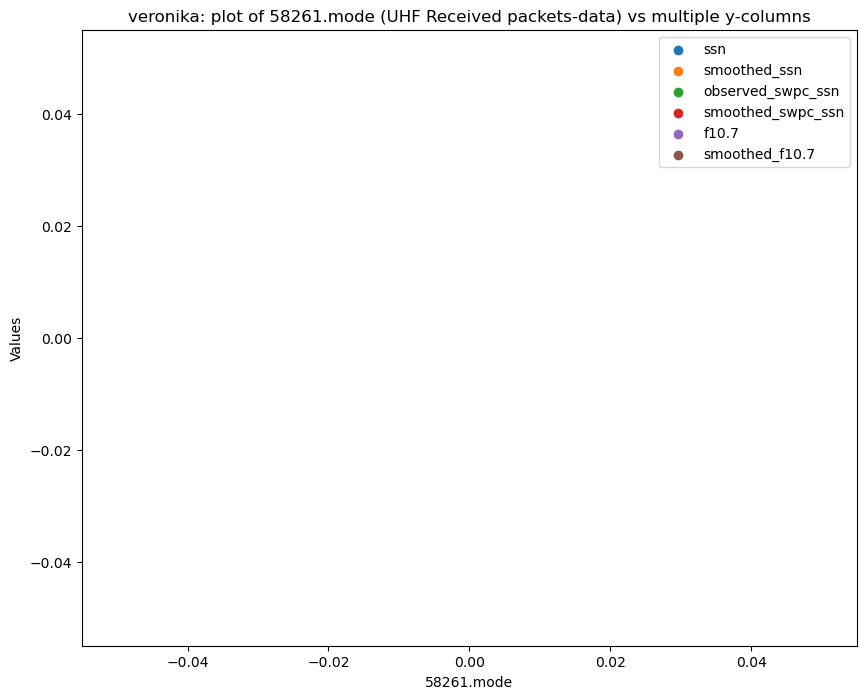

../data/veronika/UHF Resets-data-2024-02-11 02 23 11.csv
[UHF Resets-data]: skipping column=[58261.mode]: not enough unique values.
../data/veronika/UHF RF Resets-data-2024-02-11 02 23 37.csv
[UHF RF Resets-data]: skipping column=[58261.mode]: not enough unique values.
../data/veronika/UHF Temperatures-data-2024-02-11 02 23 07.csv
../data/veronika/UHF Transmitted packets-data-2024-02-11 02 23 22.csv
sampling=[0]
Correlation [58261.mode] vs [ssn]: classic=[nan], spearman=[nan], kendal_tau=[nan]
sampling=[0]
Correlation [58261.mode] vs [smoothed_ssn]: classic=[nan], spearman=[nan], kendal_tau=[nan]
sampling=[0]
Correlation [58261.mode] vs [observed_swpc_ssn]: classic=[nan], spearman=[nan], kendal_tau=[nan]
sampling=[0]
Correlation [58261.mode] vs [smoothed_swpc_ssn]: classic=[nan], spearman=[nan], kendal_tau=[nan]
sampling=[0]
Correlation [58261.mode] vs [f10.7]: classic=[nan], spearman=[nan], kendal_tau=[nan]
sampling=[0]
Correlation [58261.mode] vs [smoothed_f10.7]: classic=[nan], spea

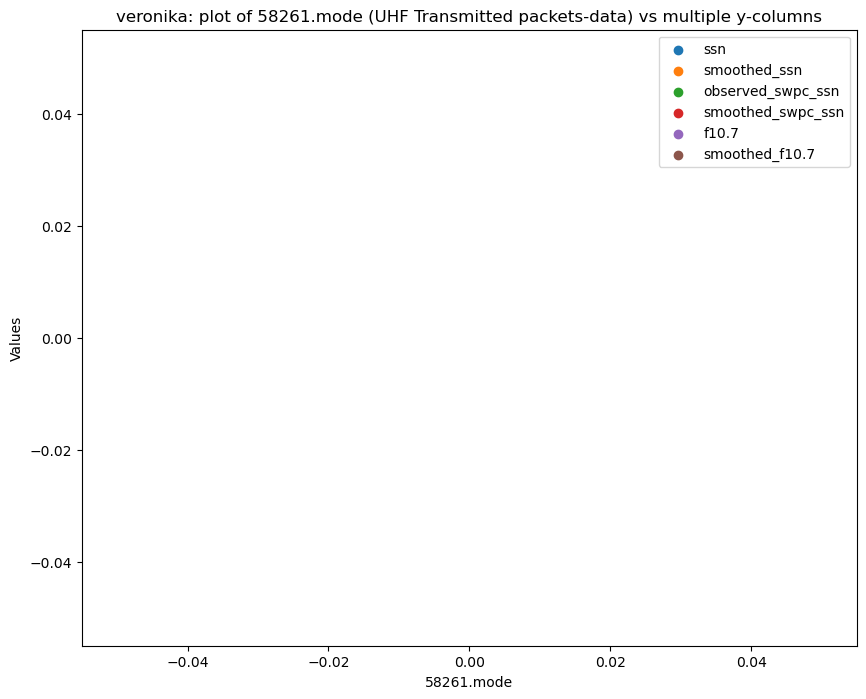

../data/veronika/UHF Uptime (s)-data-2024-02-11 02 22 42.csv
sampling=[0]
Correlation [58261.mode] vs [ssn]: classic=[nan], spearman=[nan], kendal_tau=[nan]
sampling=[0]
Correlation [58261.mode] vs [smoothed_ssn]: classic=[nan], spearman=[nan], kendal_tau=[nan]
sampling=[0]
Correlation [58261.mode] vs [observed_swpc_ssn]: classic=[nan], spearman=[nan], kendal_tau=[nan]
sampling=[0]
Correlation [58261.mode] vs [smoothed_swpc_ssn]: classic=[nan], spearman=[nan], kendal_tau=[nan]
sampling=[0]
Correlation [58261.mode] vs [f10.7]: classic=[nan], spearman=[nan], kendal_tau=[nan]
sampling=[0]
Correlation [58261.mode] vs [smoothed_f10.7]: classic=[nan], spearman=[nan], kendal_tau=[nan]


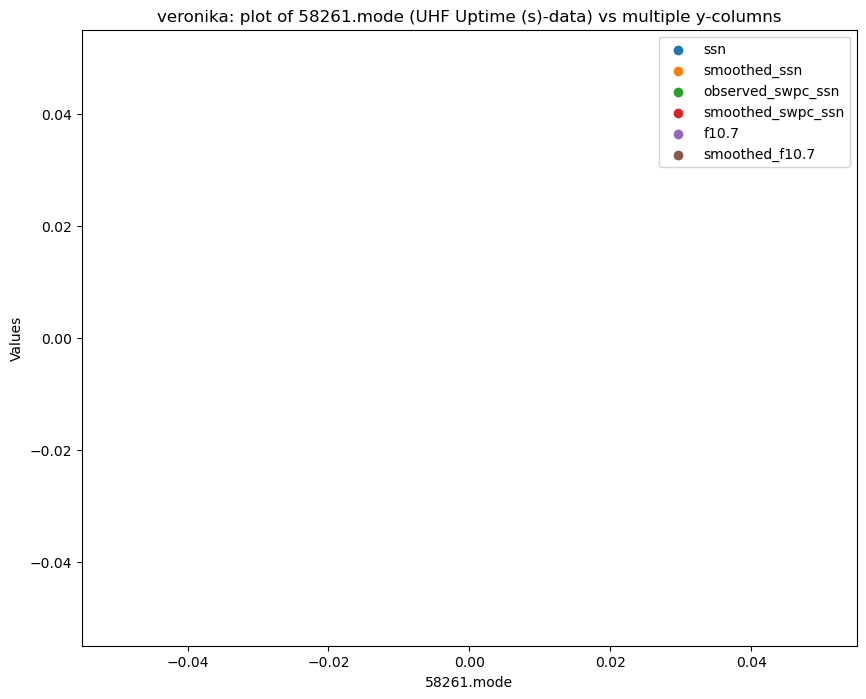

../data/veronika/UHF Uptime Tot. (s)-data-2024-02-11 02 22 48.csv
sampling=[0]
Correlation [58261.mode] vs [ssn]: classic=[nan], spearman=[nan], kendal_tau=[nan]
sampling=[0]
Correlation [58261.mode] vs [smoothed_ssn]: classic=[nan], spearman=[nan], kendal_tau=[nan]
sampling=[0]
Correlation [58261.mode] vs [observed_swpc_ssn]: classic=[nan], spearman=[nan], kendal_tau=[nan]
sampling=[0]
Correlation [58261.mode] vs [smoothed_swpc_ssn]: classic=[nan], spearman=[nan], kendal_tau=[nan]
sampling=[0]
Correlation [58261.mode] vs [f10.7]: classic=[nan], spearman=[nan], kendal_tau=[nan]
sampling=[0]
Correlation [58261.mode] vs [smoothed_f10.7]: classic=[nan], spearman=[nan], kendal_tau=[nan]


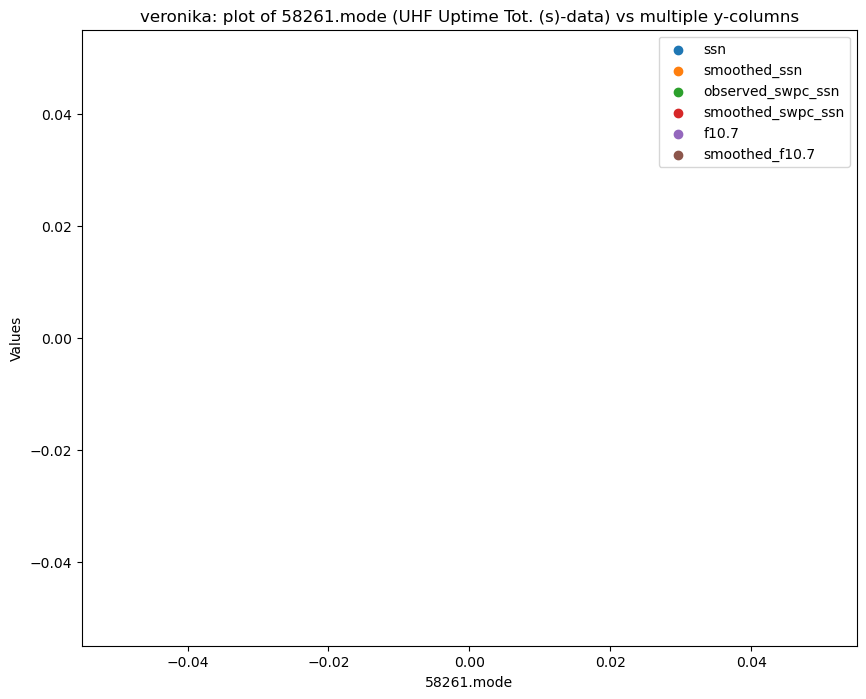

../data/veronika/UHF Uptime Tot.-data-2024-02-11 02 22 58.csv
../data/veronika/UHF Uptime-data-2024-02-11 02 22 52.csv


In [55]:
analyze_satellite('veronika')

In [56]:
analyze_satellite('vzlusat-2')

../data/vzlusat-2/Battery Temperature-data-2024-02-11 02 21 24.csv
../data/vzlusat-2/Last Beacon Received By-data-2024-02-11 02 21 26.csv
[Last Beacon Received By-data]: skipping column=[last]: not enough unique values.
